In [1]:
from bh_functions import *
import math
import time

Using TensorFlow backend.
C:\Users\luluw\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\luluw\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\luluw\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\luluw\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

Imported successfully


# Settings of Surrogate model

In [2]:
# Set the ABM Evaluation Budget
budget = 2500

# Set initial evaluated set size, batch size and training pool size
ini_size = int(budget/2)
#batch = int(math.log(budget))
batch = 50
pool_size = budget*batch

# Set out-of-sample test and montecarlo sizes
test_size = 1000
montecarlos = 10

# Get an on out-of-sample test set that does not have combinations from the
# batch or iterative experiments
final_test_size = (test_size * montecarlos)

# Set the ABM parameters and support
bh_exploration_range = np.array([(-2.0, 2.0), # trend_2
                                 (-2.0, 2.0), # trend_1
                                 (0.0, 10.0), # switching_parameter
                                 (0.0, 100.0),# alpha 
                                 (-2.0, 2.0), # bias_2 
                                 (0.0, 1.0),  # weight_past_profits
                                 (-2.0, 2.0), # bias_1
                                 (0.0, 5.0),  # rational_expectation_cost
                                 (1.01, 1.1)])# risk_free_return

In [4]:
# -----
# method:  
#    method and active learning goal
method = "classification"  # "regression", "classification"

# -----
# threshold:  
#    threshold for a real valued y to be considered as a postive prediction
threshold = 0

# -----
# model:
model = "ANN"   # "Gradient boost","XGBoost" and "ANN" 

# Generate X train and X test, evaluate X test labels

In [5]:
start = time.time()

param_dims = bh_exploration_range.shape[0]
print("There is {} parameters in BH model.".format(param_dims))

# Generate Sobol samples for training set
n_dimensions = bh_exploration_range.shape[0]

load_data = False

if load_data == False:
    # Build X_train_pool
    X_train_pool = get_sobol_samples(n_dimensions, pool_size, bh_exploration_range)

    # Build X_test
    X_test = get_sobol_samples(n_dimensions, final_test_size*batch, bh_exploration_range)  # Building a 
                                                    # bigger pool to draw from to avoid overlapping with X_train_pool
    '''
    selections = []
    for i, v in enumerate(X_test):   # to avoid overlapping of choices
        if (v not in X_train_pool):
            selections.append(i)
    X_test = unique_rows(X_test[selections])[:final_test_size]   # Final size of X_test is final_test_size
    '''
    np.random.shuffle(X_test)    # shuffle it first
    X_test = X_test[:final_test_size,:]

    # Evaluate the test set for the ABM response
    y_test = evaluate_bh_on_set(X_test, method, threshold)  

    # Output data as a csv
    pd.DataFrame(X_train_pool).to_csv("budget_" + str(budget) + "_X_train_pool.csv")
    pd.DataFrame(X_test).to_csv("budget_" + str(budget) +"_X_test.csv")
    pd.DataFrame(y_test).to_csv("budget_" + str(budget) +"_y_test.csv")
else:
    X_train_pool = pd.read_csv("budget_" + str(budget) + "_X_train_pool.csv").values[:,1:]
    X_test = pd.read_csv("budget_" + str(budget) + "_X_test.csv").values[:,1:]
    y_test = pd.read_csv("budget_" + str(budget) + "_y_test.csv").values[:,-1]
    
end = time.time()    

There is 9 parameters in BH model.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


In [6]:
print(f"Runtime of this part is {end - start}")

Runtime of this part is 63.030770778656006


In [7]:
print_y_test_info(y_test, method, threshold)

There are 1135 out of 10000 in the y test set that are positive.


# Generate default X,y train for non-active learning

In [8]:
# Build train data without active learning
np.random.shuffle(X_train_pool)    # shuffle it first
default_X_train = X_train_pool[:budget,:]  
default_y_train = evaluate_bh_on_set(default_X_train, method, threshold)

In [9]:
print_evaluated_set_y_info(default_y_train,method, threshold)

There are 316 out of 2500 in the evaluated y set that are positive.


# Generate first X evaluated batch and respective label for active learning

In [10]:
# Build first X evaluated batch with size ini_size
np.random.shuffle(X_train_pool)   # shuffle it first
ini_evaluated_set_X = X_train_pool[:ini_size,:]
unevaluated_set_X = X_train_pool[ini_size:,:]

# Evaluate the train set for the ABM response
ini_evaluated_set_y = evaluate_bh_on_set(ini_evaluated_set_X, method, threshold)

In [11]:
print_evaluated_set_y_info(ini_evaluated_set_y,method, threshold)

There are 131 out of 1250 in the evaluated y set that are positive.


# Experimentation

In this section, I will explore few classification options and compare their performaces. The options are as follows:

### 1. Gradient boost with optimal hyperparameters each round chosen by gridsearch
#### a. With active learning
#### b. No active learning
### 2. XG boost with optimal hyperparameters each round chosen by gridsearch
#### a. With active learning
#### b. No active learning
### 3. ANN with fixed topology 
#### a. With active learning
#### b. No active learning
### 4. Bench mark: gaussian process classification with no active learning

# First go through procedure with the largest budget as an example

# Gradient Boost

In [12]:
model = "Gradient boost"

## Gradient Boost Active learning:

In [13]:
gb_X_train, gb_y_train = active_learning(ini_evaluated_set_X, ini_evaluated_set_y, unevaluated_set_X, budget, method, model, threshold, batch)

--------------------------------------------------------
There are still 1250 parameter unevaluated within budget.
Surrogate model predicted 9664 positive labels out of 123750: 
Parameters bundles of indices:  [ 39387 109178  53962  34192 100667  50652  73985 121160  31467  85330
  21528 115832  87544  68360  70729  88447  86519  28072  26382  50484
    111  51461  74397 119751  26177  47217 110007  49025  44451  51388
  67242  92373  29471  53685  55419  49841 107279  55470  43615  62347
  85611  62558  70593  56313  67009 103253  14896  45410 111759  80958]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1200 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 10683 positive labels out of 123750: 
Parameters bundles of indices:  [ 67949  53358  24576 111802  13748  33824  39674 107925  40096  34506
  18707  41971  12926  97024  30467 111657  49832 121592  35328  61670
  91328 101498  36753  97261  82866  47277  64323  16394 104055 123549
  62936  42921  49875  94780  42392  20765  89064  98184  27121   7797
  61648 105514  86543   2039  91584   2260  92930   5868   9164  62104]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1150 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 10654 positive labels out of 123750: 
Parameters bundles of indices:  [121988  72565 106349 110606  70094  78184  48084  94568 103510   5800
  53179  62963  30081  96813  93421  61874  82104 118868  13587  30548
  37340  19412   8989  87319   3171  25844  81455  16066  54451  43771
  43860  20617   7771  34817  81814  51271  61976  84843  94921  40419
  76659  78228  48306   5813   6681 101668  18716  60414  74592  79937]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1100 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 11301 positive labels out of 123750: 
Parameters bundles of indices:  [ 78768  71620 120717  88323  40032 110780  17479 116867  71838 111588
  71780 103483  43793  41611  82697  27062  73461  46565  37340  83761
   1684  73511  73193  49429  40474  45779  72650  50198  83505 112722
 122387 102019  66549  39539  62471  28239  11600  20271  13508  26210
 110958  14412  85783  17534 106639  96997  41181  72574 100046 117333]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1050 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 11889 positive labels out of 123750: 
Parameters bundles of indices:  [100476  28882 107282  33542  64429  78803  15751  73120 113525  94633
  40142  69085  19591   5200  41264  53902 117289  86418  16519  78102
  49681 111672  20111 108788  57030  20319 116824  39905  99923   9373
   4794   4971  65580  29187  34760  71754 107476 117313  77418   4137
  61870  36363  77642  25266  99774 113327  17546 113976 107897 104790]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1000 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 11761 positive labels out of 123750: 
Parameters bundles of indices:  [ 66802  82737  72882 106098  87283 120014  93703  64133  18449  52677
  75498  26940  22533  38224  25474  74270  78863  77424 112007  59909
  13674 120752  76211  43797  46357 112715   1494  46540  11306  94799
 107440  29692  69555 119192  97770  73238  89209  58446  37578  77488
  38277 100613 103570  42944  72360  40609  17479  76967  42158  28315]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 950 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 12858 positive labels out of 123750: 
Parameters bundles of indices:  [ 29277 114532  55765  38683  42502  80623 102807 103460  21168  48710
   7218  58353  21531 115249  61179  68526  46615  69755  98977  65116
  80410  17094  91507  27744 115590  93767  77932  17992  43511  18039
  28092   3912  16426  45002 107608  87158  22761  21350  65887  20519
  97340  31912  87818  30358   5322  54166  41003  77357  76752 100499]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 900 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 12690 positive labels out of 123750: 
Parameters bundles of indices:  [ 90822 120442  25348  21295  82714  67460  38770  30774  25915  49247
   8247  66864 120810  77448  45632  10915  23863  15917  22389   1110
  61568  68962  37064 120282  15912  52081  80701 118177  64496  43763
  85947  70489  55552  88109  10167  92521 118951  47936  80110  33161
  25468 110738 121207 114164   7330   4428 118152 103866  82569   2567]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 850 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 12884 positive labels out of 123750: 
Parameters bundles of indices:  [ 91523  80585  63591  74595 123276  31082  40378 115110  86992  63860
  32472   8259  68207  27689 102430  83108 109435 116798 114727  55430
  89347  86260  26921  68423  21311  35751  81194  58357 100794  10740
   5392 111851  45839  51487  41547  29548  35978  91335 119053  37833
  15979  76867 123079  97755  71226 123702  76967 107204  32802  23387]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 800 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 13033 positive labels out of 123750: 
Parameters bundles of indices:  [ 71607  73044  39178  73923  93479  15990  88233  10565 106261   7077
  14935  33276  95989  19288   1249  70236  67883 105450  48215  36790
 107907  32536  54072  46636 108663  42317   3479  97462  56204   9411
  83504  35196  13122  22220  31777 117377 106095  17486  59726  60305
  39182 118435 117350  88101  97145  80104  39444  23633  41051  89823]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 750 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 13189 positive labels out of 123750: 
Parameters bundles of indices:  [117306  79520  71480  17449  16694  47129  61478  96224 122983   8147
  71440 113992  26114  65188  55769  83087  23438 115861  28548  30648
  46273  17637  11990  99080  82585 117508  48028  45337  55070  78045
  64207  30937 107929 102019  87860 108720   8960  26001  29410  81131
 102882  39456 119157 100713  60069  75740  62484  35534  88264 103676]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 700 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 13366 positive labels out of 123750: 
Parameters bundles of indices:  [ 15780 105617  38235  14087  49585 118922  10510 100775  20510  40161
  75985  46205  29735  29719 112944 105155  55676 122737  77626  12067
  26965  57740  30325  21426 108123  94118  37184 109572  71440 102840
 117508  27513  71045   3631  78853  54797  92897  32365  84743  12672
  45791  96690  25218  69068   1658  41790 109466  60705  20387   4296]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 650 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 13483 positive labels out of 123750: 
Parameters bundles of indices:  [117477  44760   4495  91330  40100   6064  42158  31792 101729  53181
  74946 117042 109937  95039 118356  97277 118815 119415 120793  52307
   9003  47413 117743   4928   5820  77733  37833 119593  83329  31370
  78243  88705  32001 121670  90375  20387  24297  10515   4538 105921
  46837  99484   3509 113845 105340 101918 102942  97769  77148 105007]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 600 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 13426 positive labels out of 123750: 
Parameters bundles of indices:  [  4424  49417  24242 108962  46077  25652  80110  71278  45453  21407
  50141  35072  33596 105004   5833 118763  73251 117771  35474 120491
  20615  40569  76397  76506   4971  77870  20829  32686  76620  37899
  82778  90158  28852  40032 100043  40541  36930  94041  83125  70443
  41831  33956  72670 113404  81029  42354   2877 112199  19833  63285]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 550 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 13649 positive labels out of 123750: 
Parameters bundles of indices:  [ 86226  67926  71780   5680  60926  13733  95504  42394  28245  33972
  47227  94118  11287    344 122458  62573  74581   7771 117598 119252
 119296  89196  91122  11866  74217  74160  68894  76009  61977  81588
 115142 110778 101630  49345   6196  43307  36601 110370   6727  60165
 116415  46058   4203 115369  14858  50378  47645  13709  58449  85995]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 500 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 13826 positive labels out of 123750: 
Parameters bundles of indices:  [106629  24317 108036  17475  25440  76150  25961   6668  22537  39196
  39390 123099  84860 104678   4557  58185  53202  92637  54779  95454
  31528 102298  44146  35496  30052 107687 104246  26469  11501 106806
  38768 109181  84981 113461  47952  89169  66378  25971  52502  84341
  46442   7635 117333  60005  53162  95778 103692  68800  52799  93246]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 450 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 13829 positive labels out of 123750: 
Parameters bundles of indices:  [114215  58703  13717  75813  79356  82178  58732 121290   7990  53376
  72252  42016  87456  38669  76272 116521  51025  20080  84825  42146
 116933 103650  60968 116318  40533 113487 122507  41967   4879  72260
  19609  75489  46729  20725 114377  16871  71504 100054   1956  62369
  80678   5184  17277  93142 115285  67287  15703 108117  76079   8954]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 400 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 13813 positive labels out of 123750: 
Parameters bundles of indices:  [118197  36790  28136 115577  36094 105691  45554  87818  66870   4690
 106987   9825 115686  80474  60671  42774 121329  78992  53008    343
 108214  14158  52683  78514  12653   2877  59962 120932  27488 122678
  81837 122822  98585 109641  94251  28586  31817  67966  67246  79284
  45830 118715  66054  69725  21952  56368  36590  80658   6528  57690]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 350 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 13699 positive labels out of 123750: 
Parameters bundles of indices:  [ 84005  64468  52244  67341  40306 118514  73853  41877  79635 103740
  22823    346  71704 107276  35365 100213 113726  51088  46174  27710
  51584  87042  38276    327  42380  37034  75086  33458  73059 116251
  96758 101130  15574  55746  48929  37934  46522  32689  78146  67274
  53831  92184  64999  46604  16904  68090   9923  17598  87489  50564]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 300 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 14057 positive labels out of 123750: 
Parameters bundles of indices:  [ 52285  95134  24845 117923  51586  55383  86901  51990    248  64133
 110346  14367 118609  73467  81426 102650  68915  10080   3389  31177
 101654  93201  24744  39600  35609   1690  92722  90786  40798  93705
    327  48355  99238  27038   9572  95685  17553   3423  10713  80825
  42129  70242  99099  47254 117255  85905  48280 108796  87425 119238]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 250 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 14070 positive labels out of 123750: 
Parameters bundles of indices:  [111284   5503  80673  66235  19313  83766  32019  31746 117249  52360
  15360  88062  18246  35080   1323  29833  23682 103094  86775  35764
  35339    240  23134  96019  46032  82205  68090 109012 103320  60744
 116756  87249 111506    325  52126  96209 113492  36088  42071  44091
  83721  81464   5131  95841  82846   3415 118971  76589  23736  56442]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 200 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 13902 positive labels out of 123750: 
Parameters bundles of indices:  [ 35600  98448  93971  78635  52012  22641 117508  63151  99418  67509
  80500  40245  51642  77038   1516  45566  91523  75501  94023 115038
 103439    262 107969 118610   4905 120477  59289  37233  79188  35860
  31176  75513 102186    356  15010 118886  53791  12464  10969  14346
   8911  94147  36478  57403  84627  41341  12007  95786  27165  96656]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 150 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 14029 positive labels out of 123750: 
Parameters bundles of indices:  [ 76548  68219  86522  41000  30838  53535  81854  77952  90375  81700
  27263  41404 103253  97570  27718  33617  19580   7877 114114  51651
 101318  52759  84074  24382  84711  49454 105928 120374   4700  17350
 121679  37363   2524  95360  54114  34250  64629  93193  15785    344
   4732  24869  36444 114490  76038  37741  96351 104168  36274  17893]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 100 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 13745 positive labels out of 123750: 
Parameters bundles of indices:  [ 86032  72255 115491  46593  68998  81296  42980  95408   5813  82255
  89257  77415  89969  61672  39314 108132  90624 123361  38951 114826
  20660  81070  24028  33262  98691  52316   1425  40365  49460  39779
  40802  36727    371  75406  59424  72102  88817  93629  75163 106951
  89043  62457  87697  70829  50936  79038  36183  14204  18577  73150]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 50 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 14155 positive labels out of 123750: 
Parameters bundles of indices:  [ 89261  28254  52385  25190  34667  26914  70999  82236 109538  66258
  89090  89678  39346    344    262  28800   8930  32999  14941  41203
   5533 118164  89275  33512   1966  90944  86027  35768 104792 105182
 118773  18294  41184  48975  30417 111118  81157  59792  25915  69755
  98504  80040  60774 121038  29390  45227  90006  47352  79063  34598]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


In [14]:
print_evaluated_set_y_info(gb_y_train,method, threshold)

There are 1126 out of 2500 in the evaluated y set that are positive.


In [16]:
pd.DataFrame(gb_X_train).to_csv("budget_" + str(budget) + "_gb_evaluated_set_X.csv")
pd.DataFrame(gb_y_train).to_csv("budget_" + str(budget) + "_gb_evaluated_set_y.csv")

#### Gradient Boost model fit and test:

In [17]:
# model.fit
gb_active = fit_surrogate_model(model, method, gb_X_train, gb_y_train,batch)    

In [18]:
gb_active_y_hat_test = gb_active.predict(X_test)

In [19]:
pd.DataFrame(gb_y_train).to_csv("budget_" + str(budget) + "_gb_active_y_hat_test.csv")

## Gradient Boost No active learning:

#### Gradient Boost model fit and test:

In [20]:
# model.fit
gb_non_active = fit_surrogate_model(model, method, default_X_train, default_y_train, batch)

In [21]:
print_evaluated_set_y_info(default_y_train,method, threshold)

There are 316 out of 2500 in the evaluated y set that are positive.


In [22]:
gb_non_active_y_hat_test = gb_non_active.predict(X_test)
print_evaluated_set_y_info(gb_non_active_y_hat_test,method, threshold)

There are 203 out of 10000 in the evaluated y set that are positive.


# XGBoost 

In [23]:
model = "XGBoost"

## XGBoost Active learning:

In [24]:
# This is iterative sampling active learning algorithm that inputs the inital evaluated set and unevaluated part 
# from the pool and outputs final train data  
XG_X_train, XG_y_train = active_learning(ini_evaluated_set_X, ini_evaluated_set_y, unevaluated_set_X, 
                                           budget, method, model, threshold, batch)

--------------------------------------------------------
There are still 1250 parameter unevaluated within budget.
Surrogate model predicted 10802 positive labels out of 123750: 
Parameters bundles of indices:  [ 84932  34636  66188  68959  31369    451  74733 106534 115372  84229
  65443  24801  63743  22024   1568  62898   3184  71899  63832 116706
  33956  99255  99551  30035  20150  59240  63502  75177  95246 101819
  14581   6863  61793  37706   5140  55723  50558   1695  66974  49506
  11383 108281  40700  80535  45052 102192  29631  16894 113901  85095]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1200 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 11126 positive labels out of 123750: 
Parameters bundles of indices:  [100519 110303  78890 116730  92639  80195 117403 103152 106548  97659
  80522  15678 110768  13320  19933  37111  50896  53136  26382  57858
  21537 122121  80165 108106  58895 106865  41372  18212 116973 113483
 114077  87512  46083  89208 100918  89707  52710  62840 118557  79758
  39810 116913  88299   1612  65574  50143  25271  23682  31380  61125]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1150 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 14542 positive labels out of 123750: 
Parameters bundles of indices:  [108731  67482 114970  13863 103487   4841   9352  86442   9928 118069
  33851  43169  95521  49025 104658  85112  27737  70996  74624  75807
  23736   7370  10617  68546  21574  45728  71215  39027  76391   8480
  74592 117816  78745  62673 101643  97415 122498  19444   2352 101115
   4849  54398  58382  58496  85330 110536  86657 103488  23582 119926]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1100 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 12644 positive labels out of 123750: 
Parameters bundles of indices:  [112825 100394  80371 100501  35440  55278  93624  10170  26688  40756
  56390  77249  82142  91558  22436  91064  14835  83732  23839  13836
  31308  94685  84118  21382  97121  14770   8872  98366  25459  36088
  15274  28623  39815  55331  81001  27969  82714 108886  22493  77891
  24765  74323  69402  89295  89711 109196  64834  38814 113910  61481]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1050 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 15756 positive labels out of 123750: 
Parameters bundles of indices:  [112263  55107  11902  78659  53763  88646  99322  13747 119329  82583
  72366  90826  67287   7918  99224  69547  97465  99423  46240  47365
 105119  50363  66894  34340  33077 114661  39234 121545  34625  43472
  15426 112602 118754  90886  68368  50215  81076  36659  60520  99451
  66312 111862  94813  90239 117437 106915  44742  70005  74661  66294]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1000 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 14366 positive labels out of 123750: 
Parameters bundles of indices:  [ 80936  18281  47374  87977 114896   5006   1858  25057  36601 113712
  57678 110249  26312 103170 107107  38038  80824  85054  17585  78885
  19084 120915 115209  68609  33700 100023 107801  27647  27590   4463
  17314  12118  67925  57410   3317  25971  80812  82494  46459   9790
  68076 106391  78042  70590  26292  78068  97512  41359  36385  22131]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 950 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 14631 positive labels out of 123750: 
Parameters bundles of indices:  [ 25842  23473  27969  63285 102192  71226  95657  52376  18767 105921
  11068  71519   5529  70624   4986  63329  73901  13351  40869  97689
  23057 107541  23999  52559  51296  25986  45783  89245  32719  20716
  80897 112904 105367 105227 100463  82373 114245  22410 100760   4844
  47615  77562  23655  11975  67949 113910  17939 104465  48745  41313]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 900 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 15103 positive labels out of 123750: 
Parameters bundles of indices:  [ 93148  66893   4829  61048  32957 120816  96186  75805  18840 120599
  46083  33696  57887  83289  74466    262  33158  69120  33169  78011
 119543  67292  33956  94740 107293  30503  45886  28946    240   4220
  25708  44801 100414 105191 106884  48667  71109  95454   8186  25761
  53921  68085  23999 104887  14772  52715  20387 100750  21303  96892]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 850 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 13557 positive labels out of 123750: 
Parameters bundles of indices:  [ 80946 103294  26555  59266   5226  29115  71024  13704  80379  48878
   5047  36885  39292 110984  86666  98914 101501 109422 109906    346
  47775  79566  50405  96462  82356   9282    331  44944  28337  59608
 120752 120428 104034 106635  14412  85583  69426  71490 123137 107358
 110518  22080   6625  77491  59322  20080  96168  55905  10515  56465]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 800 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 15341 positive labels out of 123750: 
Parameters bundles of indices:  [   244 108617  53763 120717  25746  88866  37410  36830  11155  15131
  91864 107276  51285  16791  78867 107729   3588 100178   1300  88250
  88538  64791  71102  32419 102266  36663 121776  70113  15163  59410
  20462   8253  99774 106383  94405  50264  45760  50008  10474 120036
  54573  40093 118502  58430  56738  83487  69706  86021 122339  71941]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 750 parameter unevaluated within budget.
Surrogate model predicted 15704 positive labels out of 123750: 
Parameters bundles of indices:  [ 92948  18935  41719  48071 112722 101943  97152  36952  89404  17195
  87790  72479  50901  75112  11048  72252  44438  90244  81857  94560
  90259  34318 105029  62615  43762 115682  54871  27323   1974  73897
   8633  91783   8604  72051  71184  81092  15433  32961  10771  10216
  44853 104538  77952  36929  91402  43720  53523 101642  65890   7252]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 700 parameter unevaluated within budget.
Surrogate model predicted 13700 positive labels out of 123750: 
Parameters bundles of indices:  [ 89765  65720  53102  68592  40928 118589  74751  42455  83784 104264
  23218    356  72756 107788  35972 100967 113986  51921  46785  28258
  52376 106319  38881    344  43031  37653  76079  34057  73936  83650
  97462 101827  15728  56992  49782  38500  47290  33249  78966  68492
  54797  93142  66380  47386  17172  69270  10145  17992  80572  51487]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 650 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 16291 positive labels out of 123750: 
Parameters bundles of indices:  [ 59264  58517 111226  77945 108052  51682  69433  53598 105286   4561
  87662 105064  69352  56116  52882 117390 116611   6196  51830  21260
  30530   8041  70125 108686   4203  66901  44667  35335  71722 117440
  73011  66990  63122  74025  74347  55107  62908  31440   8859  35771
  80623  97416 113136 119744  40032  92116 121528 105051  96903  57523]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 600 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 15329 positive labels out of 123750: 
Parameters bundles of indices:  [  8146  37018  72606  80487   4517  78620  88732  76580  42615 111701
  28479  32623  90596  45138  96864  72521  96357  81318  31274 112353
  71841  76127  70119  62368  85233  78232 117117  43812  81618  31894
 109375  32027  18334  11214  17269  22580  46348  55009 112825  31098
  91178  33200  49071  11878  90590 105259 117008  35381  20922  12201]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 550 parameter unevaluated within budget.
Surrogate model predicted 15340 positive labels out of 123750: 
Parameters bundles of indices:  [ 97263  47256  77029  55036  36464  60430  18371 113218  24221   7926
  50650  53015  98022  31802  70925 114634  90004 118081  24049 122839
  75131  76773  25842  34504  70308  94287  56992 113100  11598  86453
  33035  16263  42040  2671

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 15913 positive labels out of 123750: 
Parameters bundles of indices:  [ 32636   2039  72807  64834  67814  78010  13226  25710  71780  64328
  54698  86863  34904  40070  30125  72081   9504  82156  66549  73212
  13652  43900  18769   9496 103300  31459  52041 110640   7263 112383
   8084  10665 100065  78992  28938  20734  62739 108500  37306  31016
  79347  48288  79700  99389  28058  67006  73787 100540 114109 118354]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 450 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 15783 positive labels out of 123750: 
Parameters bundles of indices:  [100667  92690  69600  77885  44538  72081  55709  71647 115269  78622
 112268  42486  83926  84349 120187   8928  24910  74218  84679  35857
  69741  90454 113339  96914  85080 116519  59957  21188 116229  99901
 122461  87797  78892  11260  32522 106199  65522   8044  46350  36598
  61706 114263 121039   9566  72157  40760 111100  64631  33417  67936]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 400 parameter unevaluated within budget.
Surrogate model predicted 15714 positive labels out of 123750: 
Parameters bundles of indices:  [  4065  87856 109178   1724  58201 119403  82987  43274  20168  85659
  50390 108714  13392  58439 104005  70421  65628 100381  40263  21048
 105334  41735 107073   5200  68576  81615  15679  70436  22704  88118
 103123  21920  47622  7150

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 15452 positive labels out of 123750: 
Parameters bundles of indices:  [ 42093  52517  14824 120723  30590 116567  70171  32622  28182  60373
  50650  26356  79706  79704  53524  42696 113426  46205  55222   8889
  83476 110523  78916  69867  65246  42782   9679  49546  76193 108531
  55797  51708  95761  54687   5335  61623    226  82006    149  46447
  32600 120798  23308  60614  12595 105761  65894  72670  41441  10521]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 300 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 15610 positive labels out of 123750: 
Parameters bundles of indices:  [ 89808  37018  61706  63871  37357 108975  39958  96911  26118  19533
  83329  59334  42012  40947 120786  77004  57446  89790  82739   4388
 103027 102167  83668 108109 106349  84574  92667   5327  98601  54260
  55231  34504   4137  48259  60292 113404 111005  89395  81423 112127
   2557 122076  15992 108634  99351  24137  81709  86737  53829  44303]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 250 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 16643 positive labels out of 123750: 
Parameters bundles of indices:  [ 88420  61025  77388  64323  18454 119384  26703  31100  35596  60878
 118311  93089   6299   2173  46335  94954  15010  86976  57523 119350
 104327  81495  59597  69082  45897  73921  90057  60707  78848  12145
  32719  85017  24885  11896  62263  57815  19856 108918  60135   3767
  70750  56030  68415  53010 101765 102184  94145  21108  63220 111563]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 200 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 15423 positive labels out of 123750: 
Parameters bundles of indices:  [ 51640  56120  79020  73566  27124  95434  56798   5429   2693  68908
  91131  95486  76580  98832    249 109143  62003  99930  77556  63401
  80803  43515  42029  13910  68629  79280  67724  61876  92553 110003
  22935  58991  47703  45180   8485 108747 109459  71381 101246 101066
  19957 111595 106824  46927 101243  59511  49695 113237  55080  43098]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 150 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 15536 positive labels out of 123750: 
Parameters bundles of indices:  [   248  81814  75065  57113  95082   7101  77831  69089  95956  71731
  25109 119912  63381   9234  28534  36997  69216  88075   1316 116357
 103072  13729 115832  45167  71576 111632  73359 114699  56746  71048
  76323  74528  34746  62035  24158 113726  54705  16550  97916  36389
  29058   4370  85302  30826  20865  96990  93961 123431 120871  46482]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 100 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 15539 positive labels out of 123750: 
Parameters bundles of indices:  [ 88288  29885  51095  82434  19632  48093  21509  32019  30967  88401
  49477  54075  32458   1963  98532  43438 112684  62932   2611  20749
 111808  94488 119308  40695 117390  76752  97365  81803  45911  85947
  14353  42848  83168  88050   6454  73918  44137 123694  59911  26984
   2167  63223  37099  49962  98059  29959  61481  34632   7492  26024]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 50 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 16239 positive labels out of 123750: 
Parameters bundles of indices:  [ 13569  36038  56367  53012  74144  84005   2466 115472  59900  93470
  35642  74679  80855 121512  76434  80526  80929  91771  73172  49071
  45976  56798   6559  63400  81336 116933  15972  61882   8044  49681
  57047  53561  48233 110413  77870 105928  57547  74272  38224 120554
  27592  35164  21674 103221 106564  16266  80843  78994 122661 102092]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


In [26]:
pd.DataFrame(XG_X_train).to_csv("budget_" + str(budget) + "_XG_evaluated_set_X.csv")
pd.DataFrame(XG_y_train).to_csv("budget_" + str(budget) + "_XG_evaluated_set_y.csv")

#### XGBoost model fit and test:

In [27]:
# model.fit
XG_active = fit_surrogate_model(model, method, XG_X_train, XG_y_train,batch)

In [28]:
XG_active_y_hat_test = XG_active.predict(X_test)

## XGBoost No active learning:

#### XGBoost model fit and test:

In [29]:
# model.fit
XG_non_active = fit_surrogate_model(model, method, default_X_train, default_y_train, batch)

In [30]:
XG_non_active_y_hat_test = XG_non_active.predict(X_test)
#print(gb_non_active_y_hat_test)

# ANN

# ANN has a fixed topology with:
•	Number of layers: 5

•	Number of neurons in each layer: 8,8,8,8,5 individually

•	Activation function: Elu for all apart from the last output layer, which uses softmax

•	Optimizers: Adam: learning rate =0.01, decay = 1/3000, Nesterov momentum = 0.8

•	Dropout rate: 0.4

•	L2 regularization with regularization factor = 0. 0005

In [31]:
model = "ANN"

## Active learning:

In [32]:
ANN_X_train, ANN_y_train = active_learning(ini_evaluated_set_X, ini_evaluated_set_y, unevaluated_set_X, budget, method, model, threshold, batch)

--------------------------------------------------------
There are still 1250 parameter unevaluated within budget.

Surrogate model predicted 0 positive labels out of 123750: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 53929  86318  89681  44606  81348  88092  25472  67481 104893  82333
  95337 113318   1182  28550  28254  94163 101369  68655  19448  37452
  51618 108898  74790  75619  20678 120759  38252  97591  33206  97572
  77822  31797 109104  70845  86718  56023 123098  85814  37927  21627
   1632  10380  10608  26614 109717  74860  16339  45489  14792  63380]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1200 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1 positive labels out of 123700: 
Parameters bundles of indices:  [111848]  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [  7910  20893  31280  43781  87470  96421 122953  21635  35627 109270
  95539 114491 108726  47742 117900 101829 112193  70465  88437 110277
  67254  16895  96841  65034   2214 120414  16042 117630 110292  65053
   2489  12012  40281  59126 110449  47035  98576   3480  64340  13436
 111411  71057  26465  67627  83196  36002  53996   8502  93067]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1150 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123650: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 91990  34943  92757  60889  71904  59947  67636  79420  39594  34458
  75435  19101  28123   7403 116755  86216 121435 115840  56057  24134
  72895  63103  71026  67611  47576  39066 101559 118460 113498 122464
  65704  49303  23939  34621  72879  98939 106777  94803 109009   8452
  19801  52274 100112  36668  22843  74328  40403  42638  10286  96897]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1100 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123600: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [117755    505  20871  52260  93900  14762 119269  16913  34674  19166
  57971  69732  10377  90566  47961 104595  41288  74375  25960  41666
  51959  23735 114493   8343  47773  15135  59912  75803  68760  19188
  12090  40021  99125  58358  30481  47439  98745 114714  43683  70659
  92852  11014  53133  29533  11622  33971  19977  99091  94248  59455]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1050 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123550: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 38959  65833 107048  31088  86779  85958  90934  45190 100881  29527
  68190  70573  17600 119524  13170  86280  79453 102752  37211  53866
  51095  31278  61862  52409   2600 120686 111603  40555  21550 108433
   7537  57611 111215  41678  16494  38107 119138  73729 113304  82231
 103908  13396  86870  50390  59959  44478  96082 104981 108556  20695]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1000 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123500: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 70041  88266   7190  73231   4418  16362  39518   1999  59684   6636
  36411 102589  27776  48784  68686  76758 115055  55644 122564  21337
  58555  51861  43836  75296  51096  50182 116032 116746   7449  27346
  88835  32206  65353  33951  47356  46126  62777  38822  72692  83169
  72413 120958  26687  44510  42599 102269  33800  41392  88744  23292]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 950 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123450: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 57429  16873    726   1092  39581  96506 120951 103845  71752  59044
  91454  11779  50366  87635  86626  75196  34362  90812 115950  36218
   2114  51152  26340    286 117692  25930  92883  14246  27582  95257
 108530 103176  31132  30554  38538  74063  25950  72283  70220  29748
  80370  83358  97219  24210  70708  26839  64472 123351  91877  81076]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 900 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123400: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 48631  21487   5952 100732  17007  60957  97579 104107 107718   1222
  37588  63484 100577  92912  78758  13783  28536 123319 122005  41209
  83266  65932  29176  74093  76380  16432   1347 112563  79739 109054
 107998  52638  55063  90872  37954  50306  57493 113629  40811  74346
  68884  49637  16566  50082 103510  50125  40180  75187  16719  25891]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 850 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123350: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [100156  68974  93813  83358  77537 117422  95711  95243 117448  32321
  40274  20571  13392  20358  42081  73914  87549  91140  91915  18986
  33601  24885  49261  92857  58739 118801 101835  23539  70944  75713
  24073  21409  43646  61151  35624 109690  45540  88211  24673  38451
  48550 104045  18792  93865 113588  32481  75587  36383  21327  39285]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 800 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123300: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 78278   9886  43948 104080  95514 108930  93243  58066  40148  65910
  48985 117965 118886  81349  76969 112329  68772  60066 107376 105426
  47349 119817  38074  78854 104943  72368  73293  12222  39525  51589
  45860  37968   2689  40017 105819  88558  13150  13025  62777  73611
   7569 100625  15939 108299 103433  85805  84434  68240  54610  83605]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 750 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123250: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 81283  42790  70973  48755  45932  39204  54734  71915  16720  32844
  66508 119758  54261  57369  49485  81098  91769  70317  40837  34436
  75166   3036  77096  56567  77310  72447  56748  65689 115342  35381
  55192  55275  83147  82862   5281  21027  49339  10236  26633  90797
  31782  66769  64200  40148 118334  11542  46130  70235  20439 117480]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 700 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123200: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 12060 121255  22315  25578  40049  24916  51577  63350 101701  54570
  18565  56985  33162   9297  25032  14832  84934 101583  95244 100768
  63401  55170  87865   3052 103279  84734   2105  45111 112472  80404
  47007 111572  77205  66955  44181  18120  12404  50077  28938  14215
  52715  88716  82205  82054  16693  44243  30989 101487  67772  26076]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 650 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123150: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 96059 114485  39161  84410  73213  37459  20096  72747  61354 113912
  62828  68382  82830  49544  48882  59994 104033 122326   5638  43910
  67398  27308 111036  89403  69835  49328  57967  53638  87418   3237
  47214  72156  29682 105324  78029  56613 118113 106788  75764  78783
   3248 119885  58787  87367  17660    195  98783  75558  78930  91278]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 600 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123100: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 20932  91047  52500  40535 100050  77904  58913  79633 115900  70004
 120955  51399  91853  42917 102749  24625  73942 107444  32024  93760
  15903 120564  43094  79979  26256 116896  69921 120738 121608  11582
  13513  20359  18242 109331  55485   4738  27259  68681  46941  23138
 104144  12592   9155   5389  53706  63198  50127  44652  49057  58661]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 550 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123050: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 39265  63486   9081  69177  40014  89462  76188  43450 117016 107821
  34215  81934   5002  77144 121864   8945  68530  47381 101211  13326
 118234  88822  35187  30264 103434  59151   6950  96620  77174  60742
 102602   9221  62006  36536  63005  69094  88502  52773 110810  97221
   1035  13623  87838  36628  17878  69297  73164 109077  16343  49224]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 500 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123000: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [  4126  53600  85108 110881  49846  32967  14348  84500 120865  46937
 116549  16303  24319   1399 102779  59203  66354  61859  44120  71735
  73538   1641 122461  45680  68500  47249 102683  62972   4219  14329
  75223  97697  71033  25051  32572  66124  92676  32452   6034 116724
  25043 111190 117787  47682 114273   5244 118892  57983  92740  84444]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 450 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 122950: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [  4650  33046  63597  89395 106405 108758  89920  46025  91443 101039
  46062  40268  56308  15671  56397 105612 100293  11498   1640  53011
  42285  72282  78936  83321  88869 114802  96494  18098   7356    841
  94721    243  26686  38466  80242  29704  34425    337  53897   9717
  45221 101364  13546   7460  45105  18811   5307  73309  94273  44886]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 400 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 68 positive labels out of 122900: 
Parameters bundles of indices:  [ 88468 110088  48074  81001  20315 120329  57102  77452  92810  23791
  70421  60187 118347  13228  96533  80132  41969  69455 101584  44745
  53500  45648 110457  94609  91399  49813 101241 120351  35835 108731
 103018  12641  17373  40860  94845  57871  16630 116128  35779 119231
  60976 109652  92258  51789  55502  19644   3551 113591  41181 108550]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 350 parameter unevaluated within budget.
Surrogate model predicted 42 positive labels out of 122900: 
Parameters bundles of indices:  [  3603   8738   9403  11644  12091  16630  25715  29456  30305  33393
  35779  40820  43504  44950  47369  51536  58013  61919  62237  65892
  68869  69455  75085  75748  78379  79023  84138  84992  85429  86135
  92810  92825  98338  98541 1015

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 29 positive labels out of 122850: 
Parameters bundles of indices:  [  3492   8065  20308  21678  23353  30360  33985  35637  35822  39058
  40846  41974  48057  49796  51949  57853  66107  67748  70396  75307
  78986  80102  89325 101201 106570 109568 116815 119183 120280]  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 82594    926  17375  83582  84907  62002  64237  30254  14397   8941
 105625  78350 121592  14700  37832  35240  54681  27464 112613  56798
  40736]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 250 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4334 positive labels out of 122800: 
Parameters bundles of indices:  [ 96023  75483 101668 116481  20193  41479  58311  37945  85780  65308
  78619 103877 100724  67896 106862  18721  46460  75963  84857  64351
  24096  15472   6295  35292  24128  70275  42347  78862 111083  82067
  54302 109170  62227 108207 103387  24221  97818  90752 107996 115838
  61727  45484  46832  25656  57057  39962  94462  12110  75738  81073]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 200 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 359 positive labels out of 122800: 
Parameters bundles of indices:  [ 42336  51711  32846  54699   6411 119652  60140  80146 109942  25927
   4891  96454 112907  69764  41304  75038  25524 108463 109013   4588
   3136  54642 110997  84466  65126 106476 105346  20908 105557 116035
   1451  38160  53407  32498  28087   4436  23184  56462  57075  77390
  92831  78824  69025  52005 108630 102934 116906   3860  57057  39264]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 150 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 406 positive labels out of 122800: 
Parameters bundles of indices:  [ 82860  44123  62147  11081  29273  98553  78772  24674 117635  25128
  98575  97736  34274  46093  56230  26933  51747  77390  85169  64628
  19161  84360   2721 107839  21336  50902  97191  88414   4275  81746
    884  89054  42336  70850  37656 108644 101605  72402  60207  76857
  31334  87758 108249  21625  91323  95092  55681  40948   6697  90121]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 100 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1 positive labels out of 122800: 
Parameters bundles of indices:  [116035]  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 12836  25020   7445 106532 114951 102605  20509  47389  72767   7107
  74140  81935  73632  12030  58480   5318  65994  77742 106702  66699
 105921  47547    933  88675  31404  39145 117712  36910 116445  70200
  28662  86944 104106  53295  19015  60663  20874  24212  17179  50938
  69120  82002 108225  60277 112602   4569  37313 101436  55718]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 50 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 212 positive labels out of 122750: 
Parameters bundles of indices:  [ 25914  97153  26920  16772  29247  17519  75051  80764  55436  87721
  51969  28364  14849 116397 105283  29927  75794   3186  61681  68558
  52613   7997  91954  69439  50229  72003  70820  80900   8833 112932
  63472  47226  60007  23164  59111  38515  65099  38219  68326  36365
  51871  86143  90573  15389  57052  79309  92789  42032  77882   6408]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


In [33]:
pd.DataFrame(ANN_X_train).to_csv("budget_" + str(budget) + "_ANN_evaluated_set_X.csv")
pd.DataFrame(ANN_y_train).to_csv("budget_" + str(budget) + "_ANN_evaluated_set_y.csv")

#### model fit and test:

In [34]:
# model.fit
ANN_active = fit_surrogate_model(model, method, ANN_X_train, ANN_y_train,batch)    

In [35]:
ANN_active_y_hat_test = ANN_active.predict_classes(X_test)
#print(ANN_active_y_hat_test)

## No active learning:


In [36]:
# model.fit
ANN_non_active = fit_surrogate_model(model, method, default_X_train, default_y_train,batch)

In [37]:
ANN_non_active_y_hat_test = ANN_non_active.predict_classes(X_test)

# Benchmark: Gaussian process classification with no active learning

In [38]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
kernel = 1.0 * RBF(1.0)
gpc_non_active = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(default_X_train, default_y_train)

In [39]:
gpc_non_active_y_hat_test = gpc_non_active.predict(X_test)

# Test data performace evaluation

### Gather all predicted y test to a table

In [40]:
experiment_labels = ["Gradient Boosting Active learning", "Gradient Boosting No Active learning", 
                     "XGBoost Active learning", "XGBoost No Active learning", 
                     "ANN Active learning", "ANN NO Active learning",
                     "Benchmark GPC"]
num_experiments = len(experiment_labels)
print(num_experiments)

7


In [41]:
y_hat_test = np.stack((gb_active_y_hat_test, gb_non_active_y_hat_test,
                        XG_active_y_hat_test, XG_non_active_y_hat_test,
                        ANN_active_y_hat_test, ANN_non_active_y_hat_test,
                       gpc_non_active_y_hat_test),axis = 0)

# The following shows the tpr score of all methods in a number of Monte Carlo simulations

In [42]:
# tpr performance
tpr = np.zeros((num_experiments, montecarlos))
for experiment in range(num_experiments):
    for i in range(montecarlos):
        tpr[experiment,i] = custom_metric_binary(y_hat_test[experiment][i * test_size:(i + 1) * test_size],
                                                 y_test[i * test_size:(i + 1) * test_size])

In [43]:
tpr = pd.DataFrame(tpr, index = experiment_labels)
tpr.head(7)

,0,1,2,3,4,5,6,7,8,9
Gradient Boosting Active learning,0.107368,0.122899,0.110178,0.118012,0.127992,0.106806,0.116352,0.144503,0.107516,0.125130
Gradient Boosting No Active learning,0.116173,0.134328,0.119183,0.131944,0.141542,0.116041,0.126712,0.163895,0.116913,0.139697
XGBoost Active learning,0.107595,0.124072,0.111229,0.119247,0.129338,0.108051,0.116109,0.146341,0.107853,0.126449
XGBoost No Active learning,0.120000,0.139452,0.125149,0.134752,0.148193,0.119159,0.131517,0.167273,0.120187,0.145631
ANN Active learning,0.113839,0.132653,0.117713,0.128523,0.140893,0.114478,0.124161,0.160652,0.114572,0.137143
ANN NO Active learning,0.113586,0.132503,0.117318,0.128668,0.140251,0.113586,0.124859,0.160093,0.114827,0.136364
Benchmark GPC,0.113586,0.132503,0.117318,0.128668,0.140251,0.113586,0.124859,0.160093,0.114827,0.136364


In [44]:
def create_labels(score):
    score = score
    GBAL_label = "Gradient Boosting Active learning: Mean " + '{:2.5f}'.format(score.iloc[0, :].mean()) + ", Variance " + '{:2.5f}'.format(score.iloc[0, :].var())
    GBNAL_label = "Gradient Boosting No Active learning: Mean " + '{:2.5f}'.format(score.iloc[1, :].mean()) + ", Variance " + '{:2.5f}'.format(score.iloc[1, :].var())
    XGAL_label = "XGBoost Active learning: Mean " + '{:2.5f}'.format(score.iloc[2, :].mean()) + ", Variance " + '{:2.5f}'.format(score.iloc[2, :].var())
    XGNAL_label = "XGBoost No Active learning: Mean " + '{:2.5f}'.format(score.iloc[3, :].mean()) + ", Variance " + '{:2.5f}'.format(score.iloc[3, :].var())
    ANNAL_label = "ANN Active learning: Mean " + '{:2.5f}'.format(score.iloc[4, :].mean()) + ", Variance " + '{:2.5f}'.format(score.iloc[4, :].var())
    ANNNAL_label = "ANN No Active learning: Mean " + '{:2.5f}'.format(score.iloc[5, :].mean()) + ", Variance " + '{:2.5f}'.format(score.iloc[5, :].var())
    GPC_label = "GPC No Active learning: Mean " + '{:2.5f}'.format(score.iloc[6, :].mean()) + ", Variance " + '{:2.5f}'.format(score.iloc[6, :].var())
    return GBAL_label, GBNAL_label, XGAL_label, XGNAL_label, ANNAL_label, ANNNAL_label, GPC_label

In [45]:
score = tpr
GBAL_label, GBNAL_label, XGAL_label, XGNAL_label, ANNAL_label, ANNNAL_label, GPC_label = create_labels(score)

# TPR distribution

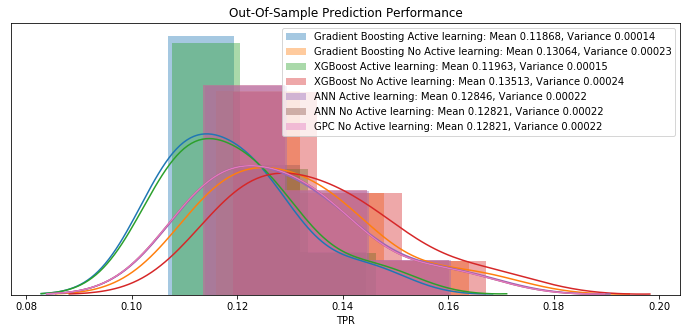

In [46]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.distplot(tpr.iloc[0, :], label = GBAL_label, ax = ax)
sns.distplot(tpr.iloc[1, :], label = GBNAL_label, ax = ax)
sns.distplot(tpr.iloc[2, :], label = XGAL_label, ax = ax)
sns.distplot(tpr.iloc[3, :], label = XGNAL_label, ax = ax)
sns.distplot(tpr.iloc[4, :], label = ANNAL_label, ax = ax)
sns.distplot(tpr.iloc[5, :], label = ANNNAL_label, ax = ax)
sns.distplot(tpr.iloc[6, :], label = GPC_label, ax = ax)

plt.title("Out-Of-Sample Prediction Performance")
plt.xlabel('TPR')
plt.yticks([])

plt.legend()

#fig.savefig("bh_OOS_accuracy_performance.png");

# Average TPR over Monte-Carlo simulations

In [160]:
ave_tpr = tpr.mean(axis = 1)
ave_tpr = pd.DataFrame(ave_tpr)
ave_tpr.reset_index(inplace=True)
ave_tpr.columns = ["model","TPR"]
ave_tpr.head(7)

,model,TPR
0,Gradient Boosting Active learning,0.118676
1,Gradient Boosting No Active learning,0.130643
2,XGBoost Active learning,0.119628
3,XGBoost No Active learning,0.135131
4,ANN Active learning,0.128463
5,ANN NO Active learning,0.128205
6,Benchmark GPC,0.128205


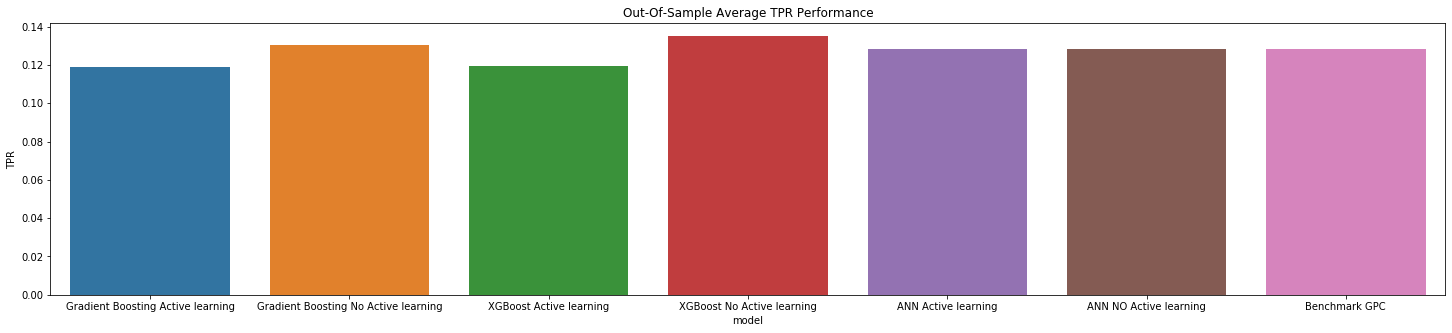

In [161]:
fig, ax = plt.subplots(figsize=(25, 5))

plt.title("Out-Of-Sample Average TPR Performance")
plt.ylabel('TPR')
sns.barplot(x="model", y="TPR", data=ave_tpr)

# The following shows the f1 score of all methods in a number of Monte Carlo simulations

In [49]:
from sklearn.metrics import f1_score

# f1 performance
f1 = np.zeros((num_experiments, montecarlos))
for experiment in range(num_experiments):
    for i in range(montecarlos):
        f1[experiment,i] = f1_score(y_test[i * test_size:(i + 1) * test_size],
                                              y_hat_test[experiment][i * test_size:(i + 1) * test_size])

In [50]:
f1 = pd.DataFrame(f1, index = experiment_labels)
f1.head(7)

,0,1,2,3,4,5,6,7,8,9
Gradient Boosting Active learning,0.759615,0.785714,0.783410,0.852174,0.839506,0.784689,0.794643,0.832714,0.792079,0.835341
Gradient Boosting No Active learning,0.016129,0.000000,0.032520,0.028571,0.043796,0.000000,0.088235,0.012500,0.032520,0.027586
XGBoost Active learning,0.757009,0.774704,0.762712,0.816667,0.812261,0.740741,0.813559,0.800000,0.790698,0.806084
XGBoost No Active learning,0.096386,0.069364,0.047337,0.104651,0.044944,0.088608,0.113636,0.074074,0.133333,0.102041
ANN Active learning,0.133333,0.078125,0.114754,0.096000,0.111888,0.068376,0.158730,0.040816,0.106195,0.113475
ANN NO Active learning,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Benchmark GPC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [51]:
score = f1
GBAL_label, GBNAL_label, XGAL_label, XGNAL_label, ANNAL_label, ANNNAL_label, GPC_label = create_labels(score)

# F1 distribution

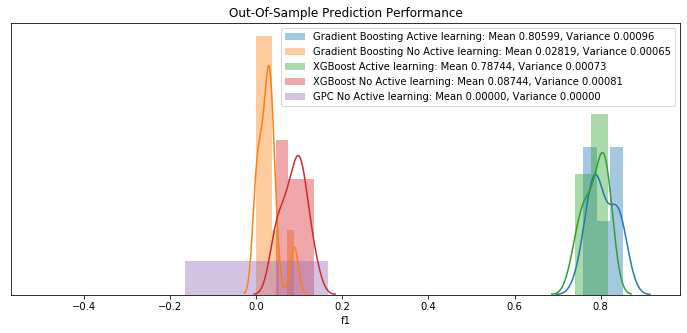

In [52]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.distplot(f1.iloc[0, :], label = GBAL_label, ax = ax)
sns.distplot(f1.iloc[1, :], label = GBNAL_label, ax = ax)
sns.distplot(f1.iloc[2, :], label = XGAL_label, ax = ax)
sns.distplot(f1.iloc[3, :], label = XGNAL_label, ax = ax)
#sns.distplot(f1.iloc[4, :], label = ANNAL_label, ax = ax)
#sns.distplot(f1.iloc[5, :], label = ANNNAL_label, ax = ax)
sns.distplot(f1.iloc[6, :], label = GPC_label, ax = ax)

plt.title("Out-Of-Sample Prediction Performance")
plt.xlabel('f1')
plt.yticks([])

plt.legend()

#fig.savefig("bh_OOS_f1_performance.png");

# Average f1 over Monte-Carlo simulations

In [158]:
ave_f1 = f1.mean(axis = 1)
ave_f1 = pd.DataFrame(ave_f1)
ave_f1.reset_index(inplace=True)
ave_f1.columns = ["model","F1"]
ave_f1.head()

,model,F1
0,Gradient Boosting Active learning,0.805989
1,Gradient Boosting No Active learning,0.028186
2,XGBoost Active learning,0.787443
3,XGBoost No Active learning,0.087437
4,ANN Active learning,0.102169


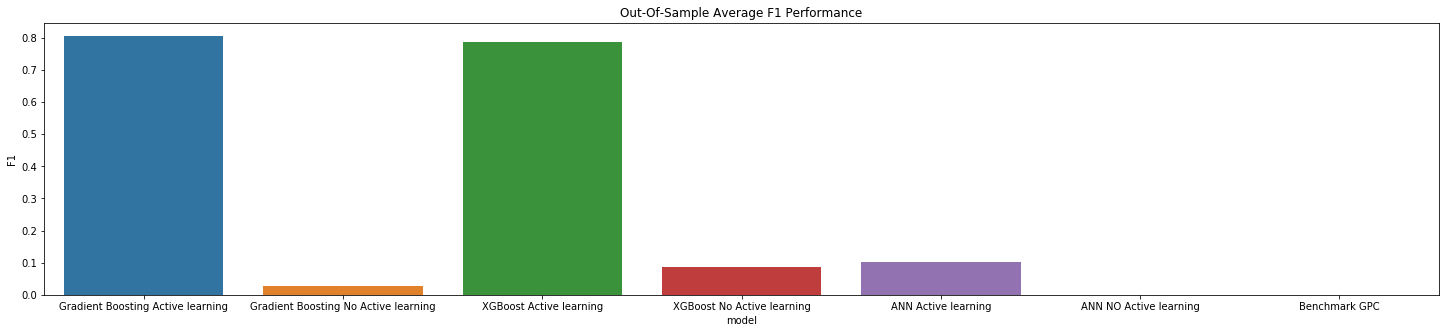

In [159]:
fig, ax = plt.subplots(figsize=(25, 5))

plt.title("Out-Of-Sample Average F1 Performance")
plt.xlabel('f1')
plt.ylabel('F1')
sns.barplot(x="model", y="F1", data=ave_f1)


# Loop through few budgets to have TPR and F1 by budgets

In [55]:
tpr_hist = []
f1_hist = []
tpr_ave_hist = []
f1_ave_hist = []

stride = 500
start = 500
finish = 2500

for budget in range(start,finish,stride):
    # loop denotes which loop are we in
    loop = int((budget - start)/stride)
    
    # Set the ABM Evaluation Budget
    budget = budget
    
    print("We are at loop: {} with budget {}.".format(loop,budget))
    
    # Set initial evaluated set size, batch size and training pool size
    # ini_size = int(budget/2)
    ini_size = 98
    # batch = int(math.log(budget))
    batch = int(budget/50)
    pool_size = budget*batch
    
    # Build X_train_pool
    X_train_pool = get_sobol_samples(n_dimensions, pool_size, bh_exploration_range)

    # Output data as a csv
    pd.DataFrame(X_train_pool).to_csv("budget_" + str(budget) + "_X_train_pool.csv")
    pd.DataFrame(X_test).to_csv("budget_" + str(budget) +"_X_test.csv")
    pd.DataFrame(y_test).to_csv("budget_" + str(budget) +"_y_test.csv")
    
    # Build train data without active learning
    np.random.shuffle(X_train_pool)    # shuffle it first
    default_X_train = X_train_pool[:budget,:]  
    default_y_train = evaluate_bh_on_set(default_X_train, method, threshold)
    
    # Build first X evaluated batch with size ini_size
    np.random.shuffle(X_train_pool)   # shuffle it first
    ini_evaluated_set_X = X_train_pool[:ini_size,:]
    unevaluated_set_X = X_train_pool[ini_size:,:]

    # Evaluate the train set for the ABM response
    ini_evaluated_set_y = evaluate_bh_on_set(ini_evaluated_set_X, method, threshold)
    
    
    # -----
    # experiment 1
    # model: "Gradient boost" + active learning
    model = "Gradient boost"
    gb_X_train, gb_y_train = active_learning(ini_evaluated_set_X, ini_evaluated_set_y, unevaluated_set_X, budget, method, model, threshold, batch)
    pd.DataFrame(gb_X_train).to_csv("budget_" + str(budget) + "_gb_X_train.csv")
    pd.DataFrame(gb_y_train).to_csv("budget_" + str(budget) + "_gb_y_train.csv")
    # model.fit
    gb_active = fit_surrogate_model(model, method, gb_X_train, gb_y_train,batch)    
    gb_active_y_hat_test = gb_active.predict(X_test)
    pd.DataFrame(gb_active_y_hat_test).to_csv("budget_" + str(budget) + "_gb_active_y_hat_test.csv")
    
    # -----
    # experiment 2
    # model: "Gradient boost" + no active learning
    # model.fit
    gb_non_active = fit_surrogate_model(model, method, default_X_train, default_y_train, batch)
    gb_non_active_y_hat_test = gb_non_active.predict(X_test)
    pd.DataFrame(gb_non_active_y_hat_test).to_csv("budget_" + str(budget) + "_gb_non_active_y_hat_test.csv")
    
    # -----
    # experiment 3
    # model: "XGBoost" + active learning
    model = "XGBoost"
    XG_X_train, XG_y_train = active_learning(ini_evaluated_set_X, ini_evaluated_set_y, unevaluated_set_X, 
                                           budget, method, model, threshold, batch)
    pd.DataFrame(XG_X_train).to_csv("budget_" + str(budget) + "_XG_X_train.csv")
    pd.DataFrame(XG_y_train).to_csv("budget_" + str(budget) + "_XG_y_train.csv")
    # model.fit
    XG_active = fit_surrogate_model(model, method, XG_X_train, XG_y_train,batch)    
    XG_active_y_hat_test = XG_active.predict(X_test)
    pd.DataFrame(gb_active_y_hat_test).to_csv("budget_" + str(budget) + "_XG_active_y_hat_test.csv")
    
    # -----
    # experiment 4
    # model: "Gradient boost" + no active learning
    # model.fit
    XG_non_active = fit_surrogate_model(model, method, default_X_train, default_y_train, batch)
    XG_non_active_y_hat_test = XG_non_active.predict(X_test)
    pd.DataFrame(XG_non_active_y_hat_test).to_csv("budget_" + str(budget) + "_XG_non_active_y_hat_test.csv")
    
    # -----
    # experiment 5
    # model: "ANN" + active learning
    model = "ANN"
    ANN_X_train, ANN_y_train = active_learning(ini_evaluated_set_X, ini_evaluated_set_y, unevaluated_set_X, budget, method, model, threshold, batch)
    pd.DataFrame(ANN_X_train).to_csv("budget_" + str(budget) + "_ANN_X_train.csv")
    pd.DataFrame(ANN_y_train).to_csv("budget_" + str(budget) + "_ANN_X_train.csv")
    # model.fit
    ANN_active = fit_surrogate_model(model, method, ANN_X_train, ANN_y_train,batch)    
    ANN_active_y_hat_test = ANN_active.predict_classes(X_test)
    pd.DataFrame(ANN_active_y_hat_test).to_csv("budget_" + str(budget) + "_ANN_active_y_hat_test.csv")
    
    # -----
    # experiment 6
    # model: "ANN" + no active learning
    # model.fit
    ANN_non_active = fit_surrogate_model(model, method, default_X_train, default_y_train, batch)
    ANN_non_active_y_hat_test = ANN_non_active.predict_classes(X_test)
    pd.DataFrame(ANN_non_active_y_hat_test).to_csv("budget_" + str(budget) + "_ANN_non_active_y_hat_test.csv")
    
    # -----
    # experiment 7
    # model: "Gaussian Process Classification" + no active learning
    # model.fit
    gpc_non_active = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(default_X_train, default_y_train)
    gpc_non_active_y_hat_test = gpc_non_active.predict(X_test)
    pd.DataFrame(gpc_non_active_y_hat_test).to_csv("budget_" + str(budget) + "_gpc_non_active_y_hat_test.csv")
    
    '''
    print(gb_active_y_hat_test.shape)
    print(gb_non_active_y_hat_test.shape)
    print(ANN_active_y_hat_test.shape)
    print(ANN_non_active_y_hat_test.shape)
    print(gpc_non_active_y_hat_test.shape)
    '''
    
    # Gather all y hat
    y_hat_test = np.stack((gb_active_y_hat_test, gb_non_active_y_hat_test,
                        XG_active_y_hat_test, XG_non_active_y_hat_test,
                        ANN_active_y_hat_test, ANN_non_active_y_hat_test,
                       gpc_non_active_y_hat_test),axis = 0)
        
    # tpr performance
    current_tpr = np.zeros((num_experiments, montecarlos))
    for experiment in range(num_experiments):
        for i in range(montecarlos):
            current_tpr[experiment,i] = custom_metric_binary(y_test[i * test_size:(i + 1) * test_size],
                                              y_hat_test[experiment][i * test_size:(i + 1) * test_size])
    tpr_hist.append(current_tpr)
    
    # f1 performance
    current_f1 = np.zeros((num_experiments, montecarlos))
    for experiment in range(num_experiments):
        for i in range(montecarlos):
            current_f1[experiment,i] = f1_score(y_test[i * test_size:(i + 1) * test_size],
                                                  y_hat_test[experiment][i * test_size:(i + 1) * test_size])
    f1_hist.append(current_f1)
    
    current_ave_tpr = current_tpr.mean(axis = 1)
    tpr_ave_hist.append(current_ave_tpr)
    current_ave_f1 = current_f1.mean(axis = 1)
    f1_ave_hist.append(current_ave_f1)

# to include the first run (outside of the loop) results
tpr_hist.append(tpr.values)
f1_hist.append(f1.values)
tpr_ave_hist.append(ave_tpr)
f1_ave_hist.append(ave_f1)

We are at loop: 0 with budget 500.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 402 parameter unevaluated within budget.
Surrogate model predicted 362 positive labels out of 4902: 
Parameters bundles of indices:  [1601  192 3098 1959 1396 2978 1584 1056  849 2202]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 392 parameter unevaluated within budget.
Surrogate model predicted 242 positive labels out of 4902: 
Parameters bundles of indices:  [2145 2991  720 1538 2144 1481 2439 1499 3084 3985]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 382 parameter unevaluated within budget.
Surrogate model predicted 237 positive labels out of 4902: 
Parameters bundles of indices:  [3393 3098 2145 2289 2600 4659 2575 3684  965 4287]  are randomly selected from po

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 483 positive labels out of 4902: 
Parameters bundles of indices:  [2536 1432 4208  976 1868 4572 1948 4752 2038 2376]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 352 parameter unevaluated within budget.
Surrogate model predicted 349 positive labels out of 4902: 
Parameters bundles of indices:  [ 121  745 3898  642 4203 2646 2669 1698 1370 3529]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 342 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 268 positive labels out of 4902: 
Parameters bundles of indices:  [1791 4711 1510 1645 3209 2862 4204 1266  343  196]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 332 parameter unevaluated within budget.
Surrogate model predicted 321 positive labels out of 4902: 
Parameters bundles of indices:  [2837 4040  289 1161 3315 1140 3796 3607 2633 2402]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 322 parameter unevaluated within budget.
Surrogate model predicted 269 positive labels out of 4902: 
Parameters bundles of indices:  [4608 3989 1428 3351 3311 2063 3387 3358  325  190]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
----------------------------------------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 309 positive labels out of 4902: 
Parameters bundles of indices:  [2633 3747 1373 3598 2057 4060 4531  203 3595 1641]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 302 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 287 positive labels out of 4902: 
Parameters bundles of indices:  [1140 3156 1641 3618 3268  883 1948 4177  343  488]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 292 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 243 positive labels out of 4902: 
Parameters bundles of indices:  [2252 3031  790 1567 2221 1481 2536 1503 3098 4691]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 282 parameter unevaluated within budget.
Surrogate model predicted 283 positive labels out of 4902: 
Parameters bundles of indices:  [2055 1188 1641 3415 4531 3774 3596 4421  293  457]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 272 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 331 positive labels out of 4902: 
Parameters bundles of indices:  [ 862 1130 1894  914  813 2075  849  916 3750 4439]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 262 parameter unevaluated within budget.
Surrogate model predicted 294 positive labels out of 4902: 
Parameters bundles of indices:  [3444 3387  830 3728  462 3920 2987 3165 1005 1266]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 252 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 319 positive labels out of 4902: 
Parameters bundles of indices:  [4752 4046  293 1005 3180  976 3607 2376 2486 2987]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 242 parameter unevaluated within budget.
Surrogate model predicted 295 positive labels out of 4902: 
Parameters bundles of indices:  [3831 3775  242 3416 4410  795 3920  914 3390 1031]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 232 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 295 positive labels out of 4902: 
Parameters bundles of indices:  [3741 3697  242 3393 4287  813 3894  965 3387 1105]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 222 parameter unevaluated within budget.
Surrogate model predicted 321 positive labels out of 4902: 
Parameters bundles of indices:  [2729 3920  301 1031 3195 1005 3664 3387 2575 2340]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 212 parameter unevaluated within budget.
Surrogate model predicted 322 positive labels out of 4902: 
Parameters bundles of indices:  [3491 2298 4654  987 1490 4377 4657 4439 1298 2978]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
----------------------------------------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 355 positive labels out of 4902: 
Parameters bundles of indices:  [  80 1932 4184 2978 1365 3094 1615  883  563 4105]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 92 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 360 positive labels out of 4902: 
Parameters bundles of indices:  [  80 3031 1481 2963 1350 1618 3129  852  558 1658]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 82 parameter unevaluated within budget.
Surrogate model predicted 360 positive labels out of 4902: 
Parameters bundles of indices:  [  97 2993 1507 2925 1367 1645 3095  902  558 1658]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 72 parameter unevaluated within budget.
Surrogate model predicted 379 positive labels out of 4902: 
Parameters bundles of indices:  [1932 3997 3607 3496 2832 1184 4682  951 2252  717]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
------------------------------------------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 371 positive labels out of 4902: 
Parameters bundles of indices:  [1942 1948 4184  883 4030 1981  515 2115 1140 2993]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 52 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 367 positive labels out of 4902: 
Parameters bundles of indices:  [1481 3366  705  456 1188 4654 1359 4184 3131   80]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 42 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 384 positive labels out of 4902: 
Parameters bundles of indices:  [2691 1650 2376  790 3180 4195 3980 2195 3596 3853]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 32 parameter unevaluated within budget.
Surrogate model predicted 374 positive labels out of 4902: 
Parameters bundles of indices:  [1658 3925 4162 2742 2686 1420 3268 1942 1130  790]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 22 parameter unevaluated within budget.
Surrogate model predicted 386 positive labels out of 4902: 
Parameters bundles of indices:  [3276 4140 1893  790 2686 3903 3997 1878 4086  914]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
------------------------------------------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 378 positive labels out of 4902: 
Parameters bundles of indices:  [4751 2044 4177 3596 2984 1184 4454  951 1693  696]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 2 parameter unevaluated within budget.
Surrogate model predicted 405 positive labels out of 4902: 
Parameters bundles of indices:  [4864 2980]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 402 parameter unevaluated within budget.
Surrogate model predicted 546 positive labels out of 4902: 
Parameters bundles of indices:  [ 786 4040  902 1698 1326  309 4178  844 4561 1650]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 392 parameter u

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 363 positive labels out of 4902: 
Parameters bundles of indices:  [1602  192 4847 1965 1448 4040 1593 1130  883 2271]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 382 parameter unevaluated within budget.
Surrogate model predicted 418 positive labels out of 4902: 
Parameters bundles of indices:  [4377 2099 2837 4364 3853 3831 1888  149  260 3209]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 372 parameter unevaluated within budget.
Surrogate model predicted 471 positive labels out of 4902: 
Parameters bundles of indices:  [1071  814  289 1412 3805 3113 2709 4454 3989  948]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
----------------------------------------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 424 positive labels out of 4902: 
Parameters bundles of indices:  [1819  299 4861  161 1266 3031 4505 1338 2180 4010]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 342 parameter unevaluated within budget.
Surrogate model predicted 471 positive labels out of 4902: 
Parameters bundles of indices:  [1359  943  308 1593 3898 3222 2946 4522 4063 1161]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 332 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 396 positive labels out of 4902: 
Parameters bundles of indices:  [3091 1602 3095  965 1807 1499 4717 1776 1188  558]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 322 parameter unevaluated within budget.
Surrogate model predicted 313 positive labels out of 4902: 
Parameters bundles of indices:  [1233 4046 3311 2601 1894 2529 2252 1991 1370 4177]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 312 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 308 positive labels out of 4902: 
Parameters bundles of indices:  [1266 3976 4654 2145 3089 2467 4711 1321  464 1326]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 302 parameter unevaluated within budget.
Surrogate model predicted 296 positive labels out of 4902: 
Parameters bundles of indices:  [3903 3898  242 3658 4522  838 3997 1106 3618 1365]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 292 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 374 positive labels out of 4902: 
Parameters bundles of indices:  [1781 3974 4195 2862 2773 1507 3351 2063 1245  749]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 282 parameter unevaluated within budget.
Surrogate model predicted 1107 positive labels out of 4902: 
Parameters bundles of indices:  [4267 4177 2195 3684 2109 1420 3774 3515 4856 4030]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 272 parameter unevaluated within budget.
Surrogate model predicted 829 positive labels out of 4902: 
Parameters bundles of indices:  [4890  705   35 1649 3853 2182 1830 3985 3166 1960]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
---------------------------------------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 803 positive labels out of 4902: 
Parameters bundles of indices:  [1807  997 4647 2043 3914  902 2394 1958 4711 2686]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 252 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 750 positive labels out of 4902: 
Parameters bundles of indices:  [3209  786 1847  241 3701 3604 4689  132 3164 1255]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 242 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1032 positive labels out of 4902: 
Parameters bundles of indices:  [3148 4529 3977 1329 2144 4622 2417 1460 3219 2446]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 232 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 357 positive labels out of 4902: 
Parameters bundles of indices:  [2298 2851 1244 1942 3568 1789 1359 2263 3349 2660]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 222 parameter unevaluated within budget.
Surrogate model predicted 489 positive labels out of 4902: 
Parameters bundles of indices:  [4187 1449 2180 2592  951 4704 3755  296 4819 4616]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 212 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 405 positive labels out of 4902: 
Parameters bundles of indices:  [4847 2959  786 2837 1691 3775 3684 3260 3868 1350]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 202 parameter unevaluated within budget.
Surrogate model predicted 572 positive labels out of 4902: 
Parameters bundles of indices:  [2075 2298 2812 3391 1603 1341 3282 3209 3297 1928]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 192 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 512 positive labels out of 4902: 
Parameters bundles of indices:  [ 490 4663 2126 2536 1412 3209 3985 3902 4604 4522]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 182 parameter unevaluated within budget.
Surrogate model predicted 516 positive labels out of 4902: 
Parameters bundles of indices:  [ 883 4080 1760 3903 2984 3684 1445  168 3402 2758]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 172 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 506 positive labels out of 4902: 
Parameters bundles of indices:  [3180 3536 2145 3920  742  192 4717 3276 3011  965]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 162 parameter unevaluated within budget.
Surrogate model predicted 535 positive labels out of 4902: 
Parameters bundles of indices:  [1567 4238 1803 3804 4864 1957 4439 2144 3878 1491]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 152 parameter unevaluated within budget.
Surrogate model predicted 531 positive labels out of 4902: 
Parameters bundles of indices:  [3892 4067 2580 1934 4204 2691 2663  192 3515 2115]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
----------------------------------------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 444 positive labels out of 4902: 
Parameters bundles of indices:  [4603 1175 1428 4663  325 3893 1491 2686 2789 2633]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 72 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 604 positive labels out of 4902: 
Parameters bundles of indices:  [4643  490 4322 2930  501  568 2959 2607 1770 3351]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 62 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 528 positive labels out of 4902: 
Parameters bundles of indices:  [4177  457 3893  778 3165 1593 4400 4664  149 4530]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 52 parameter unevaluated within budget.
Surrogate model predicted 501 positive labels out of 4902: 
Parameters bundles of indices:  [1029 2669 2963 4438 3366  196 4060 2930 1689 1618]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 42 parameter unevaluated within budget.
Surrogate model predicted 492 positive labels out of 4902: 
Parameters bundles of indices:  [3658  951 3225 1432  196 4639 1408 4586  293 4377]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
------------------------------------------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 536 positive labels out of 4902: 
Parameters bundles of indices:  [1669 4281 1904 3863 4864 1981 4818 2182 2987 1569]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 2 parameter unevaluated within budget.
Surrogate model predicted 535 positive labels out of 4902: 
Parameters bundles of indices:  [3271 4847]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 402 parameter unevaluated within budget.
Surrogate model predicted 409 positive labels out of 4902: 
Parameters bundles of indices:  [1322 2911 3274 4006  367 3496 3042 4761 4621 2170]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 392 parameter u

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4902: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 954 1693 2489 3078 3583 4358 4849 3246 4143 3811]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 382 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 4892: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [1069  208 2908 2635 1970 4669  399 4657  164 2625]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 372 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4882: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [3377 3803 2400 2970 1040 2331  553 1567 1387 2177]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 362 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 4872: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [3059 1130 2513 1165 3506 1464 2420 4366 4811 4664]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 352 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4862: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [4608 1390 1178 2824 1234 2276 4063 1108 2054 2951]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 342 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 4852: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [1257  701 1784 3805 2887  881 1125 4380 1921 4141]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 332 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4842: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [3237 4336  474 2571 4640 1340 1354 2278 4585 3878]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 322 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4832: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [2254   70 3370 4149 1178 1492 2396  333  417 2018]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 312 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4822: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [1395 3387 3726 1106 4125 2367 1123 4662 4446 3448]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 302 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 4812: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [3166 3980 3170 3650 2371  982 3899 2726  668 3875]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 292 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 4802: 


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 282 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 4792: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [3975 3580  742 2284 4488 4468   42 3603   29 4717]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 272 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 4782: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [4389 2164 2205  775 3175  804 1477 3335 1459 2876]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 262 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 4772: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [4413 2616  783 2663 4574 3965 1618 3544 3267 3567]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 252 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 4762: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [3815 2913 3657   15 2045 2823 4648 1741 4621 2457]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
T

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4712: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [1198 2483 3865 3808 3030  196  734 3966 3829 3137]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 192 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 4702: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [1120 1243  359  524 1968 2526 4223 3303 4658 2786]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 182 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 4692: 


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4672: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [1083 1645 3667 4380 3679   34 3784 2976 3736 2672]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 152 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 4662: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 682 1420 2873 1529 2878 3863  636 2904 3087 4071]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 142 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 4652: 


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4642: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [2181 3086 4432  981 1326 2080 3647 3806 3799 1509]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 122 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 4632: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [  23  293 4252 1171 3585 3045  526 3681  967 3218]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 112 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4622: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 370  477 3059 2787 3405 4155 2380 1618 2407  806]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 102 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4612: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [3105  983 2722 1274  102 3158 2074 3333  261 2447]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 92 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 4602: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [1916 4456 3970 3955 1687 4387 3442 1623 4084   19]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 82 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 4592: 
Pa

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4582: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [1216 4113 3580 2515 2504  742 1512  952 1917 2602]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 62 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4572: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [1699 1090  867 4393 2046 3093 1702 2595 2280 2795]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 52 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4562: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [2995 2595 1502 3057 3119  982 1798 1846 4014 2966]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 42 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4552: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [4003 2958 3179  787 4494 1390 2299  494 1118  757]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 32 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 4542: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [1071 3151  714 3984 2024 2161  924 2793 4473 2675]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 22 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 4532: 
Pa

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4512: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [1531 3413]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
We are at loop: 1 with budget 1000.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 902 parameter unevaluated within budget.
Surrogate model predicted 975 positive labels out of 19902: 
Parameters bundles of indices:  [16550  2591 15437  6109 12525 17136  7498  5808 15770  8361 19524 11770
   278 16767  4406 13380  7191  8639  6074  8233]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 882 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1610 positive labels out of 19902: 
Parameters bundles of indices:  [16384 16107 14484 11898 14342 19049  1845  1554 16345 11199 10349 17096
 14476 16454 14001 10044  5623  8057 11763 19670]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 862 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1908 positive labels out of 19902: 
Parameters bundles of indices:  [17513 12150 11007  3158 18331  2007   695  9278  6217  2665  5616 11412
 17905 16766 12816  2563 19586 19257 17647 15536]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 842 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1928 positive labels out of 19902: 
Parameters bundles of indices:  [ 7187 15335  1552 16883 10661 10434 18058  8413 19213  7119 10802 13153
 16530  4234  5471 11625  2344  4110 10574 12630]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 822 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1811 positive labels out of 19902: 
Parameters bundles of indices:  [19822 13963 10078  1151 16813  7527  7047  4017 16178   164  8271  7342
 16639 11710 13770 14546 12531  4727  7924  1575]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 802 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1754 positive labels out of 19902: 
Parameters bundles of indices:  [13071  7326  4542  6167 15077 14587 16783 11013 18961 19890  1575  2739
 18402  1740  2593  5367  8257  9309  1816  1403]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 782 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1937 positive labels out of 19902: 
Parameters bundles of indices:  [ 3063  3869  9808 16183  2665  2244 18020 10691  4739  2475   406   606
 11048 16184 13800  1575  9157  8964 19411 17263]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 762 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1851 positive labels out of 19902: 
Parameters bundles of indices:  [17444 12846 18838 16184   147  3877 11183 10448   926  2007 15335 13574
 10684  9818 14728  1166 16624  6442 15024  1313]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 742 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1899 positive labels out of 19902: 
Parameters bundles of indices:  [ 8422  6925 13943   853 14873  4134 14601 16363 16107  1970 11570  7997
  7413 17444  2848  4241  6052  1714  6850  2678]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 722 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2039 positive labels out of 19902: 
Parameters bundles of indices:  [ 8739  5560 13506 10725  1290   286 19871  8116 16324  1182 18455 18278
  9005  6898 14274 17492 15553  7498 10501  3883]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 702 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1960 positive labels out of 19902: 
Parameters bundles of indices:  [ 7433  9492  5759 18806   351  1956  5536  2134 18025  3876 15555  8303
 12077 17752  5345 13932 11706 13968  6969  3025]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 682 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2136 positive labels out of 19902: 
Parameters bundles of indices:  [ 7386 16419 17780 19525 15029  4773  8308 13331  4440  6369 15779 13766
 11926 14484 18280  5523  8454  1841  4828 16718]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 662 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2251 positive labels out of 19902: 
Parameters bundles of indices:  [ 9076  3972  9996  7314 10220 19180 11957 13043  6282 11457  1079 10756
  6963  8338  9615 16737 17479  7802  5243 11701]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 642 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2133 positive labels out of 19902: 
Parameters bundles of indices:  [ 6242  5402   295 11502  6445  5495  6120 15567  1894   930 14051  8792
 15354  4367  4363  2787  7794  8315  8976 16940]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 622 parameter unevaluated within budget.
Surrogate model predicted 2280 positive labels out of 19902: 
Parameters bundles of indices:  [14417 13052 16337  1181 17214   494 19407  1227 13034  5052  3107  8777
  2929  6037  1894  6242  1606 12864 19180 10470]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 602 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2151 positive labels out of 19902: 
Parameters bundles of indices:  [14601  9086 19839 10232  1015  9324 12815  9042  7974  1970  5382  4353
  6655 10443   494 17640 19191  9540  5773  2359]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 582 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2922 positive labels out of 19902: 
Parameters bundles of indices:  [17752  4958  4072  6759 15370  7813 12023 16766  8134    68  9798  6656
  4429  3865 17946 16500  4094  5387  3241 16923]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 562 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2117 positive labels out of 19902: 
Parameters bundles of indices:  [ 9343  9592 16140  8576 18589 15808  1254 13998 17292  4624 14902  2859
 14968  3567  2156  6469 18373  8364 16363 12199]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 542 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2068 positive labels out of 19902: 
Parameters bundles of indices:  [ 5674 11356  6717  8544 16126  2020  8539 17126  1191 14813  2386  7757
 12763  7468  7426 13619 12715 10677 15499  6080]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 522 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2106 positive labels out of 19902: 
Parameters bundles of indices:  [12715 15759 10199 15077 12364 19035 13142 11622 13754 15273  9702 18054
 12268   494 12825 10036 13046 10661 10294  9358]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 502 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2167 positive labels out of 19902: 
Parameters bundles of indices:  [12342  5622  4159   481  4753  3862 10325  9695  2257  6854  2806 13526
   641  1193 13336  1918  9168  7941 15713 18563]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 482 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2228 positive labels out of 19902: 
Parameters bundles of indices:  [ 9952 17777  1193  6732 18964  4206  8590 12191 19686 14621 10394 13518
  2266 19697  8266  5024 18293   275 12351  4909]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 462 parameter unevaluated within budget.
Surrogate model predicted 2252 positive labels out of 19902: 
Parameters bundles of indices:  [ 8875  3755  9802  7011 10066 19177 11751 13001  6024 11320   980 10581
  6698  8111  9462 16615 17443  7549  4791 11583]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 442 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2281 positive labels out of 19902: 
Parameters bundles of indices:  [14528 13153 16350  1180 17224   486 19379  1203 12988  5082  3128  8745
  2952  6058  1854  6261  1574 13119 19310 10389]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 422 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2319 positive labels out of 19902: 
Parameters bundles of indices:  [18479  4665  6543 11042  4723 12817  9032 12458 18331 17904   980 10714
  9054 15141  5340  5667  4410  8420  7396   432]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 402 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2252 positive labels out of 19902: 
Parameters bundles of indices:  [15240 17775 17536 14336 11462 17634  7993  5260  6442 18841  3792  2255
   104  4153  5750 13957 14959 11350 16723  6389]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 382 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2127 positive labels out of 19902: 
Parameters bundles of indices:  [ 5343 15199  8239   883 12671  5395  2859 15810  4402 15420  1475 16345
 10349   321 11537 18314  4098 18635  4666 14063]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 362 parameter unevaluated within budget.
Surrogate model predicted 2199 positive labels out of 19902: 
Parameters bundles of indices:  [10156  4121 11267  2242 15134   494 15647 18598  6925 16507  3553 13609
 13336 11342 19177 19418 17006  3854 19007  3571]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 342 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2261 positive labels out of 19902: 
Parameters bundles of indices:  [ 9952 10993  8162   667 11659 16591  5463 13979 17940  2134  4318  6148
  4465 11737  1458  7835  6568  8400  1166 19697]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 322 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2313 positive labels out of 19902: 
Parameters bundles of indices:  [18520  4666  6563 11042  4723 13754  9032  9198 18374 11281  1009  8926
  9069 14528  5303  5622  4434  8415  7420   481]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 302 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2295 positive labels out of 19902: 
Parameters bundles of indices:  [16822  4311   687  8266 17253 10389  2160  3272   489  4292  8262  6914
  2389 17491 10954  7034  4007 18247  1148  6600]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 282 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2255 positive labels out of 19902: 
Parameters bundles of indices:  [ 3599 16493 15096  7489  3354  4849 14111  1572  2551  9632  6221  6476
 11641 12825 14093 11494  8108  8805  7413 18820]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 262 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2285 positive labels out of 19902: 
Parameters bundles of indices:  [ 2334  8415 17655  1113  4985   474  3015  6323 10252 10857 10488  8662
 14187 12852  8727 13066  4753 11081 17705 18130]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 242 parameter unevaluated within budget.
Surrogate model predicted 2210 positive labels out of 19902: 
Parameters bundles of indices:  [ 5799  7050 13754  3541 10252  5702 12476  4238  5303  1155 16726 15582
   351  8805 10488  8116  5667  6916 12598  1050]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 222 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2242 positive labels out of 19902: 
Parameters bundles of indices:  [ 5736  3796 18493  2419 15940  6871 10294   573   362  8239  9565  8369
  4933  7034 14718   110 17962  5506 19752 14851]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 202 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2226 positive labels out of 19902: 
Parameters bundles of indices:  [ 9921 18146 15998  4782 12936 16280 19622 15434  2451 17007 19832 10504
  7679  6457  4092 17816 15199   296  4437  8599]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 182 parameter unevaluated within budget.
Surrogate model predicted 2218 positive labels out of 19902: 
Parameters bundles of indices:  [12759   705 14107  6708   279  5112 19871 11216  9025  8176  5356  6643
 17593  3106  6363 15538  7243  5671  4092  4510]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 162 parameter unevaluated within budget.
Surrogate model predicted 2221 positive labels out of 19902: 
Parameters bundles of indices:  [19094   695 10932  4889   287  4849 14187 13942

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2250 positive labels out of 19902: 
Parameters bundles of indices:  [ 3523  8745  9082 13641  1010  7141 11348  9689 15319 19177  1998  3960
    97 14935  5310  7187  5380 18613  9357  8979]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 122 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2230 positive labels out of 19902: 
Parameters bundles of indices:  [ 1018  5701   278 11986  3096  2113  3328   684 19839  7574 14336  6998
 11931 14870  9759  4393 11507 13373  8551  4834]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 102 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2212 positive labels out of 19902: 
Parameters bundles of indices:  [ 5694  6969 13740  3455 13526  5597 11508  4098  5011  1179 11535 15902
   354  9206 11111  7278  5570  6850 10352  1057]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 82 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2264 positive labels out of 19902: 
Parameters bundles of indices:  [10007 11065  8134   695 11709 16527  5415 13998 17886  2145  4277  6120
  4395 11795  1492  7807  6529  8385  1178 19686]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 62 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2234 positive labels out of 19902: 
Parameters bundles of indices:  [ 1057 18156   287 18201  8750  2145 14596   698  3305 19027  8811  3373
 19148 13563 13924 18826  7433 15233  8500 12458]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 42 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2253 positive labels out of 19902: 
Parameters bundles of indices:  [15883  5736  4786 11514 13029  6852 13964  8786  7649  2021 17277  4387
 19597 10249 12268  5612 13852 13984  7242  2712]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 22 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2215 positive labels out of 19902: 
Parameters bundles of indices:  [19850   695  8391 17554   296  4849 12860  3096  4541  2331  6529  6469
  6328  4207 11502 12737 19343 14559 17986 13386]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 2 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2247 positive labels out of 19902: 
Parameters bundles of indices:  [13468 11042]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 902 parameter unevaluated within budget.
Surrogate model predicted 2747 positive labels out of 19902: 
Parameters bundles of indices:  [17477 11143 17354 19460  7997  8598  6921  1341 15146 12691 11957  9753
 10026 14335  4206  8490 15769  6813  9932  1546]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 882 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2089 positive labels out of 19902: 
Parameters bundles of indices:  [  356  7913  3451  9426  2221 19062  5703 15017  8470  1341  1214 15660
  8739 16408  9329 18493  1554  4646 14601 14078]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 862 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2055 positive labels out of 19902: 
Parameters bundles of indices:  [ 8413 17914  6282 10527 15960 13965 16356 15069 17455  7580  1478  1788
  9381  8079  7529 10515 17780  1447  9889  5010]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 842 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1836 positive labels out of 19902: 
Parameters bundles of indices:  [ 9720 16019 10944  2244  5380  2122 14085  8916  5924 17829  2475  1714
  9621 10224 16779 16464  8729  1155 15030  4208]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 822 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1715 positive labels out of 19902: 
Parameters bundles of indices:  [12484   122  8487 15287  5473 16720  9105  9320  6665 15726   525 15780
  5367 13500  9737  2102   980  5671   606 16138]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 802 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1844 positive labels out of 19902: 
Parameters bundles of indices:  [13066  2390  3354  5473  7265   184  2362  5314 19670 11314 11833 16183
  7569 12988 10286 17421 14458 12014  2841   113]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 782 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1606 positive labels out of 19902: 
Parameters bundles of indices:  [11264  8362   999  3650  4331 16801 14075  9952  9052 12877  2242  7943
  9632 19583  2010   947  5809 18931 16935 11819]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 762 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1664 positive labels out of 19902: 
Parameters bundles of indices:  [ 8488   567   644  4646 12537  8875 15759  1033  6916 12576  6250   114
  8500 11701  1311 12670 12889  1197  9206  3465]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 742 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1799 positive labels out of 19902: 
Parameters bundles of indices:  [ 6270  8738 12593  4828 19122 12157 18976  2010  9324 19216  6700 15410
 16247 10010 18373   114  2841 12988  5094  9146]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 722 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1526 positive labels out of 19902: 
Parameters bundles of indices:  [17782  6476   126  4970  6024 18071  7801  2015  6543 13459 11189 15960
 14063  5701 15924  8966  3843 11348   406   654]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 702 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1624 positive labels out of 19902: 
Parameters bundles of indices:  [12936   942 10756  8362  3101  2141  3536 10279 10829 15428  9126 17306
 15076    87  2561  1894 14063  5380 12743  8490]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 682 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1879 positive labels out of 19902: 
Parameters bundles of indices:  [ 9828  1263  2204 14957 12598  7646 12880 18453 14269 16419  4575   175
  2653 14493  1122 13785  4556  9720  7434 15838]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 662 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2223 positive labels out of 19902: 
Parameters bundles of indices:  [14073   708 11111  4828   286  4792 19310 17466 13216  9747 17782  6578
  6175  6744 13641  9592  9572 11991 13140  5594]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 642 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2336 positive labels out of 19902: 
Parameters bundles of indices:  [ 6563 10485 10606 19834 14855 10349 13557 12891  9329  1151 14341 11221
  5354  4292 16423  1050  7234 15527 11207  1113]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 622 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1806 positive labels out of 19902: 
Parameters bundles of indices:  [18910  7483  2086 16350  3476 18146  1381  5581  6890  7376   695 15044
  6771 15950  4393    97 18421 10020 18688  9778]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 602 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2170 positive labels out of 19902: 
Parameters bundles of indices:  [ 1713  3433  3954 16841 19864 14637  5303 19278 12572  7968  5799 12845
  5477 19015 15065  1113  5750   858  6532  6991]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 582 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2372 positive labels out of 19902: 
Parameters bundles of indices:  [ 7087 18493   202  3174 10042 10993 10231  9616 19177 14865 14013 18644
 11136 13041  2172 12897 16720 13098  2266  6072]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 562 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1833 positive labels out of 19902: 
Parameters bundles of indices:  [ 1348  5759  2359  9203 16319 12237  5966   633  3158 10224 10849  3876
  5303  1696 14460 17378 17942  4292  4837  3226]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 542 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2436 positive labels out of 19902: 
Parameters bundles of indices:  [14380 17756  7016 17442   988  4087  2390 17440 14957  9390 18579 18053
  6217 13969  1696  7968 12043  5130  5915  3305]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 522 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1855 positive labels out of 19902: 
Parameters bundles of indices:  [ 7244  6560  8338 16260   132  5736 15499 10294   705  1707  4156 19550
 10562 15354 10220   937  7500 13616 15187  1105]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 502 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2280 positive labels out of 19902: 
Parameters bundles of indices:  [14559 13119 16423  1115 17440   494 19430  1182 13090  4742  3019  8632
  2779  5864  1799  6039  1538 12915 19228 10229]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 482 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2157 positive labels out of 19902: 
Parameters bundles of indices:  [ 5703 12082  2028  4017  4953 16184  5966  9285  4131   813 13140 13325
  4566   570 19266  3455  2174  4985  4933  3536]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 462 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1950 positive labels out of 19902: 
Parameters bundles of indices:  [  144 15527 16337  1841  3247  1213 11641 12864 15112  4208  5773 11706
   589 18525 18058 16841  2779  5472 18944  8149]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 442 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2178 positive labels out of 19902: 
Parameters bundles of indices:  [19797  4706  1057  5955  3094  5032 14790 11348  5935 13693 12870  2112
 12154  9979 19120  4481   780 12292  5395  8926]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 422 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2242 positive labels out of 19902: 
Parameters bundles of indices:  [ 5736  3741 18493  2390 16178  6969 10534   606   420  8423  9764  8558
  4928  7134 14942   114 18029  5456 19730 15044]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 402 parameter unevaluated within budget.
Surrogate model predicted 1924 positive labels out of 19902: 
Parameters bundles of indices:  [ 6175  8111  6623  7376 13033  2910  1501  8209  1752  2145  9818 14362
 17444   606  7752 18620 11143 11227 15713 17930]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 382 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1968 positive labels out of 19902: 
Parameters bundles of indices:  [  147  7577  3215 12720  5597  2554 19149 12726 18313 15371 19002 12436
  3296 11535 11042  4567 13616 19797  2933 18695]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 362 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2352 positive labels out of 19902: 
Parameters bundles of indices:  [ 4510  8807 14959  5806  8271 12560 18676 10101 15582   589  2086 11102
  3532 11624  7134 18767 19776 18563 14063 13800]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 342 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2179 positive labels out of 19902: 
Parameters bundles of indices:  [ 8079 19177  1057  5955  3024  8983 10009 11625 19622  3226  9592  2055
 16488  7904 13506 10252   787 13029  8490  8745]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 322 parameter unevaluated within budget.
Surrogate model predicted 2281 positive labels out of 19902: 
Parameters bundles of indices:  [14406 13066 16292  1203 17209   499 19388  1268 12862  4708  3025  8590
  2787  5749  1887  5945  1606 13034 19343 10197]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 302 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2527 positive labels out of 19902: 
Parameters bundles of indices:  [ 9069 17224 17881  8412 19583 18080  8012  5377 14497  2389  6568 13336
  1537  5772 10534 15037   573  1610 15582 18852]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 282 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2437 positive labels out of 19902: 
Parameters bundles of indices:  [ 4525  4292 13088  2141  9005 18212  7062 12864  2185  9048 15511  6668
 17531  8100  9313 14118 14092 17940 10046  1683]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 262 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2390 positive labels out of 19902: 
Parameters bundles of indices:  [16157  3393 12255 12138 17851 15349  9054   471  6462  8784  8775 11502
 17946 12593  7065 12825  3466 16237  3786 16419]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 242 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2318 positive labels out of 19902: 
Parameters bundles of indices:  [ 7821 12671 12939 19213 10903 18902 17000  6373  6755 12252 13068  2255
  7328  9278  9067  2571  7331 19027 18287  9772]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 222 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2497 positive labels out of 19902: 
Parameters bundles of indices:  [10172 19279 11508  8317  7342 17149 10954  8391 10264 10914   313 13500
 17930 16294 11267 16808  6369 16521  5373  8463]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 202 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2373 positive labels out of 19902: 
Parameters bundles of indices:  [ 6902  3743  1683  6331  4153 12351  6217 11471  4387  6962  3869 19165
  9620 14073  8959   942  3086 13783  5312  6969]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 182 parameter unevaluated within budget.
Surrogate model predicted 2300 positive labels out of 19902: 
Parameters bundles of indices:  [ 7941 15619 15120  1970  9343   482 16765  3541 12269  6813  8776 10967
   347   684  4153  8581  4889 11920 17254  8108]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 162 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2004 positive labels out of 19902: 
Parameters bundles of indices:  [ 8712  2801  6655  2302 17002   132 14852  1341  3174  1204 17325   570
 19148  1151 13216 17444  2712  9519 16954  3246]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 142 parameter unevaluated within budget.
Surrogate model predicted 2299 positive labels out of 19902: 
Parameters bundles of indices:  [ 5373 13776   641  7835 18563 17554 17594  7473   489 16384  1365  4437
  1983 15134 13842  1987 11926 15096 12688 18573]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 122 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2374 positive labels out of 19902: 
Parameters bundles of indices:  [14406 11685  8410   564 19132 16322  6369 10190 11329  7217 17752 19334
  8551 12900 14166 18728 17292  9932 10212  6466]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 102 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2604 positive labels out of 19902: 
Parameters bundles of indices:  [17655 18374  1179 18789  6529  7904 16883 18020  9424 14919  7038 14871
 18658  6229  6634 12909  5724 17942  5402   287]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 82 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2386 positive labels out of 19902: 
Parameters bundles of indices:  [15335 10922 12136 19051  8685 11417   354  7100  4542 19723  3541  8805
  3158 10547 15600  7113  9040  7336  3896 10224]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 62 parameter unevaluated within budget.
Surrogate model predicted 2262 positive labels out of 19902: 
Parameters bundles of indices:  [ 9695 10686  7943   606 11462 17545  5224 13915 17948  2010  4093  5916
  4222 11531  1375  7624  6334  8124  1113 19686]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 42 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2400 positive labels out of 19902: 
Parameters bundles of indices:  [16014  2010 15902 13468  3174  8936  2374  9592 17306  3731  5275  7047
 16819 12172  8738   474 17292 13066  1178  6134]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 22 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2896 positive labels out of 19902: 
Parameters bundles of indices:  [15808  8654   123  6497  1510  6529 18585 14906  5553  8898  2806 14480
  2943 14353  5367  6698  3865 15902  1991  8075]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 2 parameter unevaluated within budget.
Surrogate model predicted 2686 positive labels out of 19902: 
Parameters bundles of indices:  [ 2140 10488]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 902 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 19902: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 5508 13998   620 17402  8896 1

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 149 positive labels out of 19882: 
Parameters bundles of indices:  [13621  2242   227 11338 15386  6274  3245 17817  5317  6613 12900  3519
  8907   137  8300  6391  5382  1197  5909   563]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 862 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19882: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [12544  4624 10315  4756 14327  6017  9912 17878 19649 19120 15299  2696
  9362 19304  7022  3188  3830 10965   429 15292]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 842 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19862: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 5155  2889  7304 15569 11848  3602  4613 17989  7853 16969 19434  7097
   259 14451  9641 17648  3349  4817  9368  2682]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 822 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19842: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 2672  4152  1117 16488   295  4482 16713 18210  6418 13543   523 18666
  4186  2962  1801 13276  6594 10469 19514  2464]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 802 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19822: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [15217 10060   814 11069 16806 10069 14718  9392 11102   917  6170 17810
  6134  9017 11300 15184  4938  1452 17052 14173]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 782 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19802: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [16409 14799  3073  9433 18583 18509   186 14901   124 19498  8257 19293
  7274  5797  6261 14460  3948 17117 11696 19224]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 762 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19782: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [18349 10845  3267 11054 18987 16414  6726 14712 13571 14804  9574 18211
  7369 19065  2408 18472 15084 18922 10945 18557]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 742 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19762: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [  243  3061 13535  8249 16515  8488 14096 11196  2379 14193 13964  2294
 11110  6644  9083  8371  2076  3130  1721  3814]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 722 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19742: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 1012 17599 16616  1682 15761 19003  9722 11221 13413  5260 12825  9382
  8013 17843 15746 18482 16518   821 11983 13761]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 702 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19722: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [18311  7779 12497 19445  6271 13646 17181  4539  2116 10032 18579 17173
  4272 18665  7913 16872  2098  8141 10710 11841]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 682 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19702: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 4740  5269  1546  2242  8257 10601 17731 13900 19520 11707 18505 16849
   551 15686  4401 18690  2364  4054  5986    59]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 662 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19682: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [18676 17925  5455  7440 18072 11402  7278 15750 18198 13259  4551 16119
  8288 13743  9576 18523  1350  3070  3837  4355]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 642 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19662: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 9948  5025  8248 15476  5332 15984   248  2799 18212  9251   998 12003
  8973  1733  6841 12077 12340 17454  9682  2054]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 622 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 19642: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [   99  1239 18083  4936 15203 12905  2200 15608  4070 13648  7478 10691
 18607  5085  5917  5746  7268 11327 15716 17560]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
----------------------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19622: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [13223  4161 11605  5414   439 13444  8808 14197  1103 10398  1063  2809
 15381  4470  1822  2768  2762 16557 11581 15541]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 582 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19602: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [15999 11655 11050  7103  5485  9368  5014  6652  8634 16525 18242 16253
 10299 13940  6569  9000 18439  6956  3388  9252]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 562 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 19582: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [15131  8990  3675 11703 10847  9796  1147 15221 10543  8432 15948  3855
  5324 12524  7633  5936  4987  9508 15182 15759]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
----------------------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19562: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 5606 10418 15901  7871 18933 13002  6111 10970  7321 17853   938  4449
  1876 15739  3722 14510 10973 16228 19464  3001]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 522 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 19542: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [14491  6120  2032 16116   195 17063  2079  2454  3244  2901 15522 15834
  3308  2198 11185 13669 10919   545 14963 13953]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
----------------------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19502: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 6249  7634 11213 13447  9056 15352 12316 11614  2823  3328  6099 18782
  1483 18739  9292  8489 16511 16206  2600 15813]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 462 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19482: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 1654 11010  4967 17878  6869  5096 17201  6965  3359 18241   125 15202
 19286  3175  5921 11075  6134 10542 17618  5430]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 442 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19462: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [16202  4916 13834 14219 11189 18987  6183  7627  3158 13805 13065  3159
  1148 16314 15246  8527 14757 12112 17568  1381]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 422 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19442: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 8739  9188 17443  2301 18739 15101  4929 10644  2198 17296 18557  8731
 12842   287 12543 10293  7477 13025  8066  7421]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 402 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 19422: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [15467  4145 18775 15359 11704 14229  9044  1782 12328  8033 19015  1194
  3066 17488  9392  3701  6022  1464 12272 17885]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
----------------------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1 positive labels out of 19402: 
Parameters bundles of indices:  [3732]  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 4251 13415  4361 17617  8057  9369 13417  6904 18288  5251 18737  7448
 15090 15661 11982 15701 11390 11621  2691]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 362 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 161 positive labels out of 19382: 
Parameters bundles of indices:  [ 4041 14117 18300 12361 17470  9091 13032  7787 13308 11002 11867 13250
 11951 14049  8835  2015 19298  2082   450 16656]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 342 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19382: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [15411   321  8505 12519 17044  8157  8132  8007 18418 11444  5631  7300
  6793  3637  9896 10303  2315 11519  8248 15973]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 322 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19362: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [16367 17319 16195  1026  5216  7295  1791  8457  9052  7889 16305  9360
 14410 13933  4302 11283   999  9557  2231    44]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 302 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 19342: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 3849 11262  3734  1218  8594 12241  1803 10551  8363  4875  3263  4462
 17341   599  2815  9926 13120  7844  4577  5261]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
----------------------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19322: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 4365  6708 10879  9868  1185  4593  5003 12746 18379 14369 13080  2706
 17270  6352  2805   497  3448 16518  4870  5546]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 262 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19302: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [13623 14421  8720 10336  3824 17490 10033 12409 19150 18847 17323  4695
 12919 10612  5268  7980 15488 14034  1631  2593]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 242 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19282: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 9900 11750 10933 10963  9500  3924 13040  9677 16139 15439 10310  7294
  9929 17784 10032 10256  9924 18757 17287  7767]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 222 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19262: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [16050 14601  8816  9806 18161  8687  3857  6131 10914 12730  9929   323
  9778  8271  5007 17025 15595  5912   843 15967]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 202 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19242: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 6924  9107  8884 18465  8296 17571 17494 14301  3829  8107 12351  4869
  3014  9177 11472 12397 11703  5546  6618  7278]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 182 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19222: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 2197 17994 16579 16675 18342 18631 17498 18431  5264 13174 15996 18363
  4004 16315  7068 11593  6609 15286   501  7695]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 162 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19202: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 1826  2920 16613  9134  3007 17619 13847  4809 16837 14120 19097  1485
 11831  4937  2880  5511 13907 12017  5952  1976]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 142 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 19182: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [11532  5702 13491 11423 13874 14338 13911 16729 18445  8937  5198  9593
  1621  6482  5998 11354  6262 12937  9346 17176]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
----------------------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19162: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [  924  5698  2275  7613  3258  1290 12328 10155 16897  2940  6596 11101
  1512 17102 18518 10234 15807  9340  1797  7623]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 102 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19142: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 9563 16982  8492 12200   893 13095  9854  8872 19056 17407  8821 17247
 12108 17605  5874 13005  8756  2746 15083  5472]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 82 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2 positive labels out of 19122: 
Parameters bundles of indices:  [  615 10991]  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 1688  5135  8287  3840 14998 14764  4578 14377  6402 12168 10517 10420
  3623  3026  9099 17021   870 10662]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 62 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19102: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [16912 13164 16480 16578  8590 13637  7101  5367 18383  7975 16380 11427
  6553  7127 16011  3749  8636  1190  4865  2548]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 42 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 349 positive labels out of 19082: 
Parameters bundles of indices:  [17329  7881  2266 13019  7342  8311 11154  2141 12824  9279  7689  8293
  8073  6356 18418  8687 11261  7392  8278 11989]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 22 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 19082: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 8104  2137  9728  9964  8278  2297   670   685  2132   533 13092 17883
  4017 16757  9962  1434 16660  8969 18306   139]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 2 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 47 positive labels out of 19062: 
Parameters bundles of indices:  [3976 2076]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
We are at loop: 2 with budget 1500.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 1402 parameter unevaluated within budget.
Surrogate model predicted 2343 positive labels out of 44902: 
Parameters bundles of indices:  [23634 25423 31225 13167 39594  6321  3241 26928 21950 33878 11262 31659
 22312 42170 18502  5757 18731 13965 15336 20855 27383 38241 36372 19732
 26926 43340 26862 39038  3080 19608]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1372 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 3098 positive labels out of 44902: 
Parameters bundles of indices:  [35604 22252 39842  9820 29107 13358  3510 21048 13062 34230 10231  8226
  3166 37987  8876   526 39635 39377 38467 14465 14394 28232 29521 15283
 21034 24389 33300 13444 28795 26950]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1342 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2643 positive labels out of 44902: 
Parameters bundles of indices:  [42581 13568 20457  8594 11190 23977 11868 41275  1322 36009 23128 41082
 32266  7344 16645  4159 42820 22081 33500 30150 12577 25282 39630 42097
 32817  3619 12792 20810    99 37518]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1312 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1796 positive labels out of 44902: 
Parameters bundles of indices:  [  489  7476 28535 13063 15237 17813 23795  7172 35758 38672  2077 16285
 12053 29479 30280 25776 33769 36120  5916 24943 24880 21523 18815 17556
  4111 27137  8964 18502  9538 41463]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1282 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1094 positive labels out of 44902: 
Parameters bundles of indices:  [31439 30046 30203 40004 19829  1058  7175 15256 14125 15096 38516 35344
 20045 12081 27963 43063   526 15335 32909 37494 42154 35039 12501 25598
 16504 31576 26639 38278 34711 38437]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1252 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1300 positive labels out of 44902: 
Parameters bundles of indices:  [37346 16891  6968 11009 33180 41948 38278 21109 19581 12073 15821  1235
 32620  1916 17072 15529 27223 11221  1950 30312  5992 33833 10877 36753
  4403 11962  1151 35537 20457 13066]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1222 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1356 positive labels out of 44902: 
Parameters bundles of indices:  [15992   183 22223  1884 26061 37494 36695  6014  8967 31375 38168 40779
 44479  6467 23721 21982 35165 31118 12642 26168  6321 21035  2891 15017
 36168 26928 36765 17736 29710 31238]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1192 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1830 positive labels out of 44902: 
Parameters bundles of indices:  [16020 13505  1478  5310 43522 26991 22978 11761 11006 10960 36014    80
 35398  5084 25998 30842  3952 32575 42304 11283 13051 43779 13321 27968
 22884 44365   524 30674 24020 34205]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1162 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2268 positive labels out of 44902: 
Parameters bundles of indices:  [17781  3696 11564  9173 22249 11645 38993 15664 11546 14402 18661 10117
 13948 16320  1202 41534 34752 37206 36570 36973  2569 37335 24610  1788
 19099 28605 18225 42257 28364 12520]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1132 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1773 positive labels out of 44902: 
Parameters bundles of indices:  [  549 37887 24200  4959  8468  3736 32856 25540 36934 11306 14792 29065
  2077 35102 32019 26850  7090 14125  2212 33726 21162 36765 17045  7770
   526 26631 11161 35767 21060 21048]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1102 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1951 positive labels out of 44902: 
Parameters bundles of indices:  [  526 34474 21967  4484  7818  3322 29965 23075 33589 10260 13574 26601
  1913 31740 29479 24322  6551 12916 42639 30602 19192 33436 15680  7172
   525 41002 10078 32486 19089 19074]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1072 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2245 positive labels out of 44902: 
Parameters bundles of indices:  [41463  2103 12263 22884  2494  5508 36695 36128 27086  3087 27064 27782
  3904  1919 25366 20888 35128 18117 29274 28877 17858  8242 34728  4942
  8034   771 27388 39846  9740  9476]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1042 parameter unevaluated within budget.
Surrogate model predicted 2085 positive labels out of 44902: 
Parameters bundles of indices:  [ 6667  8232 21162 33765  5642  4953 37647 41860  9957  5326   985  1478
 23520 42257 28877  3364 19455 18975 43893 35776 18304 14398 20382 27266
 16845 33436 30112 32104 39296 26165]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1012 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2844 positive labels out of 44902: 
Parameters bundles of indices:  [14410 26079 29874  1692 37187 11940  3217 22573 28699 27152 17582 33314
   599  2475 43314 40349 23128  6713  9660 32613 16584  7369  1886 16083
 11761  4356 27636 24498 25251 10868]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 982 parameter unevaluated within budget.
Surrogate model predicted 2602 positive labels out of 44902: 
Parameters bundles of indices:  [15635 43510 13503  1224 39917 37279 40212 34790 38653 40664  4367 31108
 38464 25815 19113  3198  7106 41320  7386  3150 20935 40198 12252 36985
 30424 18502 17006 29849   174 17607]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 952 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 3132 positive labels out of 44902: 
Parameters bundles of indices:  [26422 39917 43571 40686  4296 27609 42746 23867 35099  7147 31889 39473
 35857 42348  9816   110 10203 15002 26118 40909 33058 43411   348  8994
  9817 19332  8689 17950 18282 34440]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 922 parameter unevaluated within budget.
Surrogate model predicted 3589 positive labels out of 44902: 
Parameters bundles of indices:  [39303 27585 14942 32328 27717  7816 12917 21416 16969 16322 24387 43509
 14375 25584  8784 36098 23520  1706   612 19471 14208 35216 42329 10635
 35646 25845 18911  8652  6751 33627]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 892 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4172 positive labels out of 44902: 
Parameters bundles of indices:  [ 6096  7160 43156 40816 15603 10134 11701 22251  7211 37974 11424   535
 36746  9254 40521 18146 35973  7333 31379 42962 33181 15529 27137  8414
 11933 38774 43707  3829  5730 19805]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 862 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4063 positive labels out of 44902: 
Parameters bundles of indices:  [24535 37352 24845 33948  6461  6103 31496 36109 11099  2535  7480 39381
 15977 37733 13131  1656 23926 17553 14321  1133  5129 14932 42912  5923
 13767 39303 38112 39594 10745 21722]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 832 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4088 positive labels out of 44902: 
Parameters bundles of indices:  [10482 34882 18871 21675 37003 35070 38055 32195 38978 33543 33710 43484
 27374 21718 35121 19721  7718  6763 42887 14504 38899 33186 15202 12528
  2117  5918  6332 33179 34755 28524]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 802 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4186 positive labels out of 44902: 
Parameters bundles of indices:  [38192 15034  5409 39989  9848 15568 34115 35705 36641 22529 16369 43189
 39074   846 28498 15472 30918 21533  3456  6321 43315 34749  1706 41130
  6179 32505  5027  7809 35201 14062]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 772 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4664 positive labels out of 44902: 
Parameters bundles of indices:  [ 8999  4997 22036 30918 28968 21271 35121 22907 25148 22884 27402 21416
 44367 22733 18893 14381 29203 43006 27514 43039 11215 23715  5642 13175
 42279  3927  1059 27831  5294 34091]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 742 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4308 positive labels out of 44902: 
Parameters bundles of indices:  [11901 28142 19042  5052  5928  4373 27158 23946 14358  9159 22983 12900
 13626 35201 18230 38494 14051 42118 24633 22046 20344 15807 26443  5809
 30767 19702 35473 21438 27039  9154]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 712 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4304 positive labels out of 44902: 
Parameters bundles of indices:  [23950 38967 34202 27273 13384 23175 14190 38928 13011 32248 40396 23867
 12678  5294 43504 11291 44676 25891  9672  6805 10123  5693 42861 39032
 21045  9276  4887 18973 42138  3439]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 682 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4608 positive labels out of 44902: 
Parameters bundles of indices:  [40816 26427 23509 38278  1706 37305 43709  5176  5713 14650 22309 23920
 35539 15107  5471 23446 34192 14410 33888 42683 23451  1579 30086 25202
  8647 32486   437 16965 11832  4078]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 652 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4440 positive labels out of 44902: 
Parameters bundles of indices:  [ 7647 36368 27799 33874 22979 15742 29006 22874  4953  6725 11933 30842
 38464 38432  8118 26850 22695 10425 10056 40178  7750  8711 12562 31782
 32817 31092  9779 44435 43968  8628]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 622 parameter unevaluated within budget.
Surrogate model predicted 4620 positive labels out of 44902: 
Parameters bundles of indices:  [ 8647 29544  3769  1310 37161 26100  5117  6401 18441 15548 23227  6999
 36531 17912 37807 34235 35842 14347 20894  5454  6477  8414 38213 18365
   427 27522 42746 21147  2101 35224]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 592 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4715 positive labels out of 44902: 
Parameters bundles of indices:  [18804 31722 33169 24142  2989 21935  1579 31672 38700 40014  1479 26738
  8384 16744  9205 42183 32273 28477 39186 41897 14125 13459 30803 16809
 37987 26928 12173 34091 19286 13937]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 562 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4771 positive labels out of 44902: 
Parameters bundles of indices:  [ 1316 40140 37438 28045 12777  4078 43312 15977 15637 13955 12542  1157
 38278 23598 23985 27799  3086 31677 42991 28029 39735  5634  4905 42068
  9897 28436  3172  1473 37977 27131]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 532 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4785 positive labels out of 44902: 
Parameters bundles of indices:  [30055  5916 34749 21919 20702 43344 39499 26554  8173 21900 35767  9870
 19195 12593 42763 15002 20613 43718 12865  1573 35758 21480 37977 10159
   410 41689 13891  4786 11867 41121]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 502 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4759 positive labels out of 44902: 
Parameters bundles of indices:  [21227 40463 38517 24439  2827  7750 20071 19602 14379 38704  3860 33314
  8440 24851 41356 30636 38822  5286 33042 15357 20054 37334 40100 21919
 20198 17471  4733 33175 32553  8964]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 472 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4847 positive labels out of 44902: 
Parameters bundles of indices:  [ 3970  8333 25250 36570 22611 43065 13879 11641 42248 30027 17384 41177
 30286 41295   985 27385 26871 33343 28431 14062 21817  1151 36808  5817
 12463 37606 41849  4628 15944 13224]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 442 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4753 positive labels out of 44902: 
Parameters bundles of indices:  [ 3117  1519 40082 17569 35973 41771 15776 38782 41722 10322  1217 34866
 17813   483 37508  5032 43840 38254 13401  3449 22359 26194 13503 14474
 34699 31594 33264 38491 32121 24211]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 412 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4789 positive labels out of 44902: 
Parameters bundles of indices:  [31145  6027 37364 25604 23313 38352 19422 18324  8145 18570 33784 34177
 29351 17465 36680 21647 35325 30665 12920  1551 22529 34237 10922 32328
   418  9459 41309  4832 11901 11671]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 382 parameter unevaluated within budget.
Surrogate model predicted 4830 positive labels out of 44902: 
Parameters bundles of indices:  [42178 23469 12516 43009 44103  3642 38995 14669 17433 13380 13514 24443
  3378 32662 16148 32676  5184 27167 17599 25598 42654  1421 17191 10413
 31238 23625  9053  8003 19318 36217]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 352 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4851 positive labels out of 44902: 
Parameters bundles of indices:  [ 3961 36821 43113 12437 40955 34908 14143 26292 15821 23102  8232 14701
 44237 27425   981 27636 19702 36478 32786 39134 12172  1154 16148  5740
 36960 22240 10797  4662 16287 26490]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 322 parameter unevaluated within budget.
Surrogate model predicted 4854 positive labels out of 44902: 
Parameters bundles of indices:  [ 3933 36790 41651 12370 41059 31135 14125 15258 16989 22993  8203 27955
 20634 38502   967 34115 30258 23798 43850 38641 12093  1133 25787  5728
 36913 39414 10724  4602 26401 41430]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 292 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4855 positive labels out of 44902: 
Parameters bundles of indices:  [23359 44451 24030 38699 42550 40789 36213 31741  4315  2979 41941 18056
 37150 20168 31107 38136 12574 16728 17372  5306  3018 39473 27889 28511
  3409 11138 12974 42719 17384  3920]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 262 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4895 positive labels out of 44902: 
Parameters bundles of indices:  [36999 16032 35179 19099 37932 35085 34122 18227  4564 28490 34936 35200
  8784  9149  1376 30619 27005 28373 25107 44001 38234 33879  3006 25769
 37929 12710 44346 32496  6640  8103]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 232 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4891 positive labels out of 44902: 
Parameters bundles of indices:  [ 6999 30158 11030 12533 41023 19843  4953 13334  3019  9656 35054 27036
 24498  8482 24087  4571 10124   482  1408 41242 33918 38055 29083  1133
 25871  8079 12226  1516 14722 44537]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 202 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4833 positive labels out of 44902: 
Parameters bundles of indices:  [33882 30715 10321 34177  9913 19972 41849 34476  1985 40813 19874  4473
 17544 43510 39993 20243 41116 44749 29006 10078 28196 43850 18303 39778
 21923  5165 35526 10991 21982 25107]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 172 parameter unevaluated within budget.
Surrogate model predicted 4913 positive labels out of 44902: 
Parameters bundles of indices:  [21349  1237 41911 15648 23728 11353 30379 29308 25088 13324  2871 24016
 39246 13423 18199 27899 34375 13015 39074 44087  8031 12189 37402 36779
   455 40908 43032 18973 16111 22919]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 142 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4857 positive labels out of 44902: 
Parameters bundles of indices:  [ 3919 41141  7160 43441 14169 31265 13899 16606 13035 11862 41072 33618
 18098 39615   964 36414 13227 19378 25740 43657  9610  1116 25250  5728
 12554 22053 10726  4570 25217 27999]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 112 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4786 positive labels out of 44902: 
Parameters bundles of indices:  [37363  5928  9030 21923 30464 38424 19409 20749  8103 18545 15024  9903
 19251 39055 39158 31531 37579 30699 19454  1522 22847 21523 21597 18464
   426 39074 21535  4702 26107 36368]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 82 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4735 positive labels out of 44902: 
Parameters bundles of indices:  [29544 32195 41014 35495 32272  6247 10540  3166 40396 18882 28891 14391
 14322 21330  8206 35276  1479 16584 40362 40738 42967 23638 27107  1540
 30830 37778 32575 15914 34284 13546]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 52 parameter unevaluated within budget.
Surrogate model predicted 4799 positive labels out of 44902: 
Parameters bundles of indices:  [43484  5634 23429 17605 34841 23360 21998 12808 31672 37104 35198 31392
  8967 40629 30336 30185  4649 17471 40321 17619 13460 39625 26145 29572
 16744 16007  1421 29385 39552  4940]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 22 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4897 positive labels out of 44902: 
Parameters bundles of indices:  [25146   409 12777 33322 19279 19484 13122 36149 11181  9016  9817 23584
 35619 27836 35131   463 42053 38473 40909 44519  6027 29689]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 1402 parameter unevaluated within budget.
Surrogate model predicted 2194 positive labels out of 44902: 
Parameters bundles of indices:  [ 2576 33405 28877 39908 19926 31834  9766 27043 35226 40026 22907 11724
 40001 15810 26875 38449  3938 10320 32667 15323 11170 15828 40254 25251
 10236 24521  7292 17853  1235 29160]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1372 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 3675 positive labels out of 44902: 
Parameters bundles of indices:  [ 6461  7750 30386 14637 37046 31145 12370  8333 18539 23791 13507 31092
 22782 15807  9401 22055 16718 33169 35145 13232 20987  5730  1151 40252
 15202 16845 13840   396 11015 34122]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1342 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 7567 positive labels out of 44902: 
Parameters bundles of indices:  [17010  1419 28821 27506 28364 30556 30102 29577  5859  7584 10972 41731
 31574 23718 34942 19970  1237 19985  8711 34595 21549 10532 13626 17460
 39842 19194 18398  6435 17827 20425]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1312 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5828 positive labels out of 44902: 
Parameters bundles of indices:  [10887 33167 19094 43699 29844 35691 42589 26950 43312 24211  4505  4521
 32830 28396  1151 14350 40773 40349 35803 19759 13188 42261 13061  4478
 43362 25327 14029 12640 38382 35054]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1282 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4450 positive labels out of 44902: 
Parameters bundles of indices:  [20987 21083 31058 20837 39388 22396 26276 18570  4973  9964 33241 24529
 22312 19781  8935 40252 33675 34324 31439 19004 13489 29748 20490 15556
 42967 14922 16965 22840 17749 12252]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1252 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 3814 positive labels out of 44902: 
Parameters bundles of indices:  [12865  8759 25851  7115 32494   508 21705 31717 15962 37430  9848 19575
 25908  2563 29282 18444  5923 20867 36014  2979 19754 41959 27064 38178
 43204 12414 37473  6763 32276 25387]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1222 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4700 positive labels out of 44902: 
Parameters bundles of indices:  [ 8030 16452 25145 33769 33943 19993 25175 41194 18778  5616 27064 35170
  2790 21147  3904 26865 36014 14742 12329 43695 33523 34959 16307  4637
  8203  4602  1202 29308 28253 17129]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1192 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 6054 positive labels out of 44902: 
Parameters bundles of indices:  [37060  3873 42882 34291  8724 15426 16423 26957  4743 39186  4061 26994
  1173  6845 39506 10268 42523 16910 40446 16307 23024 43183  7642 31889
  1738 23634 41103 33546 22223 20788]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1162 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 6599 positive labels out of 44902: 
Parameters bundles of indices:  [34680 27426 22716  7524 17353 31676 37508 32460 34650 22159 23584   714
 43694 41100 40901 25146 33948 33643 37346 31843 33979 39176 34403 30467
  9412 21982 30623 36226 33355  2126]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1132 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 3929 positive labels out of 44902: 
Parameters bundles of indices:  [41687 26417 29439  3955 27273 10321 17236 16605 37706 10519 36375 38055
 43840 28133 26134  5169 44691 27958 39986  3732 30203  6108 11546 27231
 31107 14477  6151 22996 10756 20767]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1102 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 6140 positive labels out of 44902: 
Parameters bundles of indices:  [30642 31118 24565 17985 43012 36001 34010 12289 23483 23288 44001 44309
  9417  7396 24818 44131 40689 26584 44074 33161  5564 23534 31340 27895
  7732 26266 31058 12692 26140 23446]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1072 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5191 positive labels out of 44902: 
Parameters bundles of indices:  [39074 26906 37334  3769  8566 34114 29100 41932 43287  3517 22460  7344
   409  8967 23137  4555  4154 44716 32571 17607 41065 22242  4841 23857
  5492 24059  8647  2338 35217 34481]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1042 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5503 positive labels out of 44902: 
Parameters bundles of indices:  [44082  1224 15516 30102 21619 12917 28883 33859 23854 20527 38425  4191
   140  4553 12768  2580 26100 17347 19685  4485 12463  7158 36055  5402
 14112 26891   366 43063 23263 18732]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1012 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5131 positive labels out of 44902: 
Parameters bundles of indices:  [34214  7634   233  7669 27717 21210  9656  9848 28118  3703 37800 16000
  5918 38192 34131 15648 41942 41316 35153 39390  4832  7182  7145 13608
 38432  6949 25821 43315 25692 39098]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 982 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4246 positive labels out of 44902: 
Parameters bundles of indices:  [39921  9713 21967 42397 30568 43076 43032 33314 38860 10193 15350 14153
 43113 22255 24016 31308 36013 39552 43694 24889 12346   896  9957 24295
 24214 24743  1059 17940 23095 11982]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 952 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4994 positive labels out of 44902: 
Parameters bundles of indices:  [41317 35514 40399 27843  4262 16985  9519 17569 32591 26118 16447 20781
 18003 32303 12716  3654  8917 43041 17072 43385 19977 41514 31308 30990
 13908 43032 31691  9497  3439 22099]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 922 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4855 positive labels out of 44902: 
Parameters bundles of indices:  [ 3902 15104  7145 23328 14388 31308 42467 12947 13035 21549 41141 14442
 30685 21195   894 33100 17929 20550 38782 14125  9520  1096 16690  5728
 12529 21948 29064  4553 40722 29361]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 892 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4807 positive labels out of 44902: 
Parameters bundles of indices:  [ 7602 15832 24204 32724 32909 19173 24214 40070 18146  5338 26214 34122
  2586 20227  3674 26058 35070 14121 11878 42736 32420 33832 15670  4423
  7793  4370  1144 28360 27426 16372]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 862 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5126 positive labels out of 44902: 
Parameters bundles of indices:  [32559 23358 15914 43945 14634 43805  7647 38718 38704 13155 24709 29524
  5081 25769 19212  1464 40238 24311 38351 40577 36015 15423 41060 23498
   331  1988  8873 42783 20384 27005]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 832 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 6152 positive labels out of 44902: 
Parameters bundles of indices:  [ 5001 19070 20749 26230 37175 15821 15462 19318 42723 41452 23050 32097
 29371 22240 16566 34700 27794 14895 13489  6069 42178  3703 22732 16147
 44062 26107 14182 11746 14918 40598]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 802 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5197 positive labels out of 44902: 
Parameters bundles of indices:  [ 8557   302 14136 31458 15311 42388 19220 18238 43039  1231  2109 12719
 15168  8356 26117 10126 19160 41269 44466 37592 14689  7145 42550  9196
 25378 34276  7335   402 23128  7444]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 772 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5623 positive labels out of 44902: 
Parameters bundles of indices:  [20924 11676 13706 12457  5907  3845 27456 31199 22200  8333  3353 35535
 26639 28322  1871 37704 35494 16220 37942 36365 32938 19877  3776 40688
 11773 22979 32575  4219 12416  1183]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 742 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5559 positive labels out of 44902: 
Parameters bundles of indices:  [16275 26637 29073   219 33030 41489  4296 40304 12837 29468 18229  7727
 21466  3845 13812 39139 41510 42550  9476 41996  4438 30834 39142 11436
  7194 42824 26214 41928 21109 15568]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 712 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 6044 positive labels out of 44902: 
Parameters bundles of indices:  [ 1929 41575 22504 13897 17487 10950 40632 40022 25884 25302  4336 36417
  1164 26906 42183 22280 36695 39594 28968 17395 31145 22993 22264 32692
 25896  3086  1392 12045 21227 40600]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 682 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5483 positive labels out of 44902: 
Parameters bundles of indices:  [ 6103 41651 30295 30027 21068  4504 29888 25962 36721  9296 12081 20288
 31692 16111 14666  7343 44883 38281  6643 33081  4221 36151  1364 28151
  4447  4550 16718  4545 39356  5497]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 652 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4350 positive labels out of 44902: 
Parameters bundles of indices:  [43702  5501 30411 38178 21970 31016 37666 16175  4127 19210 33458 27385
 25505 29755 38544  4823 31652 27674  7454  1491 41575  2193 35553 44277
  6561 22223 40789 28086 16710 43385]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 622 parameter unevaluated within budget.
Surrogate model predicted 4572 positive labels out of 44902: 
Parameters bundles of indices:  [31594 18924 35781 27294  1388 21210 23561 40991  9720 20457  5648 27223
 16452 44365  4762 33502 44058  5123 19849 24204  8761 31355 27374  8226
 15359 41651 13532 42824 20406 30624]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 592 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5253 positive labels out of 44902: 
Parameters bundles of indices:  [40489  4607 41941 35428  4745 41043 15437 35973 19441 10862 35619 12615
 12987 10386 36002 17939   110  8489 23090 33180 14585 30643 13423 19614
 19877 21597  9497  6166  3580 22354]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 562 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4782 positive labels out of 44902: 
Parameters bundles of indices:  [35051  5923 30479 40635 35646 38647 19488 33458  8145 22411 29539  9913
 19307 36567 14157 25975 20628 31044 23950  1595 15664 33138 16558 10275
   455 12565 14038  4727 35216 20120]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 532 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5155 positive labels out of 44902: 
Parameters bundles of indices:  [40335   302 36743  2842 33169 25421 25112 16882 22604 31480   452 14312
  4446 28255  8488  5266 26631  3255  8399 39936 20457 19756 28344 42097
 20801 38933 24204 10124 21179  8542]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 502 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5072 positive labels out of 44902: 
Parameters bundles of indices:  [41648 24566  2842 38822  1388  1519  8935 37793 27116 20942 28844   410
  4335 12689 28404 10490 25710  1154 26543  4953  6506  9839 18351 26394
 40450 11895 30877 44596 14133 28569]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 472 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4580 positive labels out of 44902: 
Parameters bundles of indices:  [24450 14149 34577 36013 15569 34687 35572  5544 18242 27421 28061 27955
 15680 30378 29785 41471 43650 28324 32692  7058 28190 39797 24263  3898
 21331  6570 41824 42382 27304 35110]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 442 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5201 positive labels out of 44902: 
Parameters bundles of indices:  [15258 25002  5344 39986  3019 12589   463 21466 25845 37696 44009 15350
 35198 38293  8015  6113 31230 22437 38788  4304 39162 34749 30085  2146
 24742 34629 15871 21972 33943 19360]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 412 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5369 positive labels out of 44902: 
Parameters bundles of indices:  [44373 33807   415 13356 40643 23319 36695 16154  4032 18255   117  1235
 33458 35039 12293 43218 12037 36279 14433 26054 36150 16801 32162  6477
   396 20395 43109 42882 41617 26908]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 382 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5410 positive labels out of 44902: 
Parameters bundles of indices:  [ 8917 21821 41928 33087 15258 43041 25799 43577 19970 35479 30699  1437
 15873  5389  5291 12413 33728 16473 37375 28415 31680 38517  7805 38418
    99 12229 23606 10321 17377 31384]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 352 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5044 positive labels out of 44902: 
Parameters bundles of indices:  [12559 32315 32880 19800 32676 40100 22222 27643 32904 34825 33341  1186
  3625 40225 17729 36431 34440 10619 15086 38491 36960 16197  4992 13513
  4867 37980 13719 16298 22556  2528]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 322 parameter unevaluated within budget.
Surrogate model predicted 5061 positive labels out of 44902: 
Parameters bundles of indices:  [ 3806 34687 12252 44511 29546 23328 35047 23445 10457   463  4608  3402
 18109 35842 11447   110 42307 34142  9502 41121 30842 40014  9535 21693
 13823 33143 39952 15096 19187  5907]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 292 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5350 positive labels out of 44902: 
Parameters bundles of indices:  [ 3952 41135 35724 22726  9113 10056 37279 27383 17107 44435 27314 30085
 18609 43718 27209 27620 29948 24818  6181 38915 19077 29282 44032 25051
 37997 14283   110 43314  6232 12692]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 262 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5410 positive labels out of 44902: 
Parameters bundles of indices:  [ 8696 21716 41825 32958 15137 42997 25700 43528 19904 35398 30568  1319
 15777  5253  5081 12269 33633 16397 37305 28330 31559 38504  7537 38416
   108 12157 23464 10159 17304 31221]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 232 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4477 positive labels out of 44902: 
Parameters bundles of indices:  [ 2344 44519 11596 25867  2314 27178 28296 12235  8796 22398 37592  9835
 29445 14157  1392 30085 15568 28474   892 22146 15873 41480 36507 41731
 12920 24913 16453  1792  1715 41219]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 202 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5231 positive labels out of 44902: 
Parameters bundles of indices:  [ 4322 13222  1421 12204 31102 30456 25415  5972 44451 32320 24343  7333
 12437 42824 30325 14063 13131 19149 27064 19620 30479 14562 22695 40305
 17286   331   488  9149 39140 19027]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 172 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5036 positive labels out of 44902: 
Parameters bundles of indices:  [ 9684  3058 19688 11353 42257 44357 32662  8703 40045 26865  7702 43074
  4591 42595 36307 41603 25112   110 22243 26831  2332  2989 30055  5914
  3602 11892 35691 32104 27157 23007]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 142 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5023 positive labels out of 44902: 
Parameters bundles of indices:  [19873 36328 28792  2981 17052 22726 14792  3240 11862 38788 34214 30231
  2831 44472 37704 30527 17853 28660 39491 26451  8821 39617 12716 44367
  9832 44248 42148 17813 39685  4762]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 112 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5366 positive labels out of 44902: 
Parameters bundles of indices:  [ 3353 30264 40463 18979 32573 29517 18254 29539 23227 10765 39557 21048
 18269 15670 17286 24087   140  5117 29474 28524 14246  7769 41072  7260
 41519 39290  9672  8703 43315 44451]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 82 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5169 positive labels out of 44902: 
Parameters bundles of indices:  [15455 19756 22823 27356 32348 16288  1421  1979 41883   136 39055 14662
 10564 33833 30231 16619  1392  8974 13513 20086 40391 19341 38491 33225
 40686 43949 15732 17639 21817 33405]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 52 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5046 positive labels out of 44902: 
Parameters bundles of indices:  [12647 28998 32912 20014 44851 29257 22363 35773 32938 26865 33378  1186
  3619 24204 17940 26691 42952 10724 15196 38352 36873 16298  4961 13622
  4814 31559 13839 16384 37794  2503]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 22 parameter unevaluated within budget.
Surrogate model predicted 5018 positive labels out of 44902: 
Parameters bundles of indices:  [22194 44556 10804 15378 25252 25979  3932 33943 27460   497  5006 44389
 38653 19942 44491 23797 14182 38381  7951 23587  7702 12647]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 1402 parameter unevaluated within budget.
Surrogate model predicted 112 positive labels out of 44902: 
Parameters bundles of indices:  [19998 30692 22562 40994 43513 38030 37863 28730 33620 11809 25234 11072
  9271 26030 25098 11171 43648 29603 15250 24846 22836 21789 16042 34417
 35563 12153 26879 43327 10871 30232]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1372 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 445 positive labels out of 44902: 
Parameters bundles of indices:  [39167  5225 37518  4714  3491 17646 25573 12384 26630 37184 25146  9029
  6918 31592 43305  2170 37773  5384 33952 26331 39658 23942 38476 27395
 41868 29450 43159 35742 31294 30246]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1342 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44902: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [11856  6670 16683 35173 26897  8208 10595 40706 17923 38334 43886 16235
   536 32699 21882 39933  7636 11072 21277  6203 16350   683 35977  4644
 26882 11977  1322  5064 31445 40117]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1312 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44872: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [13126 31610 34694 10350 38368 22090 10528 43368 41442 32175 24296 16598
 39633 34708 34425 22834  1818 25154 38047 22852 33292 21289 25216  2057
 14093 40365 14032 20440 25650 34344]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1282 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44842: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [37160 33519  7028 21452 42080 41912   398 33748   271 44149 18818 43681
 16592 13248 14305 32782  8982 38767 26568 43509 44277  8325 42865  2076
  1226 42352 43162  6675 19940 22217]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1252 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44812: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [35916 27483 34404   127 19245 26635 43765 16435 43510 23117  3114 27641
 36820 39749 23700 19966 28596  2792 42205 10766 28136 27077 32330 38227
 11343  9274 33417  8375 42839  8852]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1222 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44782: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [32807 30600 35635 25697 13503 14014 39765 15887 36464 34311 22865 40850
 13470   296 33946 34262  8765 36532 38481 29462 23284 28176 28551 38024
 10259 41068 42537  9832  4705 30192]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1192 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44752: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [10781 11992  3491  5087 18762 24050 40264 31519 44351 26561 42036 38235
  1219 35651 10004 42446  5374  9188 13604   127   600 28542  2485  4544
 19443 33949 15782 39666  7932 10058]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1162 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44722: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [42419 40719 12364 16918 41053 25941 16559 35806 41347 30129 10320 36637
 18834 31222 21773 42078  3055  6965  8698  9867 10526  6840 30999  9744
 10527  8826 17860 42869 16427 13309]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1132 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44692: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [21069 29774 42704  9486 12901 20146 35141 36655 36589 14675  3959  6651
  6949 30002 25003  8102 20185 22745 34766 26080 16888 42427 22486 38504
 19782   668 26952 35880 12694 31571]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1102 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44662: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [30107  9493 26435 12327   999 30618 20061 32338  2511 23679  2422  6441
 35033 10221  4165  6352  6337 37661 26375 35396 11489 27972 40115 23862
 38883  9742 43199  3572 33963  9025]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1072 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 44632: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [11859 40129 34893 24540 24415  7233 14788  9306 18677 25430  7512 36542
 21227  9454 27798  1471 20443  2861 31330 23948 27437  3735 10092 18685
 37232 23398 19062 14996 103

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44602: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [12795 23811 36302 18026 43146 29669 13958 25053 16751 40646  2152 10225
  4306 35944  8534 33115 25058 37016 44380  6899  6726 28361  1617 36459
 16822 17825 25530 15246 13383  9157]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1012 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44572: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 3196 36385  3169 13327 41250 24968  9711 44255 39251  3040 10273 28631
  8867 23972  7395 29988 23701 43219  5964 23677 13912 27331  9065 41237
 19552 19275 35056 40431 22044 34377]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 982 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44542: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [14282 17487 25628 30736 20683 35094 28112 26539  6480  7629 13934 42876
  3395 42767 21227 19420 37698 37014  5967 36151 22726 14376  4817 26376
 34741 39417 43296  5485 17696  2164]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 952 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44512: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [41843 43040 37563 39537 40248  3413 38154 18532  1901 23735  5180  3528
 20815 14001 39212 14039 36606   213 42235  2413 11713  1108 42702  2291
 15533 29536 14335   337 10710 31783]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 922 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44482: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [20101 21117 39849  5325 42860 34646 11400 24465  5077 39518 42431 20087
 29435   650 28725 23644 17257 29851 18574 17119 25979 39165  4664 32867
  5436 15695 37041 29931 14803 34233]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 892 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44452: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [38864  7736   442 27762 31374 38053 19725  2528 13254 35075 26793 29138
 29433 22680 31787  5610 36735 16529 12772 32210 19544  3432 34218 44050
 13403 37851  4630  9099   330  8507]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 862 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 44422: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [25689 37879 30861  2059  6657  5221 21364 36251 31883  9213 18563 30999
 39685 40659 22398 18534 28925 29405 43253 22101 23879 20413 31832 14914
  1581 24721 12523 33205  762

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44392: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [43132 17310 27011 13792 35240 18222 37574 23812  3791 14251 11058 28680
 36849 42868 39857 21319 16301 15981 42736 29708 17324 30040 12082 15835
 30691 11450 11049  7490 17945 19444]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 802 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44362: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 1532 42655 37448 36405 38829 34478  6192 43111 41416 30892 12973    46
 21582 26425 44099  5904  3954 18948 33320 15115 29397 39449 35205  4517
 19827  1693  7498 34194  7735 24832]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 772 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44332: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [26808 40036 31013 27873 22386  7525 39307 35102 33549 20469 11666  1320
 13888 11802 40095 16247 36352   869 43471 13723 14601 23479 22726  2285
 15901  4131 12272  7827  1300 33395]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 742 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44302: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [  388 20453 31873  2786 23721 15793 12713  5558 13159 13897 34661 10218
 16059 37195 39707 12924  4210 44052  5675 23341 40515 25514  3399 37778
 19420 10860 28001  8143 43086  8413]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 712 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1 positive labels out of 44272: 
Parameters bundles of indices:  [13234]  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [32509 42116 13398 39643 23332 13400 42423  4057 27704   652 27278 32437
 39005  3699  3769 10626  2305 28475 38294  5351  8601 39814 34880 40845
  6098 29532 14831 30377  6607]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 682 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 60 positive labels out of 44242: 
Parameters bundles of indices:  [43865 31140   587 42447 21069 19252 37133 38192 23843 41855 14420 14862
 15544   632 31534 14714  5958 35747 30658 13378  8477 29829 23934 18261
 14504 12077 38095 34102  2632  1105]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 652 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44242: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [18524 40654 24769 36675 26282 41742  3940 34432  1844  4754 35756 32140
 26349 40518 17541   233  3186 32039 11521 25918 19483 10284 32895  1351
 30372 33143  3705 12410 40863 20525]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 622 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44212: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 2212 13334  5415 17828  7670  3078 28573 23606 38981  6894 15442 25787
  3596 39413 42717 23791 36589 21729  4238 17850 23221 32368  5966 19506
 30747 27949  3731 14921  2115  6615]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 592 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44182: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [38633 32164 38627 17285 27228 21185 43444 17278 36021 26087 13926 18256
 15601 33782 29432  5138 34184 20406 14452 16554  5752 13826  7650 20246
 23317 43747 33954 23358 16575  7025]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 562 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44152: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [39088 30647 38135 38351 20116 31698 16679 12569 42487 18675 37932 26626
 15391 16734 37117  8819 20218  2878 11441  6015 15179 31590 16677 20285
 20903 26689  7158  3665 41817 12757]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 532 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44122: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 9459 12249   202 32725  9431  4818 15722 15931 32629  9642 14115 24789
 20252 27248 30964 27962 30424  1723 27848 32061 12570 24473   257  1676
 27938 29612 30574 21490 26397  6338]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 502 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44092: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 8115  3994 15636 38439 24781  7844 25149 17224 26663 25474  3447  6124
 43491 18863  5261  3446 14946 22605 35244  8012  6807 23173  6584 30734
  6144 30149 41480 17729  5731 43250]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 472 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44062: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 1816  2122 17297  3236 36137 39853 13270 14340 17302 19623 42375 11347
  5896   975  1842 36967 13775 21360 21844 18176  6637 30034 22365  7645
 33085 35013  9900  3994 35985 22654]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 442 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1 positive labels out of 44032: 
Parameters bundles of indices:  [37315]  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 2242  5339 19955  7908 22123 14270 31689 34697 30509 10952 13320  1976
 35876 22274 13212 29732 42236  3652 32939 19228 14104 19245  8903  8495
 14069 39480  2404 13297 10937]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 412 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 45 positive labels out of 44002: 
Parameters bundles of indices:  [  681 39740 37352 12575   629 10345   584 15437 21088 19133 40748 36920
 36140 14177  7985 21227  9248  5918 25870  8418  1488 31028  8495 41882
 22769  6961 18146 15954 10108 15448]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 382 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44002: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 8880 37331 24539 10401 35082 39905 13779 33855 40112 36131  3549 11444
 40209  5316 40156 22700 39197  8225 39390   428  5016 32253 41604  9570
 33381  7099 15821 13544 38403 34253]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 352 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43972: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 6335 39988  3261 24296 15148 32080 10154 15540 35275 14022 43763 40088
  7682 27119  8086 36729 37689 11834 23746 20560 13558  5486 26026 28216
 21746 21306 11853 10556 27753 18348]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 322 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43942: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 5733  1917 21540 18101 12250 28738  5529  2473 38839  4798  5323  2038
 42070 23790 14277 11422 28628 23575 15127  5045  7215 21565 28404 40785
 18891  2249  7963 16075 10447 13032]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 292 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43912: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [35004 14758  5367 13853 26505    20 43083  8446 33437  7101 16292 18464
  3368  8821 38035 20152 23331 13583  3779 27884 32902 18425 19040  4580
   156 36118  2940 12756 32606 31482]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 262 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43882: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [43459 16435 36475  9529 42977 24051 25176 10351 14691   828  4742   336
  5457 42959 27696 37742  1235  7284 16404   472 25277  4019 32240 21705
 24674 34871 20979 33301  1955 32513]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 232 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43852: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [13295 13677 34386    62 15315 18646 32285 35435 26684 23234 40992 18420
 43152 31844  3006 16117 35851 19328 43190 10126 41765 28255 39447 10654
 31101 28073 16031 15243  2063  9650]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 202 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43822: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [28270 43355  2641 22370 38894 28112 12189 11019 12773  1868  3895 41709
 22980  3545 23319 13453 34845   647 16776 28698 18117 30272 25018 24347
  7113 15405 33565  3300 35448 10622]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 172 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43792: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 3354 41926 25545  7135 27720 21269 32454 26864  2434 38699 42040 31243
   164 17005 31154 41117 30436 15803 12598  2140 28327 16414 28144 41673
 15136 15229  6331  2747 14832 37241]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 142 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2 positive labels out of 43762: 
Parameters bundles of indices:  [ 8183 10749]  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [27207 35644  1225 10138 25041 40283 13040 10810 16384 19014 38323 12654
  3592 27038 42023 12733 21158 37386 28325 17235 22715 36580 15440  8097
 13345  5822 11286 27390]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 112 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43732: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [32345 25962 39270  8878 22015 42070 11030 23156 26699 24813  8136 12301
 26066 12352 37608 13204  9630 11658 16559  6700 16222 34611 33215 33046
 28914 37714  7176 31099 42551 29378]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 82 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43702: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [42949  3346 18692  1469  8323 26635 35528 41133 11406 38814 24461 37319
 26304 33815 35506  8507 37935   221 17017 30639 13597 13321 17947 39488
  9685 32372  1479  9558 29813 15246]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 52 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43672: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 7022 10328 27579 22008 30167 11078 29200  3295 24892  7730 36435 12006
 38838 31814  8048 34599 29915 34562 43236 12734 37274 18771 37486 32052
 20767  1645 15440 10003 41095 41587]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 22 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 61 positive labels out of 43642: 
Parameters bundles of indices:  [  863  5783 33157 17010 18351 36313 15803  6083 35106 18570  1567 36279
 15781 42095 27696  4847 13709 36116 25562 23295 41594 27879]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
We are at loop: 3 with budget 2000.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 1902 parameter unevaluated within budget.
Surrogate model predicted 3205 positive labels out of 79902: 
Parameters bundles of indices:  [56227 17048 16465 67893 54178 56340 64687 19268 42211  8626 32310 12030
 29664 39055 70269 51825 50923 11025 28647 52333 75222 43439 63381 31611
 32010 60363 46319   738 69478 19872 74064 76208 75406 53534 14471 54578
 33721 52439 21274 11291]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1862 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 3623 positive labels out of 79902: 
Parameters bundles of indices:  [41918 16619 72445 13689 29004  1040 66375 73772 29626 70187 18961 79340
 52487  4545 21744 46713 11615 60802 67776  5260 52438 51160 63882 67084
 64208 56963 27698 13197 68107 73259 28875 51373 41490 49468 59575 70189
 29823 10506 61934 21256]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1822 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 1457 positive labels out of 79902: 
Parameters bundles of indices:  [71092 43439 69270 76797 20179 73974 42912 71918 40190  5488 60795 69006
 74711 20768 78743 78807 62731 29990 23823 28849 76809 26600 67336 65395
 49772 58348 33284 45907 11026 44934 59502 79128 61990 76160 13995 72421
  2282 65184 62400 43337]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1782 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4433 positive labels out of 79902: 
Parameters bundles of indices:  [30619 10615 77355 48998 54305 33275 46889 64697 20225 70093 73252 79141
 30378  5365 36481 27139 16374 63858 11818  2796 15221 57171  2077  2573
 71188 29170 40553 33239 68489 14012 64838 36157 27331  9099 68327 17712
 20302 33654  1192 30612]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1742 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4686 positive labels out of 79902: 
Parameters bundles of indices:  [55026 38310  5112 25369 74950  9967 35140 59546 14372 12603 39172 42148
 50338 71680 49005 23825  4964 66391 54411  2717 48431 21979 42031 66332
   731 52091 71144 21418 28843 33127 38884 41552  9432 14248 72528 26443
 49481 11103 66677 59433]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1702 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 5538 positive labels out of 79902: 
Parameters bundles of indices:  [  178 37362  7358 60013 75749  9012 19860 76188 12416 54736 43824  4935
 39877 36876  6421 77123 35299 22315 27765 44116 39643 36732 21144 75305
 10029  1844 53831 34966 10788 79407   524 17716 52847 56065 53036 65702
 28795 42707 47997 58263]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1662 parameter unevaluated within budget.
Surrogate model predicted 6702 positive labels out of 79902: 
Parameters bundles of indices:  [19615 46870 26894  4937 55538 31495 77109 57545 42945 40666 36979 73062
  1585 61434 78486 44661 57794  8190 27139  7650  6698 77574 20613 40552
 62396 45116 73383  6960 46367 29339  5824 72856 77123 47847 78449 78972
 12097 22237 27329 43643]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
-----------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 6393 positive labels out of 79902: 
Parameters bundles of indices:  [25336 37737 43009 63610 62811 11277 29620 17864 49847 76911 40479 45473
 22860 77596 42302 24344 29899 31786 54330 55981 69507 23992 27509 28381
 33051 51474 43763 71342 69221 24051 42031 69958 26337 10911 36837 22779
  7832 78970 44075 66967]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1582 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 6702 positive labels out of 79902: 
Parameters bundles of indices:  [40043 20179 24259 44989  1325 27347  6225 28918 47182 66017 17957 54813
 26912 30944 47195 60269 24425  5497 42326 28536 45907 21336 12969 21130
 59855 16704 17949 73147 70285 48459 27296 33777 59711  3539 22741 56201
 48480 25887 74282 12111]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1542 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 6678 positive labels out of 79902: 
Parameters bundles of indices:  [16522 38379  5921 76980 41275 53990 51854 31479  5878 75755 72810 53270
 53840 77071 63041 52254 10132 27230 44224 59128 29409 21055 30985 21373
 65202 74679 44840 42969 68702 54440 12494 63368 47997 19180 29533 17495
 45232 16277 33537 42108]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1502 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 7681 positive labels out of 79902: 
Parameters bundles of indices:  [38829 42108 43226  5488 16284  6742 76462 53640 42824 11030 67435 16155
 33489 72625 38385 52299 47305 61546 48842 11143 41233 54272 19931 30153
  7327 56220 23969 27911 38819 20261 79147 68830 26674 19412 51775  5175
 72062 44380 49677 38419]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1462 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 7538 positive labels out of 79902: 
Parameters bundles of indices:  [43219 22967 62533 75663 63821 34506 54505 70896 42922  7258 51847 18017
 59546 29943 13707 74943 13573 46842 48432 60384 46421 70279 41004 49972
 57543  7495 71783 74686 46026 69111 77168 44557 48247 14800 65009  2383
 25280 38713 74287 22034]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1422 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 7705 positive labels out of 79902: 
Parameters bundles of indices:  [27343 21859 12701 73974 68913 68835  3070 11894 51336 12517 60240 10218
 53187 35871 64199 44469  9628 31729 68881 66736 29684 15144 62441 58257
 61838 73115 38019 72818 48275 12012 61026  5033 39254 62914  8061 52248
 20336 23006 10308 73072]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1382 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 7873 positive labels out of 79902: 
Parameters bundles of indices:  [78486 73797 21227 68361 79095 31884 56278 37491 62354 25244 45525 41801
 36312 71327 43844 18525 31273 73976 15023  1469 14110  5398 56420  5358
  5297  1508 18242 29289 76750 15725  4465 45577  5534 10029 68692 34520
 29667 19000 68489 75693]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1342 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 7814 positive labels out of 79902: 
Parameters bundles of indices:  [36455 35570 62356 19111 54378  6561 47958 74544 71530 38004  2847 44934
 11818 34228 11230   641 21219 41084 16521 10367 77327 60183 53098 78807
 51404 53752 11859 34180 39254 38591  7440 73925 29872 63012 54380 59773
 51103 16424 21513 26156]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1302 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8067 positive labels out of 79902: 
Parameters bundles of indices:  [45445 70330  2445 53659 70740  6060 22227 35763 12279 49633 52385 59781
 46695 34285 26279 37934 48658 54996 71664 49686 73694 54989 69601 13582
 50191  2102 19864 49767 38060   324 78465 73605 29017 33731  3641 53900
 73944 64358 77773 53156]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1262 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8020 positive labels out of 79902: 
Parameters bundles of indices:  [53159 17656 44948 75785 78379 79193 68830 25369  9811  5190 32079 76793
 79281 16277 42719 62635 15715   303 78810 34165 22140  8644 39824  6976
 72986  5059 28489 46996 52798 22677  5659 24085 79075 63460  9793 78401
 39960 12695 66495 54505]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1222 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 7951 positive labels out of 79902: 
Parameters bundles of indices:  [36829 14632  1471 17671 74163 48512 62243 56484 28496 48908  5562 52006
 13468 33133 58934 31108 48889 43288 30436 71442 54989 34645 64532  9346
 63489 25182 69006 46695 45324 65994 64625 68774 12508 10683 20125 64899
 60013  3385 40453 24532]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1182 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8031 positive labels out of 79902: 
Parameters bundles of indices:  [62033 23341 31679 41937  4904 15875 70014 76350  8492 46023 26100 11484
 59203 46075  7247 44026 12770 52302 59927 57361 68615 20414 46917 60413
   301 11822 27595 62777  5534 37362 45510 32244  1115 53369  6947 25684
 23700 57402 70795 11539]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1142 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8234 positive labels out of 79902: 
Parameters bundles of indices:  [64982 11141 72489 34343 62247  4513 78941 25467 78049 16790 45763 33133
 48152  5156 56209 63767   359 19506 10939 79693 18613 74274 51885  3504
 15685 73244 35597 54033 30998 71590 75406 59643 16699 59233 30472 53161
 65468 11822 21741  2410]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1102 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8367 positive labels out of 79902: 
Parameters bundles of indices:  [ 7073 64548 24735 56326 54260 59256 21295 35923 45835 56480 46166 18904
 19593 27590 55153 39986 72799  1684 51435 33502 29684 32240  4972 59128
 66024 15268 38059 23344 59551 40401 44650 30544 27014 35299 23059 60234
 29143 73976 78482 23262]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1062 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8184 positive labels out of 79902: 
Parameters bundles of indices:  [ 1734 14886 39023 23268 55115 54965 45907 25422 22313 26496  2476 31254
 19385 47133 59781 59111 74282 26083 41255 70508 44097   293 43230  7649
  2834 52806 12412 31400 55733 60377 58064 61964 10667 28228 32257 22920
 50747 44305 72031 79510]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 1022 parameter unevaluated within budget.
Surrogate model predicted 8128 positive labels out of 79902: 
Parameters bundles of indices:  [35058  2212 78235  5517 68189 28931 29068 26945 26372 17761 42922 23341
 30082  9811 53835 31169  2271  3781 68797 51325  6270 49946 40929 57634
 48164 34320 39649   393 35330 21825  2531 14238 45799 61000 70756 57025
 55011 60028 22217 27911]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 982 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8162 positive labels out of 79902: 
Parameters bundles of indices:  [15020 27366 11442 67975 13612 39360   393 53184 73458 49569 26655 42942
 36638 53358 72795 76725 65866  1152 28833 31360 18428 70187  9240 64490
 39958 61159  1499 57684 12346   297 21921 38060 31729 44169  7167 78168
 49702 38790 67136 30987]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 942 parameter unevaluated within budget.
Surrogate model predicted 8197 positive labels out of 79902: 
Parameters bundles of indices:  [38171 71946 45036 72998 21903 34320 53269 18374 22119 42169 62892  6593
  5179 17935 23037 64517  7031 24402   386 51607  1139 13842 12014  1192
 23976 56480 53086 51404 50079 73481 40073 39649 67768 69109 51541 48406
 76701 31905 18999 67682]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 902 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8274 positive labels out of 79902: 
Parameters bundles of indices:  [29895 38310 45506 53435 56766 47444 26806 46756 10720 25162 63737 77806
 48256   303 22488 25360 28406 37243  4648  1426 34905 67178 15531 15577
 66273  4368 52728 78486 70474 55962 46075   393 20267 54570 48219 68835
 75980 75746 22090 77875]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 862 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8299 positive labels out of 79902: 
Parameters bundles of indices:  [43505 30013 51052 28458 50461  1684 51792 73635 72643 30180 66593  2438
 77866 15304 72141 44710 72601 29149 46408 27296 79851 42319 38790 43025
 60466 62923 75749 48465 17147 45138   363 58612 78913 26945 57713 30871
 63362 78495 37539 28406]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 822 parameter unevaluated within budget.
Surrogate model predicted 8416 positive labels out of 79902: 
Parameters bundles of indices:  [63026 23019 46314 20732 24547 60234 42714 64646 20109 45367 32236 28426
 43713 26442 53211  9940 53633 58150 23419 46757 48882 40641 60376 14577
 66493 43547 30944 40403 15105 53487 54330 54025 63585 10318 72555 65903
 73184 66332 18562 39438]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 782 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8312 positive labels out of 79902: 
Parameters bundles of indices:  [13150 18157 45792 27946 68384 70016   303 17773 36482 59187 41042 67290
 24051 15862 26314 62182 25888 72071 50814 42097 48497 64988  4858 33803
 33525 58612 55389 12844 11128 35309 66376 28406 26562 48629 26156 36603
 78287 25750 54305 31400]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 742 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8484 positive labels out of 79902: 
Parameters bundles of indices:  [47074 46626 67787 47997 79190 12695 45116 31034 16155 32928 40805 66032
 22680 16056 69006 49268 55840 34165  9075 14119 30232 72062  4457 17472
  9940 65702  1610 45800 66376 14931  8841 45454 29766 21790 26929 62215
 61492 61456   405 28308]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 702 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8371 positive labels out of 79902: 
Parameters bundles of indices:  [57175 69924  7999 66390  1192 12041  3442 30706 78063 63075 68317 45042
 38001 53395 40644 51381 76417 57463 70898 60159 63634 25444 22874 44606
 18845 33996 39688  9112 50270 31949 65588 48908 13122 10831 56198 45031
 48873 67540 79640 66344]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 662 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8162 positive labels out of 79902: 
Parameters bundles of indices:  [14951 27347 11334 67776 13573 39335   402 52982 73330 49383 26685 42834
 36583 53156 72575 76716 65698  1139 28809 31400 18247 69958  9065 64356
 39886 61026  1425 57524 12372   303 21765 38060 31772 44053  6993 78180
 49573 38772 66918 30954]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 622 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8349 positive labels out of 79902: 
Parameters bundles of indices:  [45150  3822 61776 11185  5715 42916 33759 27054 22258 41549 53222  1653
 64322 17504 19763 79252 76186 61700 55629  4206 38821 41409 25054 29282
 48406 42932 34562 40502 67141 53952 34337 75082 27188  4912 66492 38904
 62514 73611 40175  9441]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 582 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8209 positive labels out of 79902: 
Parameters bundles of indices:  [14488 74679 21892 44995 50601 59111 34273 49139 40633 17722 74506 70370
 22529   393 55489 53872 50288 14244  5172 49569 71937  2801 25808 13519
  6677 41071 71113 69728 13380 46561 56963 29233 10586 39786 38641 54160
 71590 74606 78359  1418]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 542 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8141 positive labels out of 79902: 
Parameters bundles of indices:  [25831 63075 17891 65457   308 51095 25685  4432 22343 76385 37896 29609
 62102 55185 67512 49145  1192 72052  7671  1503 73720 53749 34107 47002
 77623 41834 74317  9382 28205 43586 49865 77513 22889  7122 39836 55842
 11199 40752 66302 61397]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 502 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8144 positive labels out of 79902: 
Parameters bundles of indices:  [57566 63544 18057 65720   301 71338 25750  4454 32648 57794 75646 62426
 55247 55543 43142 68417  1181 28553  7747  1428 34734 25571 54891 47253
 70310 42015 54118  9440 56504 78487 77723 67456 55169  7207 36088 56233
 11286 69601 66586 43286]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 462 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8199 positive labels out of 79902: 
Parameters bundles of indices:  [47122 14012 12223 71866 76160 24661 65864 68560 31884 44388 54679 22309
 36535  5211 16540 41970  7030 26929   393 16217  1149 25193 58966  1208
 21079 54780 41162 44347 15715 56181 16424 32176  3573 40159 16334 12412
 31488 21444 14317 37616]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 422 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8199 positive labels out of 79902: 
Parameters bundles of indices:  [47143 13995 12223 71783 76084 24649 65818 68538 31914 44522 54490 22256
 36598  5195 16498 42056  6993 26929   393 16110  1139 25182 58828  1192
 21078 54679 41233 44469 15669 56102 16376 32240  3571 40192 16277 12402
 31585 21418 14302 37726]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 382 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8210 positive labels out of 79902: 
Parameters bundles of indices:  [18688 22071 25366 35540 56882 40305 56054 14875 32470  1684 62722 22227
 52373 56465 77748  6557 15572 23582 49285  9142  9605 79654 17283 52569
 56115  4964 30094 12290 32904 60508 29638 20794   405 41245 35285 48388
  8570 19864 58252 65910]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 342 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8240 positive labels out of 79902: 
Parameters bundles of indices:  [42736 44347 12258 30082 36583 22155 65257 45328 11243 76750  6006 64436
 63254 77597 25025   359 43639 59976 78125 52200 75234 34656  2271  7662
 15828 66380 48543 23530 42962 75387 45193 14453 59128 60457 77201  3450
 14108 51216 32608 12814]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 302 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8165 positive labels out of 79902: 
Parameters bundles of indices:  [20150 35672 36457 68692 14072 27602   363 22025 73389 12253 33886 77175
 16202 72160 51161 31748 53949  1149 17813 54736 58543 47855  9142 74686
 45727 51847  1428 73791 62605   301 35096 53151 22175 25960  7101 15090
 20768 36313 38872 51459]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 262 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8328 positive labels out of 79902: 
Parameters bundles of indices:  [22078 10758 46146 56000 63813 17274 62698 74979 21191 27986   295 18343
 16146   363 41358 22778 24885 42039 23657 15197 74988 29162 21684 39915
 17184 20380 52700 34368 78735 49573 25444 59142 41178 52889 53542  4867
 35695 28722 45715 63337]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 222 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8269 positive labels out of 79902: 
Parameters bundles of indices:  [21252 39786 45262 27087 75786 26442 73980 74092 34907 65330 38598 77745
 62182   297 52864 38823 10289 44116  4521  1426 66390 17891 15379 36037
 22020  4213 39696 78405 34686 19675 26338   363 18834 56619 67691 79734
 58444 78986 21824 77863]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 182 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8309 positive labels out of 79902: 
Parameters bundles of indices:  [76815 61236 32191 18011 27395 57463 65899 22055 47001 49191 68913 15648
  1719 14395 49636 25831 67889 59660 63760 42714 22251 63684  8329 74918
 25242 18723 31429 21867 31833 36273 70285 23019 48863 75740 52637  2476
 47319 61818  8862 20207]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 142 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8254 positive labels out of 79902: 
Parameters bundles of indices:  [33965 63428 47122 69395 24702 52627 28956 59256  2212 78300 26942 30871
 72303 72512 46146 41217 11012 40443 50106  3471 27711 65064 60827 55136
 78107   331 36116 13843   273 75465  9286 26240 27023 46075 24173 38877
 72411 69979 31977 76487]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 102 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8272 positive labels out of 79902: 
Parameters bundles of indices:  [16682 26361 45506 63660 32427 26537 40501 16313 56507 29172 70222 77779
 48041   282 36136 63082 10367 36979  4545  1385 29884 45799 29514 23781
 49045  4225 39772 78513 31221 22874 66195   331 13835 54456 57052 21107
 16432 18129 56339 77875]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 62 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8441 positive labels out of 79902: 
Parameters bundles of indices:  [34671  2024 30267  9701 22873 64394 48842 72879 41548  1186 69497 49270
 65696 26370 69754 65997 74918 24123 34645 54058 53337   324 65640  2334
  8640 68808 64838 17198 44145 67912 71948 19716 43231 41465 57293 27906
 32928 62206 32237 56847]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 22 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8340 positive labels out of 79902: 
Parameters bundles of indices:  [44751 40931   393 41752 49058 42835   321 38379 71583 64410 25881 39254
  2438 50599 30274 40243 75940 60057 47785 42550 61856 24339]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 1902 parameter unevaluated within budget.
Surrogate model predicted 15572 positive labels out of 79902: 
Parameters bundles of indices:  [46185 49065 34556  5643 14657 20375  6152 61723 31562 43384 79897 74464
 32527 43139 35309   824 62896 78148 44654 78972 51011 79026 26949 17462
 63554 28112 44826 55795 65623  5863 29639 17830 58259 54620 25860 40161
 53659  7293   147 70006]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1862 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9595 positive labels out of 79902: 
Parameters bundles of indices:  [69490 43458 40808 63350 79195  4793 43807 33291 72207 64358 25015 13108
 77036 79548 28554 66376 13047    63 79884 57558 74282 70317 29001 22187
 44439 56399 19812 48778 12642 66194 36157 13220 67173 78977 62756 36911
 37818 35639 39366  7059]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1822 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 6058 positive labels out of 79902: 
Parameters bundles of indices:  [ 7680 45510 11127 20771 37243 33517 50016 65106 77583 39384 35011 62671
 10013 61880 37478 13096 14593 38948 38304 21227 51759 21152 24402 22353
  4179 66095 74049 78300  6256 36788 59643 27550 19180 59650  8602 42295
 32666 56554 53980 33996]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1782 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8289 positive labels out of 79902: 
Parameters bundles of indices:  [ 2524 67533 46899  4698 75428 37725 78191  7796 78379 79268 39658 28813
  1749 71945 43180 20056  9615 45904 12632   315 13126  2499 68412 56514
  8190 72014 65633 19118 32029 56160 14610 79265 55251 62198 45506 61541
 27188 71245 22644 56963]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1742 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 7198 positive labels out of 79902: 
Parameters bundles of indices:  [78465 54180 44682 14119 59203 74598  4904 11106 67844  4878 56572  3152
 18961 43305 70279 52063 52847 29899 23319 21052 52501 27831 74852 75390
 39575 18842 21696 50589 44840 10547 47328 16155 44116 12283  4155 24190
 59448 57707   324  1363]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1702 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8397 positive labels out of 79902: 
Parameters bundles of indices:  [43244 59764  6574 49569 34897 74079 64135 29282 26425 51731 29599 22739
 43115  4714 54645 11100 19148  4658 68748 35121 52310 45315 54093 47529
 46015 54348 53767 27399 67612  6266 15184 44069 70571 19300 63808 61490
  8658 23037 16691 25804]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1662 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8717 positive labels out of 79902: 
Parameters bundles of indices:  [69027  2680 34082  7943 60575 51474 48322 30893 25200 76697 19156 27281
 18328 52027 70225 45469 23615  2471 50111 69423 16124 41114 69109 16403
 68830 23588  2094 47001 72818 12076 61282 23422 74464 53746 64047 16873
 39799 20416 25056 49844]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1622 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8999 positive labels out of 79902: 
Parameters bundles of indices:  [ 2166 27392  2824 10539 51015 18234 77556  8963 70222 79204 64946 19703
 61949 20368 25089 12030 55194 21089 35361  7687 78655  2260 34140 45421
  9839 67404 76142 15788 58636 31133 14540 57748 33175 39824   188 52006
 36863 58751 51960 34229]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1582 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9655 positive labels out of 79902: 
Parameters bundles of indices:  [45308 78033 43684 62261 17891 14716 24199 72144 42217 52537 66024 47244
 62777 27296 63377 41465 36130 51747  1881 30739 11099 45360 66370 65363
 22011 33886 20155 13666 75596 42406 59700 28708 43095 14429 60184 46405
 44461 33489 31420 28505]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1542 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 7926 positive labels out of 79902: 
Parameters bundles of indices:  [ 3866 36794  2706 10684  7122 29346 15960 61867 23019 40703 55498 50660
 11738   444  9291 48870 27139 19484 14790 20647 34562 36481 59482 71912
 50343 41820 11316 72681 21979 51952 60879 42041 66357 61246 38046 28795
 53585 75216 40732 31989]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1502 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8832 positive labels out of 79902: 
Parameters bundles of indices:  [16892 69270 19794 25060 27629 14376 26240 44535 33472 32228 68808 39599
  2298 15533 77623 14218 73030 54855 23814 25245 51368 55140 37850 35597
 74128 72716 23874 24220 27632 12766 51645 13122  9953 37535 76471 12471
 37090 68361 33866 54743]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1462 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8578 positive labels out of 79902: 
Parameters bundles of indices:  [45029 46990 21505 57465 74201 25053 34216 41094 78524 22821 63858  7937
 57294 48377 63308 72643  3478 56209 60669 66762  3474 47333  6821 38519
 53592 46968 57764  6459 17267 41772 54596 27595 14501 57008 70544 46627
 56575 63082 76417 70358]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1422 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8880 positive labels out of 79902: 
Parameters bundles of indices:  [24231 11693 15401 58697  2271 76522 60305 61731 24435 49160 42337 26631
 12376  9779 31132 50263  9062 30893 45047 28406  9534 47914 43403  2320
 16675 34718 79011 79829  4904 57193 18823  7155 20095 50288 45092 47747
 68096 22396  4867 35997]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1382 parameter unevaluated within budget.
Surrogate model predicted 8733 positive labels out of 79902: 
Parameters bundles of indices:  [33835 41552 72467  2691  1868 60174 10882 15289 24367 60046  7896 34669
 79281 77556 35645 65906 64736 54989  7818 36873 73880 27918 48320  7729
 42944 40190 70279 24698  4178 19461 31330 55719 15263 74409 51332 51687
  2427 22457 54804 79439]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
-----------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9490 positive labels out of 79902: 
Parameters bundles of indices:  [48464 20615  9636 68072 15987 37975 31616 65994  9834 20683 51128 66229
 42100 75321 19498 56163 14872 30893 76317 30112 34102 30381 47305 76843
 63824 52805 79806 69111 24253 27226 10733 72940 34897 66494 63133 26317
 49865 39640 78444  2437]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1302 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9462 positive labels out of 79902: 
Parameters bundles of indices:  [58704 55881    62  7680  9393 33918 52801 66067 26545 36799 45254 37850
 29698 14108 22646 66380 23976 26978  4793 39071 42302 52279 29233 33517
  2021  6581 58185 18445 39414  1020 38562 77675 56327  4183 62474 72209
   252 35383 38394 20393]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1262 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9032 positive labels out of 79902: 
Parameters bundles of indices:  [73832 34759 26279 25632 13586 17013 31598 57818 47837 27590 36440   192
 60050 65168 23871  1111 77906 74201 42336 71629 71775 14744 18339 30935
 23833 79734 30204 24000 30338 64857 24781 17456  4793 60998 51833  3588
 39027 77556 31306 16275]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))



There are still 1222 parameter unevaluated within budget.
Surrogate model predicted 10005 positive labels out of 79902: 
Parameters bundles of indices:  [72489  6901 30153 36562 69601 64268  3019  5297 76697 16744 61093  9029
  7496  6868 52387 43095  5626  9135 44583 64120 36841 54120 54813 55140
 12982 73252 46636 55823 45792 21069 19903 15101  3065 12056 27936 29602
 53836 77373 10256 61015]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1182 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8709 positive labels out of 79902: 
Parameters bundles of indices:  [24071  3467 69207 28765 33440 34154 12603 50378 43156 43925 78811 60462
 52180 40506 55842 40740  9833 61111 22491  3604 13854 33599 33511 23730
 15755 25060 75393 28096 46253 12624 24158 67562 53083 12445 32812 26485
 22228 15984 71797  8410]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1142 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8996 positive labels out of 79902: 
Parameters bundles of indices:  [50698 79707 24038 30813 40852 15020 73189 37789 62441  5493 76712 52841
  4912 68779 38587 47309 75465 28809 62140  1149 19517 30857 56493 37120
 49686 68928 50057 70765 13559 49048 77179 39446 71965  9388 15940 34785
 59431 47796  2174  1062]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1102 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 10712 positive labels out of 79902: 
Parameters bundles of indices:  [63546 19793 62543 55246 39643 16674 38668 17208 64135 51885 26480 47558
 50288  9085 50461 18457 11938 71513 78275 33730 53952 63794 18078 45945
 52413  1181 11841 25240 62941 65121 54007 66330 42265  6303 58761 47808
 44728 74466 46912  1981]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1062 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9139 positive labels out of 79902: 
Parameters bundles of indices:  [34587 77703 76931 77032 60269 59037 17585 32489 50540 12509 73880 51811
 53881 60090 77131 45783 30253 53364 70806 14095 68768 67768 48707  2824
 61397  5059 68000 12097 11048 69654 19364 14875 42039 19206 75553 43191
 70271 17985 62892 36313]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1022 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8119 positive labels out of 79902: 
Parameters bundles of indices:  [ 3778 36437  2544 10585  6975 39990 16027 60428 22898 43753 58694 53840
 11679   393  9062 60575 26945 19403 14805 20469 50435 64341 43025 54505
 49386 41094 11250 70816 21825 39973 50468 41565 50698 60028 66024 28526
 77348 73490 70457 30519]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 982 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8842 positive labels out of 79902: 
Parameters bundles of indices:  [48194 59432  7439  2134 68370 58329 63813 59722 53668 58501 68862  2166
 24661  7872 60096 33329  6047 50814 65499 40437 30027 31436 55580 30728
 58441 75572 68990  4987 67263 75129 73837 12988 79707 71013 40122 11980
 33803 78845 48004 39191]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 942 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8588 positive labels out of 79902: 
Parameters bundles of indices:  [45296 76704 70470 67554 52063 75553 64417  7874 53755 72875 26512  8390
 14091  2188 41507  2409 34085 34456  7939 37007 32850 57566 49329 24085
 56507 38915 53627 16844 53633 60207 28686 44394 19410  1181 51459 24144
 68232  7760 13357 68096]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 902 parameter unevaluated within budget.
Surrogate model predicted 8747 positive labels out of 79902: 
Parameters bundles of indices:  [58677 69427 23826 49512 57460 63330 67354 15366 38790 25684 40963 47133
 15187 51282 30579 42985 66010 59106 25937 36858 20155 29230 18542 59001
 16338 66718 28217 31484 71686 42299  1821 71499 38338 57923 79021 55733
 42148 63380 48629  7735]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8097 positive labels out of 79902: 
Parameters bundles of indices:  [25564 56451 15580 54329 54965 11256   437   331 24745 39469  6939 68408
 58709 78742 58362 29229 70401 40620 51881 18371 60942 54162 68489 64410
  9487 20234 12596 37167  7939  5245 36015 73421 44133 27684 44989 31429
 59786 60803 64243 43142]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 822 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9098 positive labels out of 79902: 
Parameters bundles of indices:  [60575 51854  4406 32788 68962 63006 62410 40836 60942 27863 77567 32641
  4640 10103 33847 52798 47867 53446 43278 60845 68797 28701 31535 41304
 77534 67853 37114 34448 30606 65142 68075 25535 16359 23672 52974 41217
 79204 45324 22296 70279]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 782 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9310 positive labels out of 79902: 
Parameters bundles of indices:  [67912 56970  4907 38691 48036 25444 24792 65879 48137   257   252 43439
 15814 20932 52374 57267 62671 15677 12158 35058 73534 53881 23784 65367
 29725 26695  1096 64355 25194 55239 50404 24806 41552 67515 72640 39475
 72010 40658 43173 50346]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 742 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9298 positive labels out of 79902: 
Parameters bundles of indices:  [22742  2499 62729 20393 47652 45679   273 45835 18427 61990 72879 62400
 39766 10058 73938  3400   308 78836 48396 54156   252 39820 40527  9386
 57713 54813 20763 52801 61791 27684 47837 46075 69979 45455 64430 59122
 74090 43255 47792 22503]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 702 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9337 positive labels out of 79902: 
Parameters bundles of indices:  [74275 11873  6971 68913 58444 75678 11818 75772 60827 28498 26718 20295
 41257 41702 45441 20712 23024 47357 26643  2264 52349 55413 61944 69129
   301 67217 22153 79340 37253 46166 67032  4641 54412 62575 31360 78260
 21642 29931 39163 44751]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 662 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9477 positive labels out of 79902: 
Parameters bundles of indices:  [61331 64111 39191 72445 21284 43020 60821 35665 38302 28261 54813 16616
 62708 62693 29311 13054 56622 69104 67462 43433 10553  6469 59924 16359
 52279 30478 39749 77044 31964 24502 49283 71245 17849  2374 50067 20392
 29315 69061 31300 30666]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 622 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9216 positive labels out of 79902: 
Parameters bundles of indices:  [59813 65269 59465 56925 22393 64306  1952 34003 31429 18714 36817  5957
 79141 47680 65899 19334 66718 71607 18391 59802 38547 52061 22106 78277
 54738 40644 18205 73264 56840  7350 29533 36112 61890 73893 39335 68308
  2054 44053 12702 31395]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 582 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9245 positive labels out of 79902: 
Parameters bundles of indices:  [54833 49187  4987 43501 78811 65727 12093 11277 66344 46023 69597 63694
 50079 31893 65259 21931 24385 31163 51020 16424 75960 62223 44469 70419
 20705 17563 11676 31405 37761  9534 27248 37285 55915 46405  4904 33478
  5109 66790 48256 10645]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 542 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9155 positive labels out of 79902: 
Parameters bundles of indices:  [31965 38961   228 18063 22799  5146 23932 54412 58160 56245 66494 37875
 44167 23767 33964 55924  1181 72298 43932  9214 61546 31883 23529 72911
 53732 40459 23969 69265 27861 64065 60384 49250 53954  3384 58585 63808
 21055 67975 52004 23544]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 502 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9204 positive labels out of 79902: 
Parameters bundles of indices:  [59950 51254  4358 32198 68408 62377 61771 40549 60274 27522 76814 32151
  4591  9941 33299 52125 47460 52796 43041 60212 68200 28426 31132 41025
 76756 67178 36785 34119 30204 64532 67502 25207 16017 23290 52335 40931
 78413 45030 22014 69597]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 462 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9893 positive labels out of 79902: 
Parameters bundles of indices:  [21079 55868 45462 54007 77866  5517 57192 70482 73635 21513 61523 31418
 73256 25710 56712 67932 40959 55998 35747 32336 74753 58164  2516 23270
 30213 43643 66166 40696 69012 47016 15081 77448 22444 53633 59600  9013
 63005 76590  9959 33209]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 422 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9595 positive labels out of 79902: 
Parameters bundles of indices:  [69219 43643 41039 63208 79163  4874 43925 33567 71982 64231 24912 13190
 77032 79511 28613 66188 13131    63 79880 57465 74166 70225 29060 22055
 44650 56376 19729 48529 12813 66001 36355 13346 67116 78902 62713 36979
 37896 35840 39496  6947]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 382 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9431 positive labels out of 79902: 
Parameters bundles of indices:  [56731 71664 32906 62231 62338 74743 66915 15268 10667 50375 45722 21939
 46039 63049 47619 35971 45149 66926 51833 49748 51077 32470 28974 42669
 24453 15252 13912  1898 36481 43065 51885 23814 40013 72062 46162 68383
 25766 70612 20143 53592]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 342 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8888 positive labels out of 79902: 
Parameters bundles of indices:  [ 4690 24261 46863 69497 67618 26215 65149 32914 14217 32740 22622 16597
 32904 56560 48152 19120 32831 17412 78691 35214 23387 33704  7496   301
  8834 36304 59557 77567 69951 11996 36001 46037 55349 36628 21286 77108
 16162  2987 51231 64629]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 302 parameter unevaluated within budget.
Surrogate model predicted 9721 positive labels out of 79902: 
Parameters bundles of indices:  [13579 68501 13131 75022 18857 52004 44347 69990 73164 41834 54949  2266
 28525 64996 43439 51502  6332 16996 44874 40853 78309 29150 45703 36941
 75070 69106 24489 76702 15105 64625  4570  6965  1772 30988 71901 31514
 26255 13813 23178 66357]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9462 positive labels out of 79902: 
Parameters bundles of indices:  [14663   282  9959 41400 33031 13251 76611 49818 51231 31796 37167 15747
 78403 51792 16878 23704 69001  4684 12276 57630 52347 75960 31772 43613
 13788 41665 43349 35949 36534 38697 48642 37572 75182 74359 20042 69085
 74623 56920 35775 26279]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 222 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 8946 positive labels out of 79902: 
Parameters bundles of indices:  [68231 43951 32523 40175 39786 17005 41178  4309 14488 38089 23784 18953
 13376 36971 28228 15648 69700 39564 34646 20234 17721 36455 30392 26400
 64086 15616 79125 39369 14453 18816 65593 69335 28613 29149 42669 60384
 26739  4619 48713 49419]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 182 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9735 positive labels out of 79902: 
Parameters bundles of indices:  [31712 44374 19903 30905 56179 42161 40375 70255 12488 30552 46343 17216
 67329 56065  3052 26643 16692 28681 72021 49869 22839 38799 69167 18161
 69270 29303  2266 30890 67000 10815  1772 58554 68065  4014 33136 76882
 31895 76839 33289 32940]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 142 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 10359 positive labels out of 79902: 
Parameters bundles of indices:  [55389 39369 27487 18242  9758 52392 75726 69222 70285 10620  2077 30655
 55414  1196 59710 16765 66373 65717 19517 75622 34612 22452 35967 70675
 21980 21344 35875 60086 10897 21221 10644 47985 53337 27333 15983 11752
 36634  6896 21080 44380]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 102 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 10328 positive labels out of 79902: 
Parameters bundles of indices:  [56633 41187 53313 65801 30606  1208 74891 61867 15890 23173 56209  2457
 21897 53713 18649 54153 16338 19677 37761  1884 11048 34029 74792 65176
 31331 26173 17880 52548 17158 59780 69197 48569 32954 68987 65270 19009
 14217 43824 14471 44116]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 62 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 10176 positive labels out of 79902: 
Parameters bundles of indices:  [23303 62600 10577 54413 71607 73488 71549 29466 50933 18043 31254 61951
 13860 54632 17245 32240 35310 69131 32176 44377 41531 65886 52776 20959
 77583 14038 39023 60134 54679 54860 31753 42253 74076 26618 73737 44445
  8703 37009 11945 60113]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 22 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 9961 positive labels out of 79902: 
Parameters bundles of indices:  [57420 29276 21144 30997 12863 54848 24330 68562 14302 77333 56160 60669
 63959 12784 65593 53888 56297 78449 54644 63900 34319 34385]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 1902 parameter unevaluated within budget.
Surrogate model predicted 18 positive labels out of 79902: 
Parameters bundles of indices:  [  499 16114 19729 20283 20739 22286 36532 39188 41200 42806 44064 44466
 47750 61736 71441 76831 78471 78578]  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [22042 55968  2440 69682 35577 40180 43112 51521 27618  8058 25537 13510
 44435 25509 76496 77121 49489 49282 78704 70837 61045 25126]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1862 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79862: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [23767 21866  3375 77556 24468 18257  5428 34369 64522 25587 62269 61752
 74796 20599 46753 74244 18851 10780 30426 72710 59811  3009 61707 36138
 53199 56665 44187 55584 50709 54387  8287 60443 39229 15143 24914 49530
 76941 15087 71479 51628]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1822 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79822: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [37597  1172 55912 68498 19744 25119 40004  5695  7125 33627 20827 32397
 36309 77879 75352 11133 70421  6343 40545 13074 29182 59338 33896 64375
 57393 75241 42683 64000 25769 27584 31950 32799  8212 41473  7699 70988
  4888 35930 22702 12356]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1782 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79782: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [66122 59695 12462 38067 74773 74482   739 60095   493 78525 33288 77661
 29350 23403 25243 58361 15970 68933 47216 77377 78753 14812 76251  3705
  2237 75300 76773 11788 35337 39465 68634 50167 61833 38752 51800 58743
 58933   144  7989 29027]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1742 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79742: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [50026 40290 15661 11573 39039 62152 62109 77824 30519 31270   146 66178
 51561 61397 37529 73378  2331  9216 29996  6808  7033 45223 17286 49974
 74113 65693 19853  7170 75768 79305 29873 36731 11621 56641 33641 64025
 46052  3410 26732 64466]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1702 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79702: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [20477 42151 65329 64294 51254  3412 12591 66968 64700 53142 46025 21263
 52880  8555 75998 45761  5834 68508 45080 17992  3623 78457 39477 17868
 45922 15409 20949 73708 24233 42140 23335 33226 47102 60724   643 17060
 63994 21099  8949 26466]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1662 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79662: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [75560 72546 22019 30076 73131 46167 29437 63748 73638 53670 18394 65248
 33502 55612 38753 74935  5426 12413 15504 17609 18750 12177 55205 17384
 18752 15729 31750 76346 29202 23694  5444 28070 18495 60776  8881 11441
 22183 22936 67409 63021]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1622 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79622: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [  399  5039 73201 20053 61650 52328  8950 63285 16538 55366 30323 43371
 75336 20654 23989 23305 29464 45919 63710 71109  4867 51763 47185 47865
 63161 74663 59585 13682 76009 68873 23875  9743 64163 77744 10164 51863
   779  2825 62514 64926]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1582 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79582: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 3156 63581 32545 10462 71070 57709 29765 10755  3989 50979 49825 59044
 51564 35795  9188 29550 48447 41809 23270 18802 24287  5216 54629 28018
 24201 42750 49139   782 55479 55323 35114 46247 40129  1180  9245 48728
 22382  1776 70784 72892]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1542 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79542: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [22860 42478 64728 32089 76919 52943 24905 44690 29836 72541  3836 18243
  7683 64069 15221 59105 44704 66034 79135 12281 11979 50628  2881 65004
 29962 31740 45533 27223 23895 16337 57183 61138 48392 18809 55274 12574
 69865 35519 37875 16270]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1502 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79502: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [27067 60229 10518 30886 42901 14430 15734 19512 59071 75002 10100 43584
 11703  4288  3114 34114 33828 52829 31000 18278  7647 45436 17299 29980
  1386 19805 51774  9778 52601 68397 69116 12518 37173 71125 58046 68872
 30753 39693 71167 34123]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1462 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79462: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 6816 45074 20405 72839 28155 20934 70129 28551 13838 74299   500 62165
 78657 13096 24291 45338 25143 43196 71814 22265 61797 45280 75002 31238
 76406 76518 63533  7690 18902  4783 15397 30264 48204 30668 32822 31835
  5403 69551 52434 26732]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1422 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79422: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [35865 37735 71214  9524 76503 61868 20309 43660  9088 70603 75767 35835
 52620  1170 51360 42258 30743 53365 33096 30508 46396 69941  8332 58747
  9714 28006 66159 53504 26441 61139   401 70144 35197 78498 48305 17692
 71014 44838  7545 31549]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1382 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79382: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [17677 55128 18127 72076 33269 38751 55138 28546 74775 21687 76647 30826
 61957 64289 49322 64442 46929 47840 11182 70685 12235 40151 25284 22920
 13478 43511 67029 39478 28576 73595 10633 38152 60459 71280 73650  8896
 42933 16824 14084 68699]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1342 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79342: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [45565 11720 55887 74952 64993  6052  1758 36597 72436 57323 79289 49791
 69997 64421 42770  7156 10378 64693 29319 47842 23165 70742 72674 75819
 73682 44804 47785 76320 29583 50077 34933 27373 73749 45238 36948  4264
 12341 42934 78904 36507]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1302 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79302: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 2715 76227 66943 65058 69408 61625 11049 77032 74036 55213 23142    86
 38533 47184 78820 10528  7032 33805 59561 26953 52549 70529 62903  8047
 35374  2999 13365 61126 13798 44331 48790 12418 72539  4627 72887  9013
 71435 29154 62639 31242]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1262 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79262: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 5197 17694  9775 40530 78528 66375 38761 40787  3263 66196 30271  2183
 73259 34875 53466 42818 62588 76271 49225  9263 46635  2502 27336  5852
 22650 71228 16805 62024 31422 29267 66916 32715 77862 15770 69701 21491
 44027  9496  3704 29550]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1222 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79222: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [66169 60299 36580 40711 74650 36058 16098 25497 45195 52589 41211  1356
 40596 34342 20846 70010 64355 24603  3569 65847 55671 47720 60297 59707
 52331 56167 53829 34513 38463 54497 58043 66873 35156  6711 66462 79086
 37948 42402 69682 75554]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1182 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79182: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [37303 35126 30898 13845  3593 37513 63068 46769 15182 57906 72047 67037
 15720 33462 18246 35060 77641 37929 78790  8113 13803 10118 32335 58417
 66524 40987 67762 75677   361 13164 14360 78507 71185  8327 78506 14170
 25651 70508  1724 25439]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1142 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79142: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [47748 23671 55787 47285 57339 59265 57500 69032 76121 37072 21557 39799
  6733 26920 24904 47005 26002 53543 38789 70887  9763   810 37392 20704
 33614 77818 73772 28810 54464 26472 32619  4610 10197 60696 77024 60961
 72534 24571 29642  4514]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1102 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79102: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [40078 70188 35666 50793  3859 54560 41281 37194 78742 71999 36964 71351
 50442 72793 24681 54194 36684 11619 62627 22947  1665 42393 15673 78454
 70624 55226 48004 19802 17767 25923 14041 60979  6340 51523 70639 63093
 38454 60724 73790 16376]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1062 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79062: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [70004 54898 68266 68670 36056 56768 29857 22493 76038 33449 67898 47668
 27517 29952 66451 15821 36246  5122 20430 10809 27148 56584 29851 36362
 37523 47782 12844  6526 74850 22838 60233 42261 54124  3611 53837 66704
 60353 43291  2904 39073]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1022 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 79022: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 5681 35690  1449 58151 19650 70997  1944 30670 32630 78173 31430 54437
  1079 42612 32957 19630 39031 70009 69214 52997 27929 61228 61162 70397
 71617 24292 42939 45678 15908 74806 55097 60303 36785 68425 68406  5420
 66638 67172 65216 30811]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 982 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78982: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [21428 46453  1090 49999 40470 30152 71393 74312 26852 42094  7074 42093
 69465 15910  3787 31077 15843 22720 73120 69083 26332 71189 66329 77419
 41679 41306 74567 69622 75539 27528 34807 62747 49550  4156 70009 41887
 31769 59862  8105 38070]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 942 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78942: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 4007  9573 35814 14241 39745 25594 56778 62183 54692 19662 23940  3500
 64293 39993 23740 53319 75698  6503 59071 34518 25281 34543 16032 15304
 25209 70828  4290 23890 19640 47489 16453   837 12182 28665 63414 66828
 51059 32782 51444 15506]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 902 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78902: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [14959 16157 75541 10304 56354 70635 34275 59949 64095 35859 60331  1142
 12750 49772 23516 22736 31092 27225 22450 34087 36769 50750 45957 12851
 62007 76645 24181 69602 50470 29781 67767 68314 38284 61966 45820 12392
 45253 31343 50576 66070]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 862 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78862: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [63891 73339 30351   923 66110 26308 69807 56034 41332 39947 78043 16211
 29800 37115 36050 65379 63097 72462 16924 50015 41301 43390 34450 47665
 49614 32102 41704 27409 17202 58171 59681 38421 63535 23409 43787 50228
  1062 14173 66121 54727]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 822 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78822: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [10295  3385 38746 32471 21969 51608  9913  4419 69671  8603  9536  3607
 75425 42723 25592 20462 51395 42362 27123  9067 12979 38791 50999 73218
 33950  4032 14329 28856 18773 23418 40094 63348    84 50721 39457  8951
 18802 55348 70507 71070]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 782 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78782: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [65912 26808 65542 47167 66320 71642 75026 61534 61081  8055 56140 49264
 35763 43934 60524 28718 61403  9517 70883 19069 42020 32924  6140 65255
 10259 40363 14824 76352 50852 20355 64519  2550 23850 45660 18937 62722
 68496 42803 62430 69647]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 742 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78742: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [13515 15865 40641 33250 11194 36737   225 49139 35127 77574 12651 34859
  1449 13561 76054 77408  1281 63622 34353 63377 37907 73178 12806 19383
 21848 71789 25992 75072 49702 68135 66729 11305 18880 74681  8804 58095
 70536 41635 28923 31017]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 702 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78702: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [50799 77829  4717 40225 69879 50549 21860 19744 22965  3301  6953 74867
 41337  6312 41903 24164 62532  1121 30099 51579 32501 54383 44903 43720
 12792 27633 60283  5895 63623 19059 31045 36848 16395 71890 54182   101
 63179 15203 32427 65140]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 662 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78662: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [30807 32271 52790 60627 11021 69428 56843 68176 31684 10827 28439 10109
 39775  4281 60809 28532 16766 58324  1968  4984 43601  4858 41972 76008
 30543 55311 25179 66632 77627 62671 47954 77628 70015 64128 57389  5114
 72927  3818 72322 38142]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 622 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78622: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [11162 29177  9268 70370 51520 49459 58197 47383 24250 75591 17230 42323
 46484 51427 16111 73299 45408  4247 51456 28288 75950 22525  6969 33184
  3123 71253 27404  8242 67867 71389 75584  7869 60994 78530 37715 35975
 12443 12191 39954 54461]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 582 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78582: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [17290  4078 76773 64116 78221 67059  8917 71721 10384 28174 32050  1522
  8951 71677 71637 67729 11375 24327 20879 50931 65825 73495 26625 28796
 62032 37751 68848 33920 76822 42112 55783 29547 44368 73839 12446 76802
 43982 66585 44616 42985]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 542 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78542: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [68428 39591 51798 58800 55764 43040 75675 73130 69113 26051 37505 15713
  3805 75144 44110 64306 59270 73217 29850 68317 49031  2630 32697 70547
 32134 74612 54414 36559  8420 57310 19923 12127 78495 41509 45776 41743
 54033 77119 58978 39391]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 502 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78502: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [19644 25297 69479 39742 66721 44662 34745 19527 29065 38634 52137 47595
   581  7885 31762 29319 47014 42905 59948 77603  4630 50646 49838 64973
  5859 54210 77007 22020 24757 65265 54865 19167 41697  2500 33979 20012
 72260  2578 66214 75447]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 462 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78462: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [52187 21516 72745  3630 68522 31937 74699 69597 46303  8124 56508 56209
 50000 20424 52031 14622 57667 46015   329 42892 22029 43046 48645 49833
  5078 18072 62524  6580 66372 57510  5419 37881 16175 12403 39064 19533
 73711 26528  9903 21020]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 422 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78422: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [48385 62701 47651 45303 35838 38263 24606 43163 50843 39570 11677 62080
 64558 65760 21834 60506 55356 27025 64074 47995 50905 27098 18274 68298
 15879 40685  1507 21841   913  4269 27127 43299 62490 63037  4643 76151
 59268 77388  6415  6851]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 382 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78382: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 7174 18826 69305 71471 22103 41549  3798 75259  9468 55371 26511 23386
 36563 21536  5584 60053 71431 55663 52731 24250 56163 63879 24415 15049
 45768  2438 72401 37492 13537 67521 39498 26425  2242 51950 32389 59599
 36277 31009 58314  8628]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 342 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 3449 positive labels out of 78342: 
Parameters bundles of indices:  [   63 15748 10209  2351 39366 72969 62248 59263 19034 10192 16111 14434
  8836 18029 62878 55539 43677   723 55141 19096 41781 52730  7893 48335
 27580 12361 28633 62483 77365 72882  3894 70179 40856  1798 38632 41303
 18208 28303 74240 63879]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 302 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 81 positive labels out of 78342: 
Parameters bundles of indices:  [29764  3187 57623 13459 26526 53064 74492 76004  5535 63237  7843 35464
 55680 24413 74085 20266 31923 35332 36233 61052  4547 22853  9944 15235
 23410 13986 54504 38320 29797 19008 53332 61515 50486 53921 73121 19298
 51196 67791 65275  8129]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 262 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78342: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [19086  7701 12010 75853  7144  9313 27770 73946 45229 17905 72223 35029
 52292 37218   412  3994 43060  6345 65748 65135 49507  2304 46028 58534
  4466  1589   431   157 16675 44089  1136 21150 61543 32226 67740 38772
 41307 31540 68996 21926]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 222 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78302: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [14798 19573  2598 34767 66044 51049  6204 66101 73688 55879  2860 52958
 47390 68066 37269 54613 22322 27614 19592 39515 14165 57241 71390 58512
 60394 21743 48482 52624 62532 73441 52803 34026 16533 56781 11146   519
 45985 36452 44711 43724]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 182 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78262: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [10721 30464 12798 69995 34225 14516  7732 44888  2783 61368 13681 11164
 59141 46267 28075 24758 52588 67171 62723   742 27769 24992 27035 56173
 41923 27763 59689 35023 50485 10068 47186 11465 40020 66131 58041 21120
  6706 33608 19798 64842]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 142 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78222: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [39783  1982 34944 41079 65654 45441 75922  3447 33249 15783 14399 10962
 41983 73952 12698 60700 21403 57959 11743  8224  2729 24388  7964 29261
 15638 63451 53687 53066  1542 40084  3353 57482  2027 37416 37093 30744
 44515 42295 15284  8906]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 102 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 3939 positive labels out of 78182: 
Parameters bundles of indices:  [20932  8199 22688 52731 73243 59136 13165 39521 10784 10754 49734 51963
 43796 34504 68668 39268 60081 70946 40954 30292 18835 41082  5987 75204
 56087 44446 19712  2914 75258  8809 28137 78055 25781 19922 50589 42352
 11294 19800 21402  9239]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 62 parameter unevaluated within budget.
Surrogate model predicted 14 positive labels out of 78182: 
Parameters bundles of indices:  [ 5805 16229 19247 32634 35369 35891 38233 49498 51294 63098 65133 68664
 70004 70328]  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [48991 67627 27496 17743 26380 21566 23079 28376 64834 70047 52318 71242
  6080 18404 55556 71287 47460 50822 20949 35167 25974  5197 44446 3779

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78142: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [20757 69903 21835 65097 17537 45415 68405 52094 20681 47413 36986 29727
 66022 67617 67151 74814 61447 75469 42541  3842 27556 10917]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


# Results by budgets

# TPR

In [163]:
for i in range (len(tpr_ave_hist)-1):
    tpr_ave_hist[i] =  pd.DataFrame(tpr_ave_hist[i], index = experiment_labels)
    
tpr_ave_his_by_model = np.zeros((len(tpr_ave_hist), num_experiments))
for model in range(num_experiments):
    for budget_index in range(len(tpr_ave_hist)):
        tpr_ave_his_by_model[budget_index,model] = tpr_ave_hist[budget_index].values[model]
        
tpr_ave_his_by_model = pd.DataFrame(tpr_ave_his_by_model, columns = experiment_labels)
tpr_ave_his_by_model.head(7)

budget = np.arange(500,3000,500)
tpr_ave_his_by_model['budget'] = budget

## TPR by Budget

<Figure size 1800x720 with 0 Axes>

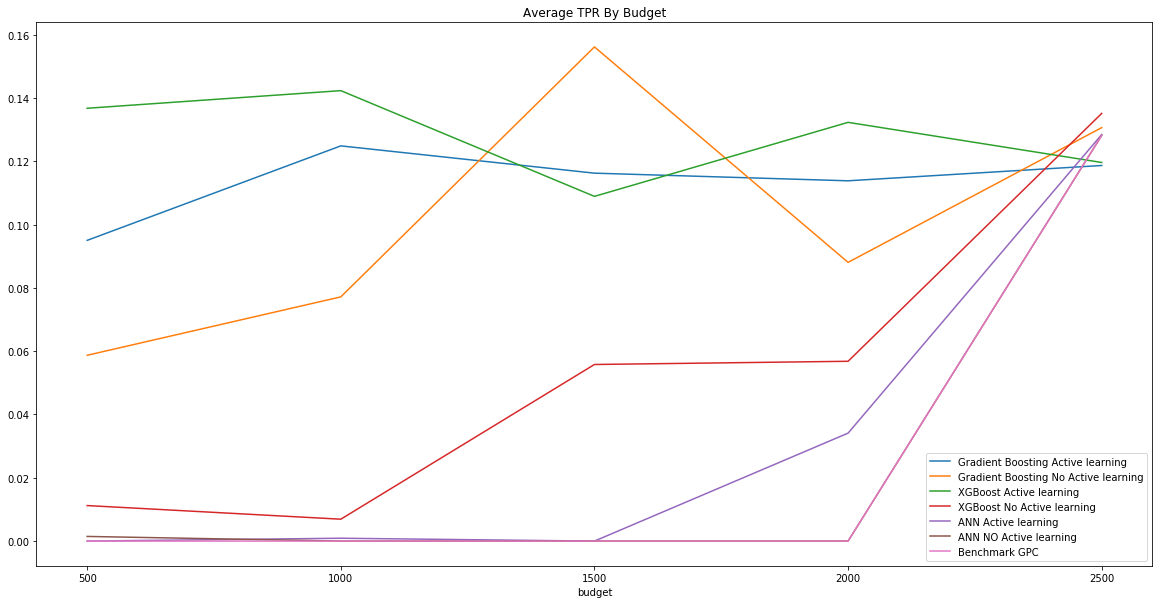

In [164]:
plt.figure(figsize=(25, 10))
tpr_ave_his_by_model.plot(figsize=(20, 10), x = 'budget', title = 'Average TPR By Budget', 
                          xticks = np.arange(500,3000,500))

# F1

In [188]:
for i in range (len(f1_ave_hist)-1):
    f1_ave_hist[i] =  pd.DataFrame(f1_ave_hist[i], index = experiment_labels)
f1_ave_hist[4] =  pd.DataFrame(ave_f1.values[:,-1], index = experiment_labels)   
f1_ave_his_by_model = np.zeros((len(f1_ave_hist), num_experiments))
for model in range(num_experiments):
    for budget_index in range(len(f1_ave_hist)):
        f1_ave_his_by_model[budget_index,model] = f1_ave_hist[budget_index].values[model][0]
        
f1_ave_his_by_model = pd.DataFrame(f1_ave_his_by_model, columns = experiment_labels)
f1_ave_his_by_model.head(7)

budget = np.arange(500,3000,500)
f1_ave_his_by_model['budget'] = budget

# F1 By budget

<Figure size 1800x720 with 0 Axes>

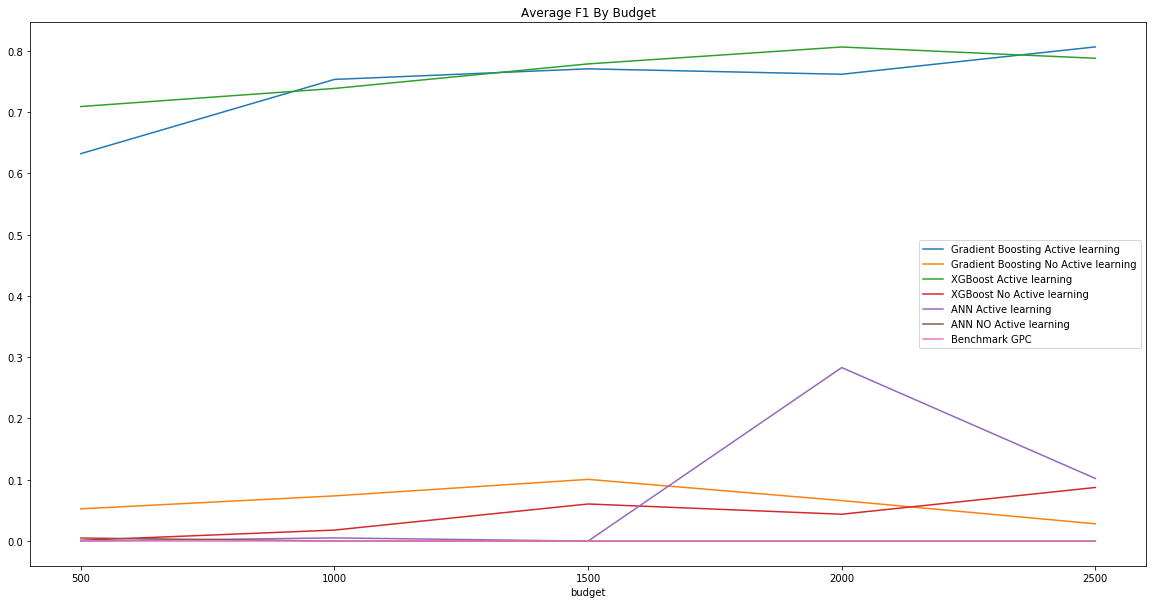

In [189]:
plt.figure(figsize=(25, 10))
f1_ave_his_by_model.plot(figsize=(20, 10), x = 'budget', title = 'Average F1 By Budget', 
                          xticks = np.arange(500,3000,500))